In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = True
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model without L2 regularization
x = Dropout(0.8)(x)
x = Dropout(0.8)(x)
x = Dropout(0.8)(x)
x = Dropout(0.8)(x)
x = base_model.output
x = Dropout(0.8)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers without L2 regularization
#x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)
#x = Flatten()(x)
#x = Dense(64, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.8)(x)
# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'InceptionResNetV2.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Found 8018 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1015 (Conv2D)           (None, 299, 224, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1015 (Batc  (None, 299, 224, 32  96         

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 515s - loss: 1.8723 - acc: 0.3826 - val_loss: 1.1122 - val_acc: 0.6688 - lr: 1.0000e-04 - 515s/epoch - 1s/step
Epoch 2/1000
126/126 [==============================] - 34s 273ms/step
Epoch 2 - Validation Loss: 1.0054, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 2: val_loss improved from 1.11220 to 1.00545, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 502s - loss: 1.2810 - acc: 0.5703 - val_loss: 1.0054 - val_acc: 0.6688 - lr: 1.0000e-04 - 502s/epoch - 1000ms/step
Epoch 3/1000
126/126 [==============================] - 34s 273ms/step
Epoch 3 - Validation Loss: 0.8598, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 3: val_loss improved from 1.00545 to 0.85983, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 501s - loss: 1.1514 - acc: 0.6253 - val_loss: 0.8598 - val_acc: 0.6688 - lr: 1.0000e-04 - 501s/epoch - 999ms/step
Epoch 4/1000
126/126 [==============================] - 34s 273ms/step
Epoch 4 - Validation Loss: 0.8248, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 4: val_loss improved from 0.85983 to 0.82485, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 502s - loss: 1.0900 - acc: 0.6490 - val_loss: 0.8248 - val_acc: 0.6688 - lr: 1.0000e-04 - 502s/epoch - 999ms/step
Epoch 5/1000
126/126 [==============================] - 34s 273ms/step
Epoch 5 - Validation Loss: 0.8158, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 5: val_loss improved from 0.82485 to 0.81580, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 501s - loss: 1.0328 - acc: 0.6571 - val_loss: 0.8158 - val_acc: 0.6688 - lr: 1.0000e-04 - 501s/epoch - 999ms/step
Epoch 6/1000
126/126 [==============================] - 34s 272ms/step
Epoch 6 - Validation Loss: 0.7999, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 6: val_loss improved from 0.81580 to 0.79987, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 501s - loss: 0.9918 - acc: 0.6616 - val_loss: 0.7999 - val_acc: 0.6688 - lr: 1.0000e-04 - 501s/epoch - 999ms/step
Epoch 7/1000
126/126 [==============================] - 34s 273ms/step
Epoch 7 - Validation Loss: 0.7621, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 7: val_loss improved from 0.79987 to 0.76212, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 501s - loss: 0.9600 - acc: 0.6616 - val_loss: 0.7621 - val_acc: 0.6688 - lr: 1.0000e-04 - 501s/epoch - 999ms/step
Epoch 8/1000
126/126 [==============================] - 34s 273ms/step
Epoch 8 - Validation Loss: 0.9474, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 8: val_loss did not improve from 0.76212
502/502 - 500s - loss: 0.9538 - acc: 0.6654 - val_loss: 0.9474 - val_acc: 0.6688 - lr: 1.0000e-04 - 500s/epoch - 996ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 9 - Validation Loss: 0.8068, Validation Accuracy: 0.6688, Validation Precision: 0.4476

Epoch 9: val_loss did not improve from 0.76212
502/502 - 500s - loss: 0.9269 - acc: 0.6714 - val_loss: 0.8068 - val_acc: 0.6688 - lr: 1.0000e-04 - 500s/epoch - 996ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 10 - Validation Loss: 0.7412, Validation Accuracy: 0.7157, Validation Precision: 0.6331

Epoch 10: val_loss improved from 0.76212 to 0.74120, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 500s - loss: 0.8795 - acc: 0.6727 - val_loss: 0.7412 - val_acc: 0.7157 - lr: 1.0000e-04 - 500s/epoch - 996ms/step
Epoch 11/1000
126/126 [==============================] - 34s 272ms/step
Epoch 11 - Validation Loss: 0.7668, Validation Accuracy: 0.7177, Validation Precision: 0.6381

Epoch 11: val_loss did not improve from 0.74120
502/502 - 498s - loss: 0.8939 - acc: 0.6806 - val_loss: 0.7668 - val_acc: 0.7177 - lr: 1.0000e-04 - 498s/epoch - 993ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 12 - Validation Loss: 0.7668, Validation Accuracy: 0.7192, Validation Precision: 0.6181

Epoch 12: val_loss did not improve from 0.74120
502/502 - 498s - loss: 0.8574 - acc: 0.6830 - val_loss: 0.7668 - val_acc: 0.7192 - lr: 1.0000e-04 - 498s/epoch - 993ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 13 - Validation Loss: 0.7876, Validation Accuracy: 0.7007, Validation Precision: 0.6761

Epoch 13: val_loss did not improve from 0.74120
502/502 - 499s - loss: 0.8498 - acc: 0.6902 - val_loss: 0.7876 - val_acc: 0.7007 - lr: 1.0000e-04 - 499s/epoch - 993ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 14 - Validation Loss: 0.7294, Validation Accuracy: 0.7237, Validation Precision: 0.6760

Epoch 14: val_loss improved from 0.74120 to 0.72941, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 500s - loss: 0.8175 - acc: 0.6899 - val_loss: 0.7294 - val_acc: 0.7237 - lr: 1.0000e-04 - 500s/epoch - 996ms/step
Epoch 15/1000
126/126 [==============================] - 34s 273ms/step
Epoch 15 - Validation Loss: 0.6698, Validation Accuracy: 0.7521, Validation Precision: 0.6718

Epoch 15: val_loss improved from 0.72941 to 0.66981, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 501s - loss: 0.8225 - acc: 0.6972 - val_loss: 0.6698 - val_acc: 0.7521 - lr: 1.0000e-04 - 501s/epoch - 998ms/step
Epoch 16/1000
126/126 [==============================] - 34s 272ms/step
Epoch 16 - Validation Loss: 0.6736, Validation Accuracy: 0.7566, Validation Precision: 0.6891

Epoch 16: val_loss did not improve from 0.66981
502/502 - 499s - loss: 0.7833 - acc: 0.7000 - val_loss: 0.6736 - val_acc: 0.7566 - lr: 1.0000e-04 - 499s/epoch - 994ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 17 - Validation Loss: 0.6437, Validation Accuracy: 0.7726, Validation Precision: 0.7020

Epoch 17: val_loss improved from 0.66981 to 0.64370, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 500s - loss: 0.7684 - acc: 0.7058 - val_loss: 0.6437 - val_acc: 0.7726 - lr: 1.0000e-04 - 500s/epoch - 996ms/step
Epoch 18/1000
126/126 [==============================] - 34s 272ms/step
Epoch 18 - Validation Loss: 0.6310, Validation Accuracy: 0.7681, Validation Precision: 0.7075

Epoch 18: val_loss improved from 0.64370 to 0.63101, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 500s - loss: 0.7397 - acc: 0.7140 - val_loss: 0.6310 - val_acc: 0.7681 - lr: 1.0000e-04 - 500s/epoch - 996ms/step
Epoch 19/1000
126/126 [==============================] - 34s 273ms/step
Epoch 19 - Validation Loss: 0.6457, Validation Accuracy: 0.7800, Validation Precision: 0.7103

Epoch 19: val_loss did not improve from 0.63101
502/502 - 498s - loss: 0.7417 - acc: 0.7149 - val_loss: 0.6457 - val_acc: 0.7800 - lr: 1.0000e-04 - 498s/epoch - 993ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 20 - Validation Loss: 0.6528, Validation Accuracy: 0.7771, Validation Precision: 0.7040

Epoch 20: val_loss did not improve from 0.63101
502/502 - 498s - loss: 0.7328 - acc: 0.7239 - val_loss: 0.6528 - val_acc: 0.7771 - lr: 1.0000e-04 - 498s/epoch - 992ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 21 - Validation Loss: 0.7357, Validation Accuracy: 0.7781, Validation Precision: 0.7281

Epoch 21: val_loss did not improve from 0.63101
502/502 - 498s - loss: 0.7177 - acc: 0.7261 - val_loss: 0.7357 - val_acc: 0.7781 - lr: 1.0000e-04 - 498s/epoch - 993ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 22 - Validation Loss: 0.6265, Validation Accuracy: 0.7661, Validation Precision: 0.6991

Epoch 22: val_loss improved from 0.63101 to 0.62653, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 500s - loss: 0.7114 - acc: 0.7306 - val_loss: 0.6265 - val_acc: 0.7661 - lr: 1.0000e-04 - 500s/epoch - 996ms/step
Epoch 23/1000
126/126 [==============================] - 34s 272ms/step
Epoch 23 - Validation Loss: 0.6795, Validation Accuracy: 0.7262, Validation Precision: 0.6679

Epoch 23: val_loss did not improve from 0.62653
502/502 - 498s - loss: 0.6935 - acc: 0.7317 - val_loss: 0.6795 - val_acc: 0.7262 - lr: 1.0000e-04 - 498s/epoch - 993ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 24 - Validation Loss: 0.6576, Validation Accuracy: 0.7416, Validation Precision: 0.6721

Epoch 24: val_loss did not improve from 0.62653
502/502 - 498s - loss: 0.6944 - acc: 0.7382 - val_loss: 0.6576 - val_acc: 0.7416 - lr: 1.0000e-04 - 498s/epoch - 992ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 25 - Validation Loss: 0.6495, Validation Accuracy: 0.7786, Validation Precision: 0.6905

Epoch 25: val_loss did not improve from 0.62653
502/502 - 498s - loss: 0.6676 - acc: 0.7477 - val_loss: 0.6495 - val_acc: 0.7786 - lr: 1.0000e-04 - 498s/epoch - 992ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 26 - Validation Loss: 0.6430, Validation Accuracy: 0.7761, Validation Precision: 0.7043

Epoch 26: val_loss did not improve from 0.62653
502/502 - 498s - loss: 0.6508 - acc: 0.7491 - val_loss: 0.6430 - val_acc: 0.7761 - lr: 1.0000e-04 - 498s/epoch - 992ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 271ms/step
Epoch 27 - Validation Loss: 0.7926, Validation Accuracy: 0.7357, Validation Precision: 0.6991

Epoch 27: val_loss did not improve from 0.62653
502/502 - 498s - loss: 0.6774 - acc: 0.7413 - val_loss: 0.7926 - val_acc: 0.7357 - lr: 1.0000e-04 - 498s/epoch - 993ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1015 (Conv2D)           (None, 299, 224, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1015 (Batc  (None, 299, 224, 32  96         ['conv2d_1015[0][0]']            
 hNormalization)                )                                                           

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 289ms/step
Val accuracy: 0.7660847880299252
Val Precision: 0.6991459793249952
Val Recall: 0.7660847880299252
Val F1 Score: 0.713657871456832


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 28s 291ms/step
Test Accuracy: 0.700990099009901
Test Precision: 0.6090687228602197
Test Recall: 0.700990099009901
Test F1 Score: 0.6333896386158878


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 242s 483ms/step


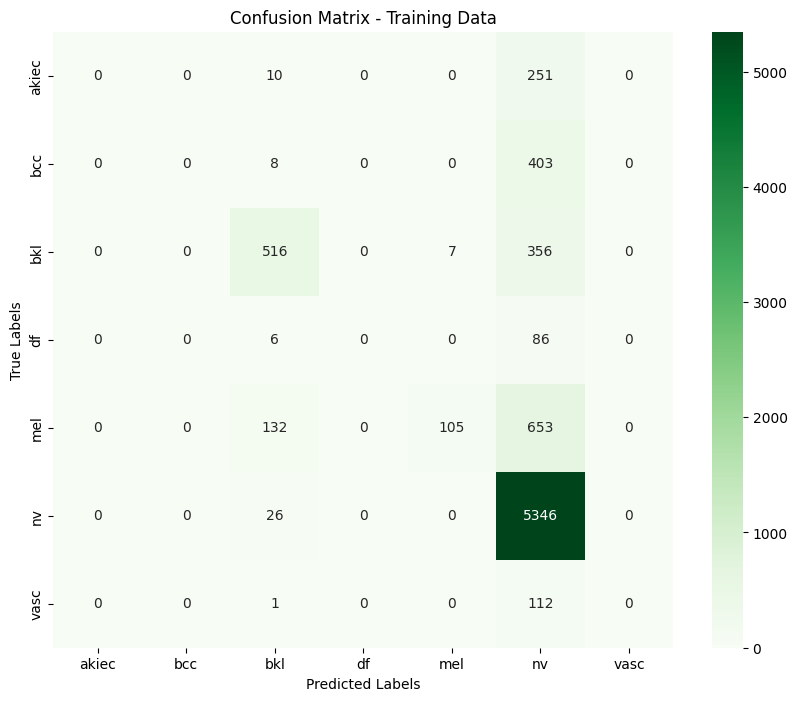

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.00      0.00      0.00       411
         bkl       0.74      0.59      0.65       879
          df       0.00      0.00      0.00        92
         mel       0.94      0.12      0.21       890
          nv       0.74      1.00      0.85      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.74      8018
   macro avg       0.35      0.24      0.24      8018
weighted avg       0.68      0.74      0.66      8018

126/126 [==============================] - 35s 275ms/step


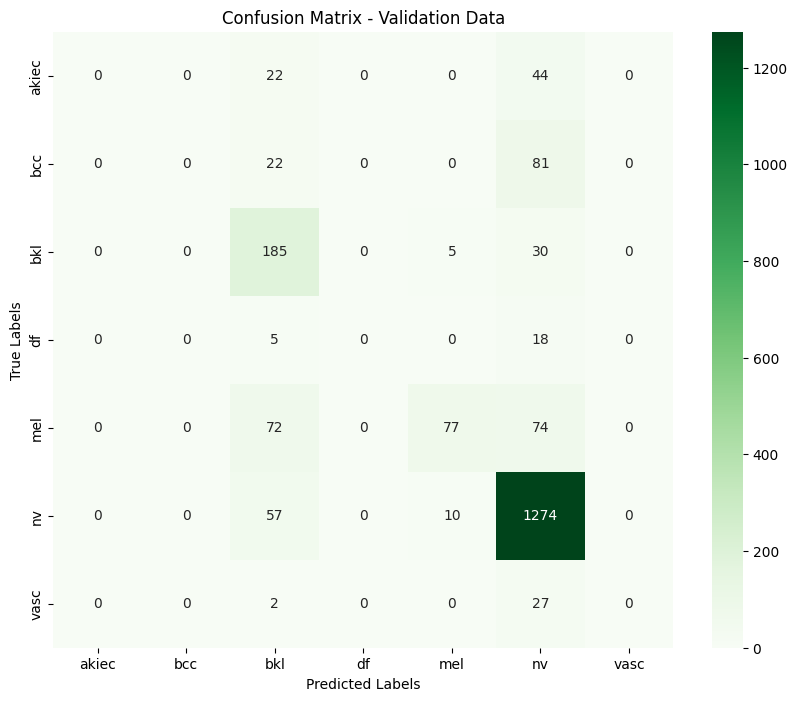

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.51      0.84      0.63       220
          df       0.00      0.00      0.00        23
         mel       0.84      0.35      0.49       223
          nv       0.82      0.95      0.88      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.77      2005
   macro avg       0.31      0.31      0.29      2005
weighted avg       0.70      0.77      0.71      2005

95/95 [==============================] - 26s 275ms/step


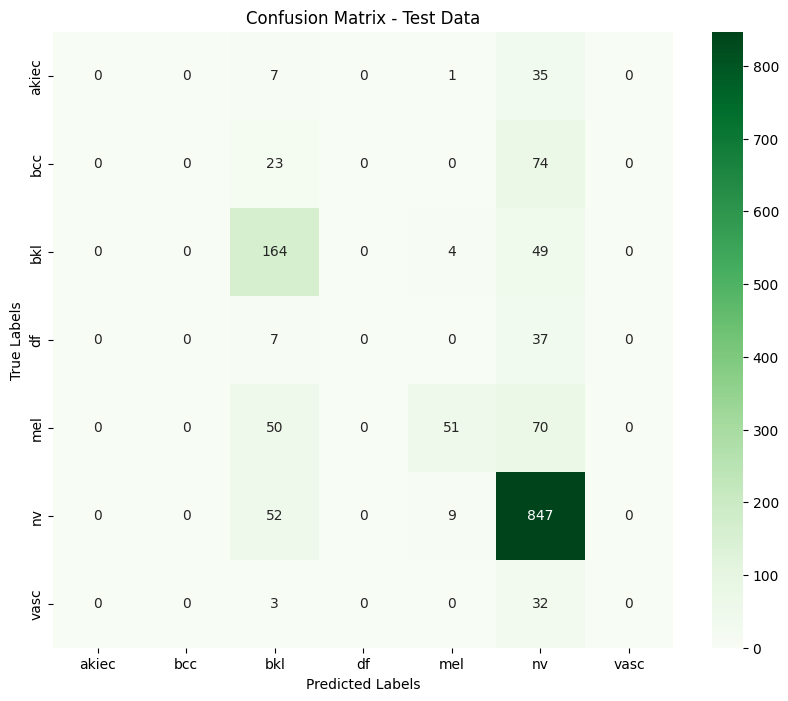

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00        97
         bkl       0.54      0.76      0.63       217
          df       0.00      0.00      0.00        44
         mel       0.78      0.30      0.43       171
          nv       0.74      0.93      0.83       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.70      1515
   macro avg       0.29      0.28      0.27      1515
weighted avg       0.61      0.70      0.63      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('InceptionResNetV2.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

y_true = train_generator.classes
y_pred = model.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Train accuracy:', accuracy)
print('Train Precision:', precision)
print('Train Recall:', recall)
print('Train F1 Score:', f1_score)

y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Val accuracy:', accuracy)
print('Val Precision:', precision)
print('Val Recall:', recall)
print('Val F1 Score:', f1_score)

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)



from sklearn.metrics import classification_report
# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')



In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = True
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model without L2 regularization
x = Dropout(0.8)(x)
x = Dropout(0.8)(x)
x = Dropout(0.8)(x)
x = Dropout(0.8)(x)
x = base_model.output
x = Dropout(0.8)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers without L2 regularization
#x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)
#x = Flatten()(x)
#x = Dense(64, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.8)(x)
# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'InceptionV3.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Found 8018 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1421 (Conv2D)           (None, 299, 224, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1421 (Batc  (None, 299, 224, 32  96         

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 275s - loss: 2.0819 - acc: 0.3088 - val_loss: 1.1173 - val_acc: 0.6688 - lr: 1.0000e-04 - 275s/epoch - 547ms/step
Epoch 2/1000
126/126 [==============================] - 14s 114ms/step
Epoch 2 - Validation Loss: 0.9592, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 2: val_loss improved from 1.11726 to 0.95924, saving model to InceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 268s - loss: 1.4606 - acc: 0.5456 - val_loss: 0.9592 - val_acc: 0.6688 - lr: 1.0000e-04 - 268s/epoch - 535ms/step
Epoch 3/1000
126/126 [==============================] - 14s 114ms/step
Epoch 3 - Validation Loss: 0.9367, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 3: val_loss improved from 0.95924 to 0.93673, saving model to InceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 267s - loss: 1.3001 - acc: 0.6189 - val_loss: 0.9367 - val_acc: 0.6688 - lr: 1.0000e-04 - 267s/epoch - 531ms/step
Epoch 4/1000
126/126 [==============================] - 14s 114ms/step
Epoch 4 - Validation Loss: 1.0140, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 4: val_loss did not improve from 0.93673
502/502 - 267s - loss: 1.1868 - acc: 0.6367 - val_loss: 1.0140 - val_acc: 0.6688 - lr: 1.0000e-04 - 267s/epoch - 532ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 5 - Validation Loss: 1.0203, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 5: val_loss did not improve from 0.93673
502/502 - 263s - loss: 1.1759 - acc: 0.6515 - val_loss: 1.0203 - val_acc: 0.6688 - lr: 1.0000e-04 - 263s/epoch - 523ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 6 - Validation Loss: 0.9952, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 6: val_loss did not improve from 0.93673
502/502 - 265s - loss: 1.1109 - acc: 0.6578 - val_loss: 0.9952 - val_acc: 0.6688 - lr: 1.0000e-04 - 265s/epoch - 528ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 111ms/step
Epoch 7 - Validation Loss: 0.8150, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 7: val_loss improved from 0.93673 to 0.81503, saving model to InceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 263s - loss: 1.0742 - acc: 0.6626 - val_loss: 0.8150 - val_acc: 0.6688 - lr: 1.0000e-04 - 263s/epoch - 525ms/step
Epoch 8/1000
126/126 [==============================] - 14s 112ms/step
Epoch 8 - Validation Loss: 1.0383, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 8: val_loss did not improve from 0.81503
502/502 - 265s - loss: 1.0680 - acc: 0.6660 - val_loss: 1.0383 - val_acc: 0.6688 - lr: 1.0000e-04 - 265s/epoch - 528ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 9 - Validation Loss: 18.9853, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 9: val_loss did not improve from 0.81503
502/502 - 263s - loss: 1.0503 - acc: 0.6663 - val_loss: 18.9853 - val_acc: 0.6688 - lr: 1.0000e-04 - 263s/epoch - 525ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 10 - Validation Loss: 0.8201, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 10: val_loss did not improve from 0.81503
502/502 - 263s - loss: 1.0357 - acc: 0.6649 - val_loss: 0.8201 - val_acc: 0.6688 - lr: 1.0000e-04 - 263s/epoch - 524ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 11 - Validation Loss: 0.8397, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 11: val_loss did not improve from 0.81503
502/502 - 264s - loss: 1.0167 - acc: 0.6697 - val_loss: 0.8397 - val_acc: 0.6688 - lr: 1.0000e-04 - 264s/epoch - 526ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 12 - Validation Loss: 0.7873, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 12: val_loss improved from 0.81503 to 0.78726, saving model to InceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 263s - loss: 0.9746 - acc: 0.6732 - val_loss: 0.7873 - val_acc: 0.6688 - lr: 1.0000e-04 - 263s/epoch - 524ms/step
Epoch 13/1000
126/126 [==============================] - 14s 112ms/step
Epoch 13 - Validation Loss: 0.8913, Validation Accuracy: 0.6798, Validation Precision: 0.5212

Epoch 13: val_loss did not improve from 0.78726
502/502 - 264s - loss: 0.9658 - acc: 0.6732 - val_loss: 0.8913 - val_acc: 0.6798 - lr: 1.0000e-04 - 264s/epoch - 526ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 14 - Validation Loss: 0.7765, Validation Accuracy: 0.6828, Validation Precision: 0.5454

Epoch 14: val_loss improved from 0.78726 to 0.77649, saving model to InceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 262s - loss: 0.9504 - acc: 0.6760 - val_loss: 0.7765 - val_acc: 0.6828 - lr: 1.0000e-04 - 262s/epoch - 523ms/step
Epoch 15/1000
126/126 [==============================] - 14s 112ms/step
Epoch 15 - Validation Loss: 0.8007, Validation Accuracy: 0.6818, Validation Precision: 0.5418

Epoch 15: val_loss did not improve from 0.77649
502/502 - 263s - loss: 0.9835 - acc: 0.6752 - val_loss: 0.8007 - val_acc: 0.6818 - lr: 1.0000e-04 - 263s/epoch - 523ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 16 - Validation Loss: 0.7639, Validation Accuracy: 0.6713, Validation Precision: 0.5401

Epoch 16: val_loss improved from 0.77649 to 0.76386, saving model to InceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 265s - loss: 0.9640 - acc: 0.6790 - val_loss: 0.7639 - val_acc: 0.6713 - lr: 1.0000e-04 - 265s/epoch - 528ms/step
Epoch 17/1000
126/126 [==============================] - 14s 112ms/step
Epoch 17 - Validation Loss: 0.7739, Validation Accuracy: 0.7267, Validation Precision: 0.5623

Epoch 17: val_loss did not improve from 0.76386
502/502 - 263s - loss: 0.9216 - acc: 0.6821 - val_loss: 0.7739 - val_acc: 0.7267 - lr: 1.0000e-04 - 263s/epoch - 524ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 18 - Validation Loss: 0.8119, Validation Accuracy: 0.7142, Validation Precision: 0.5514

Epoch 18: val_loss did not improve from 0.76386
502/502 - 262s - loss: 0.9130 - acc: 0.6848 - val_loss: 0.8119 - val_acc: 0.7142 - lr: 1.0000e-04 - 262s/epoch - 523ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 19 - Validation Loss: 0.7847, Validation Accuracy: 0.6808, Validation Precision: 0.5369

Epoch 19: val_loss did not improve from 0.76386
502/502 - 261s - loss: 1.0010 - acc: 0.6771 - val_loss: 0.7847 - val_acc: 0.6808 - lr: 1.0000e-04 - 261s/epoch - 521ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 20 - Validation Loss: 0.7817, Validation Accuracy: 0.7262, Validation Precision: 0.5615

Epoch 20: val_loss did not improve from 0.76386
502/502 - 263s - loss: 0.9696 - acc: 0.6845 - val_loss: 0.7817 - val_acc: 0.7262 - lr: 1.0000e-04 - 263s/epoch - 524ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 112ms/step
Epoch 21 - Validation Loss: 0.7921, Validation Accuracy: 0.6983, Validation Precision: 0.5401

Epoch 21: val_loss did not improve from 0.76386
502/502 - 262s - loss: 0.8947 - acc: 0.6868 - val_loss: 0.7921 - val_acc: 0.6983 - lr: 1.0000e-04 - 262s/epoch - 522ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1421 (Conv2D)           (None, 299, 224, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1421 (Batc  (None, 299, 224, 32  96         ['conv2d_1421[0][0]']            
 hNormalization)                )                                                           

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 14s 111ms/step
Val accuracy: 0.6713216957605985
Val Precision: 0.5401115354019487
Val Recall: 0.6713216957605985
Val F1 Score: 0.5419199418125769


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 11s 113ms/step
Test Accuracy: 0.6033003300330033
Test Precision: 0.5038709437544152
Test Recall: 0.6033003300330033
Test F1 Score: 0.4580185248107494


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 221s 440ms/step


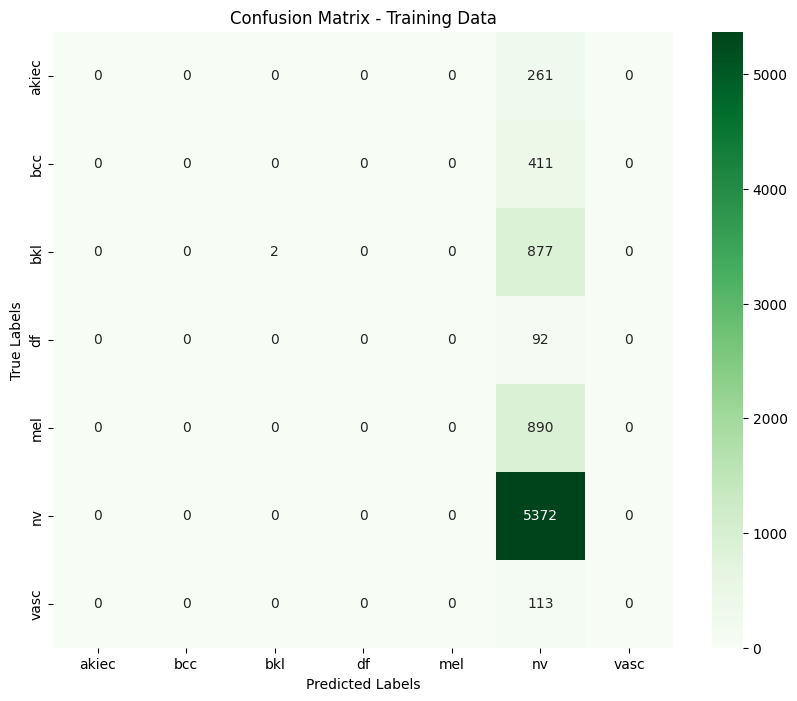

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.00      0.00      0.00       411
         bkl       1.00      0.00      0.00       879
          df       0.00      0.00      0.00        92
         mel       0.00      0.00      0.00       890
          nv       0.67      1.00      0.80      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.67      8018
   macro avg       0.24      0.14      0.12      8018
weighted avg       0.56      0.67      0.54      8018

126/126 [==============================] - 14s 111ms/step


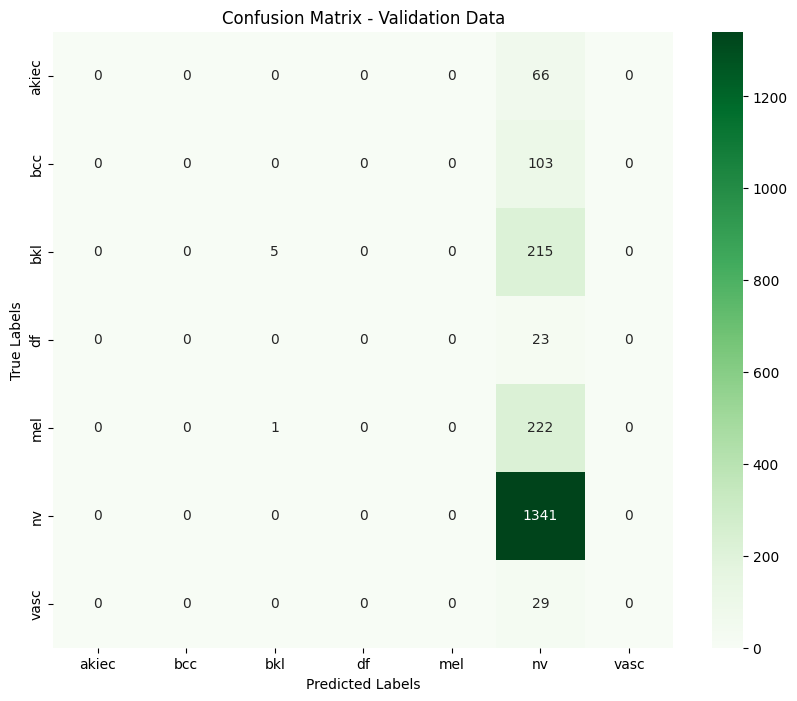

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.83      0.02      0.04       220
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
          nv       0.67      1.00      0.80      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.21      0.15      0.12      2005
weighted avg       0.54      0.67      0.54      2005

95/95 [==============================] - 11s 114ms/step


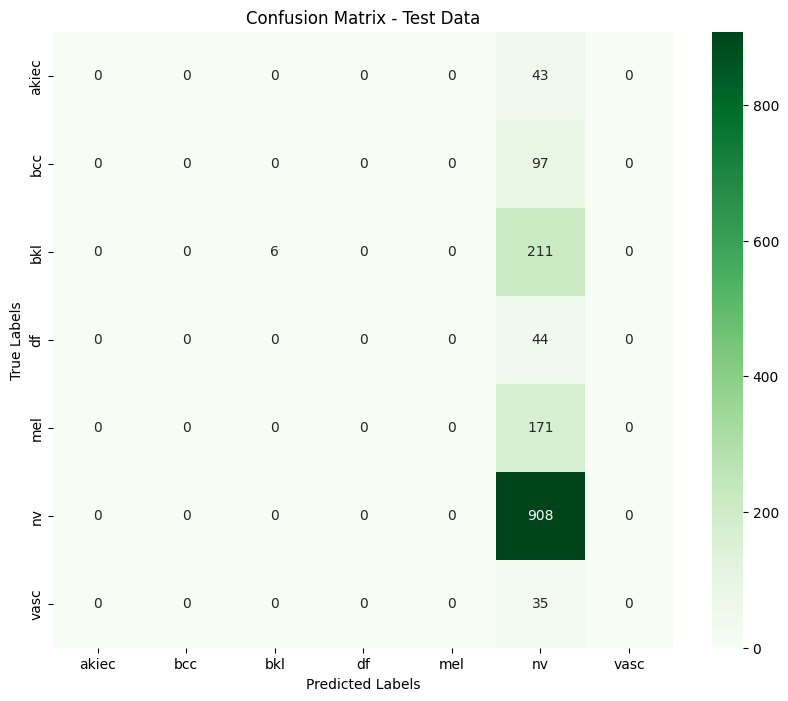

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00        97
         bkl       1.00      0.03      0.05       217
          df       0.00      0.00      0.00        44
         mel       0.00      0.00      0.00       171
          nv       0.60      1.00      0.75       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.60      1515
   macro avg       0.23      0.15      0.12      1515
weighted avg       0.50      0.60      0.46      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('InceptionV3.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

y_true = train_generator.classes
y_pred = model.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Train accuracy:', accuracy)
print('Train Precision:', precision)
print('Train Recall:', recall)
print('Train F1 Score:', f1_score)

y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Val accuracy:', accuracy)
print('Val Precision:', precision)
print('Val Recall:', recall)
print('Val F1 Score:', f1_score)

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)



from sklearn.metrics import classification_report
# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')



In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
        ## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model without L2 regularization
    x = Dropout(0.8)(x)
    x = Dropout(0.8)(x)
    x = Dropout(0.8)(x)
    x = Dropout(0.8)(x)
    x = base_model.output
    x = Dropout(0.8)(x)
    x = GlobalAveragePooling2D()(x)

# Add Dense layers without L2 regularization
#x = Dense(128, activation='relu')(x)
    x = Dropout(0.8)(x)
#x = Flatten()(x)
#x = Dense(64, activation='relu')(x)
    x = Dropout(0.8)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.8)(x)
# Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldV2.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 30s 274ms/step
Epoch 1 - Validation Loss: 1.3465, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.34655, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 420s - loss: 2.0646 - acc: 0.3237 - val_loss: 1.3465 - val_acc: 0.6696 - lr: 1.0000e-04 - 420s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 28s 273ms/step
Epoch 2 - Validation Loss: 0.9133, Validation Accuracy: 0.6696, Validation Precision: 0.4626

Epoch 2: val_loss improved from 1.34655 to 0.91334, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.3985 - acc: 0.5221 - val_loss: 0.9133 - val_acc: 0.6696 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 3/1000
101/101 [==============================] - 27s 273ms/step
Epoch 3 - Validation Loss: 0.8660, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 0.91334 to 0.86599, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.2516 - acc: 0.5934 - val_loss: 0.8660 - val_acc: 0.6696 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 4/1000
101/101 [==============================] - 28s 273ms/step
Epoch 4 - Validation Loss: 0.9109, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss did not improve from 0.86599
401/401 - 400s - loss: 1.1498 - acc: 0.6285 - val_loss: 0.9109 - val_acc: 0.6696 - lr: 1.0000e-04 - 400s/epoch - 998ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 273ms/step
Epoch 5 - Validation Loss: 0.8840, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss did not improve from 0.86599
401/401 - 400s - loss: 1.1083 - acc: 0.6450 - val_loss: 0.8840 - val_acc: 0.6696 - lr: 1.0000e-04 - 400s/epoch - 999ms/step
Fold 2
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 30s 274ms/step
Epoch 1 - Validation Loss: 1.1051, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.10509, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 416s - loss: 2.1040 - acc: 0.3960 - val_loss: 1.1051 - val_acc: 0.6696 - lr: 1.0000e-04 - 416s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 28s 273ms/step
Epoch 2 - Validation Loss: 0.9614, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.10509 to 0.96140, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.3867 - acc: 0.5681 - val_loss: 0.9614 - val_acc: 0.6696 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 3/1000
101/101 [==============================] - 28s 273ms/step
Epoch 3 - Validation Loss: 0.9006, Validation Accuracy: 0.6714, Validation Precision: 0.4922

Epoch 3: val_loss improved from 0.96140 to 0.90058, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.2252 - acc: 0.6277 - val_loss: 0.9006 - val_acc: 0.6714 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 4/1000
101/101 [==============================] - 28s 274ms/step
Epoch 4 - Validation Loss: 0.8796, Validation Accuracy: 0.6771, Validation Precision: 0.5423

Epoch 4: val_loss improved from 0.90058 to 0.87959, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.1313 - acc: 0.6520 - val_loss: 0.8796 - val_acc: 0.6771 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 5/1000
101/101 [==============================] - 27s 273ms/step
Epoch 5 - Validation Loss: 0.8876, Validation Accuracy: 0.6808, Validation Precision: 0.5276

Epoch 5: val_loss did not improve from 0.87959
401/401 - 400s - loss: 1.1114 - acc: 0.6486 - val_loss: 0.8876 - val_acc: 0.6808 - lr: 1.0000e-04 - 400s/epoch - 999ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 273ms/step
Epoch 6 - Validation Loss: 0.8984, Validation Accuracy: 0.7145, Validation Precision: 0.5423

Epoch 6: val_loss did not improve from 0.87959
401/401 - 401s - loss: 1.0350 - acc: 0.6629 - val_loss: 0.8984 - val_acc: 0.7145 - lr: 1.0000e-04 - 401s/epoch - 999ms/step
Fold 3
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 29s 273ms/step
Epoch 1 - Validation Loss: 1.5569, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.55694, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 416s - loss: 2.3119 - acc: 0.2836 - val_loss: 1.5569 - val_acc: 0.6696 - lr: 1.0000e-04 - 416s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 27s 273ms/step
Epoch 2 - Validation Loss: 0.9764, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.55694 to 0.97643, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.6240 - acc: 0.4565 - val_loss: 0.9764 - val_acc: 0.6696 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 3/1000
101/101 [==============================] - 27s 273ms/step
Epoch 3 - Validation Loss: 1.1486, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss did not improve from 0.97643
401/401 - 401s - loss: 1.4000 - acc: 0.5561 - val_loss: 1.1486 - val_acc: 0.6696 - lr: 1.0000e-04 - 401s/epoch - 999ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 4 - Validation Loss: 0.8815, Validation Accuracy: 0.6708, Validation Precision: 0.4866

Epoch 4: val_loss improved from 0.97643 to 0.88154, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.2796 - acc: 0.5926 - val_loss: 0.8815 - val_acc: 0.6708 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 5/1000
101/101 [==============================] - 27s 273ms/step
Epoch 5 - Validation Loss: 0.8709, Validation Accuracy: 0.7176, Validation Precision: 0.5646

Epoch 5: val_loss improved from 0.88154 to 0.87091, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.2033 - acc: 0.6166 - val_loss: 0.8709 - val_acc: 0.7176 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 6/1000
101/101 [==============================] - 28s 274ms/step
Epoch 6 - Validation Loss: 0.8571, Validation Accuracy: 0.7282, Validation Precision: 0.5817

Epoch 6: val_loss improved from 0.87091 to 0.85711, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 403s - loss: 1.1428 - acc: 0.6497 - val_loss: 0.8571 - val_acc: 0.7282 - lr: 1.0000e-04 - 403s/epoch - 1s/step
Epoch 7/1000
101/101 [==============================] - 28s 273ms/step
Epoch 7 - Validation Loss: 0.9078, Validation Accuracy: 0.6989, Validation Precision: 0.6418

Epoch 7: val_loss did not improve from 0.85711
401/401 - 401s - loss: 1.0712 - acc: 0.6536 - val_loss: 0.9078 - val_acc: 0.6989 - lr: 1.0000e-04 - 401s/epoch - 999ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 273ms/step
Epoch 8 - Validation Loss: 0.7856, Validation Accuracy: 0.7226, Validation Precision: 0.5665

Epoch 8: val_loss improved from 0.85711 to 0.78560, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.0500 - acc: 0.6578 - val_loss: 0.7856 - val_acc: 0.7226 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 9/1000
101/101 [==============================] - 28s 274ms/step
Epoch 9 - Validation Loss: 0.8000, Validation Accuracy: 0.7294, Validation Precision: 0.6170

Epoch 9: val_loss did not improve from 0.78560
401/401 - 401s - loss: 1.0289 - acc: 0.6628 - val_loss: 0.8000 - val_acc: 0.7294 - lr: 1.0000e-04 - 401s/epoch - 999ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 10 - Validation Loss: 0.8311, Validation Accuracy: 0.7188, Validation Precision: 0.5665

Epoch 10: val_loss did not improve from 0.78560
401/401 - 401s - loss: 1.0315 - acc: 0.6710 - val_loss: 0.8311 - val_acc: 0.7188 - lr: 1.0000e-04 - 401s/epoch - 999ms/step
Fold 4
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 29s 273ms/step
Epoch 1 - Validation Loss: 1.4140, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.41403, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 421s - loss: 2.1063 - acc: 0.2956 - val_loss: 1.4140 - val_acc: 0.6706 - lr: 1.0000e-04 - 421s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 27s 273ms/step
Epoch 2 - Validation Loss: 1.0223, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.41403 to 1.02234, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.5329 - acc: 0.4655 - val_loss: 1.0223 - val_acc: 0.6706 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 3/1000
101/101 [==============================] - 27s 273ms/step
Epoch 3 - Validation Loss: 0.9605, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss improved from 1.02234 to 0.96046, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.3412 - acc: 0.5532 - val_loss: 0.9605 - val_acc: 0.6706 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 4/1000
101/101 [==============================] - 27s 273ms/step
Epoch 4 - Validation Loss: 0.9488, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 4: val_loss improved from 0.96046 to 0.94877, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.2134 - acc: 0.5931 - val_loss: 0.9488 - val_acc: 0.6706 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 5/1000
101/101 [==============================] - 27s 273ms/step
Epoch 5 - Validation Loss: 0.9210, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 5: val_loss improved from 0.94877 to 0.92104, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.1316 - acc: 0.6218 - val_loss: 0.9210 - val_acc: 0.6706 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 6/1000
101/101 [==============================] - 27s 273ms/step
Epoch 6 - Validation Loss: 0.8204, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 6: val_loss improved from 0.92104 to 0.82043, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.0735 - acc: 0.6391 - val_loss: 0.8204 - val_acc: 0.6706 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 7/1000
101/101 [==============================] - 28s 273ms/step
Epoch 7 - Validation Loss: 0.7855, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 7: val_loss improved from 0.82043 to 0.78554, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.0214 - acc: 0.6483 - val_loss: 0.7855 - val_acc: 0.6706 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 8/1000
101/101 [==============================] - 27s 273ms/step
Epoch 8 - Validation Loss: 0.8086, Validation Accuracy: 0.6875, Validation Precision: 0.5500

Epoch 8: val_loss did not improve from 0.78554
401/401 - 400s - loss: 1.0142 - acc: 0.6536 - val_loss: 0.8086 - val_acc: 0.6875 - lr: 1.0000e-04 - 400s/epoch - 999ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 273ms/step
Epoch 9 - Validation Loss: 0.7914, Validation Accuracy: 0.6756, Validation Precision: 0.4497

Epoch 9: val_loss did not improve from 0.78554
401/401 - 401s - loss: 0.9629 - acc: 0.6625 - val_loss: 0.7914 - val_acc: 0.6756 - lr: 1.0000e-04 - 401s/epoch - 999ms/step
Fold 5
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 29s 274ms/step
Epoch 1 - Validation Loss: 1.7182, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.71821, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 416s - loss: 2.3540 - acc: 0.2544 - val_loss: 1.7182 - val_acc: 0.6706 - lr: 1.0000e-04 - 416s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 27s 273ms/step
Epoch 2 - Validation Loss: 1.3341, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.71821 to 1.33406, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.6382 - acc: 0.4469 - val_loss: 1.3341 - val_acc: 0.6706 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 3/1000
101/101 [==============================] - 28s 273ms/step
Epoch 3 - Validation Loss: 1.2928, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss improved from 1.33406 to 1.29279, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.3813 - acc: 0.5652 - val_loss: 1.2928 - val_acc: 0.6706 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 4/1000
101/101 [==============================] - 28s 273ms/step
Epoch 4 - Validation Loss: 1.0261, Validation Accuracy: 0.6893, Validation Precision: 0.5256

Epoch 4: val_loss improved from 1.29279 to 1.02609, saving model to 5foldV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 402s - loss: 1.2633 - acc: 0.6087 - val_loss: 1.0261 - val_acc: 0.6893 - lr: 1.0000e-04 - 402s/epoch - 1s/step
Epoch 5/1000
101/101 [==============================] - 28s 274ms/step
Epoch 5 - Validation Loss: 1.1674, Validation Accuracy: 0.6900, Validation Precision: 0.5237

Epoch 5: val_loss did not improve from 1.02609
401/401 - 401s - loss: 1.1883 - acc: 0.6313 - val_loss: 1.1674 - val_acc: 0.6900 - lr: 1.0000e-04 - 401s/epoch - 999ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 273ms/step
Epoch 6 - Validation Loss: 1.5231, Validation Accuracy: 0.6750, Validation Precision: 0.5256

Epoch 6: val_loss did not improve from 1.02609
401/401 - 401s - loss: 1.1147 - acc: 0.6572 - val_loss: 1.5231 - val_acc: 0.6750 - lr: 1.0000e-04 - 401s/epoch - 999ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2327 (Conv2D)           (None, 299, 224, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_2327 (Batc  (None, 299, 224, 32  96         ['conv2d_2327[0][0]']            
 hNormalization)                )                                                          

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 275ms/step - loss: 0.8739 - acc: 0.6908
Validation accuracy: 0.690773069858551
126/126 [==============================] - 34s 273ms/step
Validation Precision: 0.5258
Validation Recall: 0.6908
Validation F1-Score: 0.5819



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 26s 276ms/step - loss: 1.0460 - acc: 0.6284
Test accuracy: 0.6283828616142273
95/95 [==============================] - 26s 273ms/step
Test Precision: 0.4610
Test Recall: 0.6284
Test F1-Score: 0.5094



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 235s 468ms/step


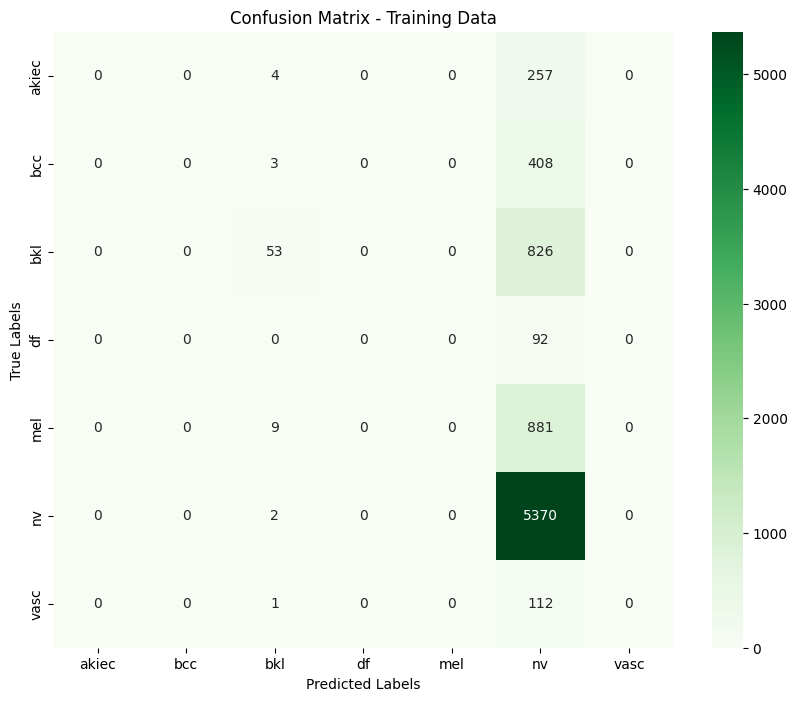

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.00      0.00      0.00       411
         bkl       0.74      0.06      0.11       879
          df       0.00      0.00      0.00        92
         mel       0.00      0.00      0.00       890
          nv       0.68      1.00      0.81      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.68      8018
   macro avg       0.20      0.15      0.13      8018
weighted avg       0.53      0.68      0.55      8018

126/126 [==============================] - 34s 273ms/step


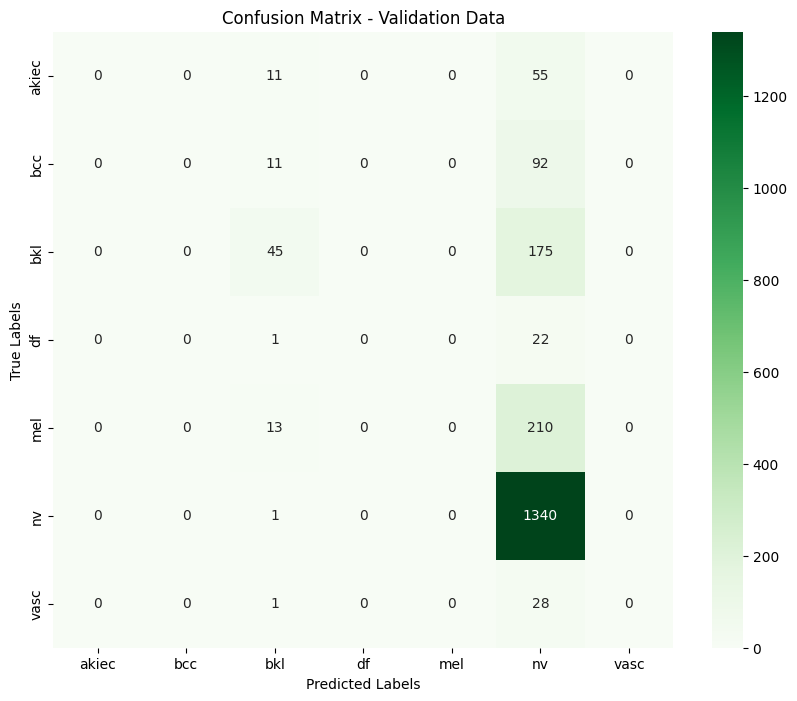

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.54      0.20      0.30       220
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
          nv       0.70      1.00      0.82      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.69      2005
   macro avg       0.18      0.17      0.16      2005
weighted avg       0.53      0.69      0.58      2005

95/95 [==============================] - 26s 273ms/step


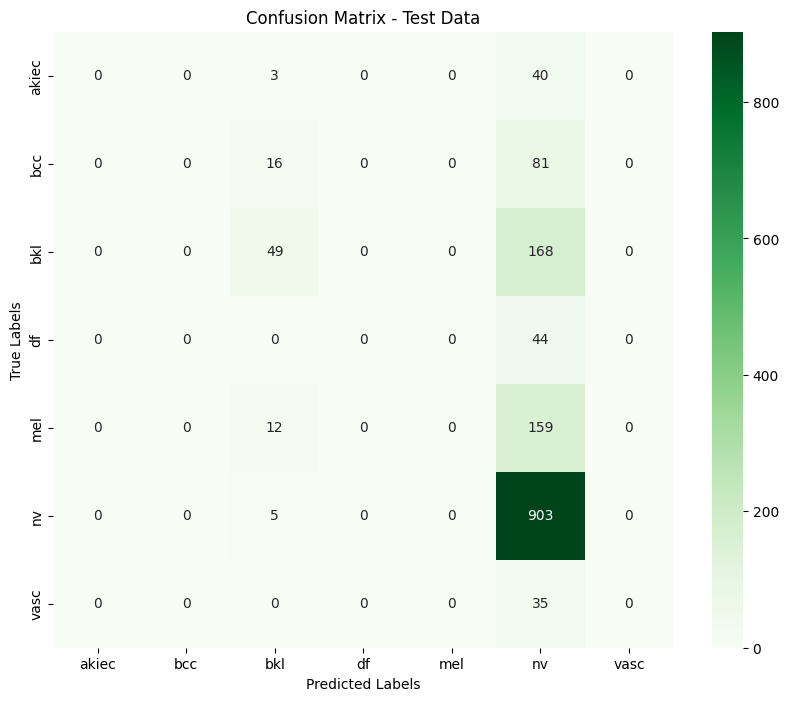

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00        97
         bkl       0.58      0.23      0.32       217
          df       0.00      0.00      0.00        44
         mel       0.00      0.00      0.00       171
          nv       0.63      0.99      0.77       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.63      1515
   macro avg       0.17      0.17      0.16      1515
weighted avg       0.46      0.63      0.51      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldV2.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
        ## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model without L2 regularization
    x = Dropout(0.8)(x)
    x = Dropout(0.8)(x)
    x = Dropout(0.8)(x)
    x = Dropout(0.8)(x)
    x = base_model.output
    x = Dropout(0.8)(x)
    x = GlobalAveragePooling2D()(x)

# Add Dense layers without L2 regularization
#x = Dense(128, activation='relu')(x)
    x = Dropout(0.8)(x)
#x = Flatten()(x)
#x = Dense(64, activation='relu')(x)
    x = Dropout(0.8)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.8)(x)
# Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldV3.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 12s 116ms/step
Epoch 1 - Validation Loss: 0.9635, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 0.96350, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 222s - loss: 1.9493 - acc: 0.3703 - val_loss: 0.9635 - val_acc: 0.6696 - lr: 1.0000e-04 - 222s/epoch - 554ms/step
Epoch 2/1000
101/101 [==============================] - 12s 116ms/step
Epoch 2 - Validation Loss: 0.9373, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 0.96350 to 0.93733, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 217s - loss: 1.4100 - acc: 0.5408 - val_loss: 0.9373 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 3/1000
101/101 [==============================] - 12s 115ms/step
Epoch 3 - Validation Loss: 0.8959, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 0.93733 to 0.89592, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 217s - loss: 1.2479 - acc: 0.5970 - val_loss: 0.8959 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 4/1000
101/101 [==============================] - 12s 115ms/step
Epoch 4 - Validation Loss: 0.8671, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss improved from 0.89592 to 0.86711, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 217s - loss: 1.1612 - acc: 0.6367 - val_loss: 0.8671 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 5/1000
101/101 [==============================] - 12s 116ms/step
Epoch 5 - Validation Loss: 0.8953, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss did not improve from 0.86711
401/401 - 216s - loss: 1.1099 - acc: 0.6487 - val_loss: 0.8953 - val_acc: 0.6696 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 116ms/step
Epoch 6 - Validation Loss: 0.8670, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 6: val_loss improved from 0.86711 to 0.86701, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 216s - loss: 1.0501 - acc: 0.6562 - val_loss: 0.8670 - val_acc: 0.6696 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 7/1000
101/101 [==============================] - 12s 115ms/step
Epoch 7 - Validation Loss: 0.8613, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 7: val_loss improved from 0.86701 to 0.86131, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 215s - loss: 1.0531 - acc: 0.6581 - val_loss: 0.8613 - val_acc: 0.6696 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 8/1000
101/101 [==============================] - 12s 115ms/step
Epoch 8 - Validation Loss: 0.8524, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 8: val_loss improved from 0.86131 to 0.85237, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 217s - loss: 1.0216 - acc: 0.6643 - val_loss: 0.8524 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 9/1000
101/101 [==============================] - 12s 115ms/step
Epoch 9 - Validation Loss: 0.9333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 9: val_loss did not improve from 0.85237
401/401 - 215s - loss: 0.9927 - acc: 0.6676 - val_loss: 0.9333 - val_acc: 0.6696 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 115ms/step
Epoch 10 - Validation Loss: 0.9309, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 10: val_loss did not improve from 0.85237
401/401 - 216s - loss: 1.0026 - acc: 0.6693 - val_loss: 0.9309 - val_acc: 0.6696 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 116ms/step
Epoch 11 - Validation Loss: 0.8480, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 11: val_loss improved from 0.85237 to 0.84802, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 216s - loss: 0.9758 - acc: 0.6695 - val_loss: 0.8480 - val_acc: 0.6696 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 12/1000
101/101 [==============================] - 12s 115ms/step
Epoch 12 - Validation Loss: 0.8386, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 12: val_loss improved from 0.84802 to 0.83857, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 215s - loss: 0.9671 - acc: 0.6738 - val_loss: 0.8386 - val_acc: 0.6696 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 13/1000
101/101 [==============================] - 12s 116ms/step
Epoch 13 - Validation Loss: 1.0252, Validation Accuracy: 0.6721, Validation Precision: 0.5054

Epoch 13: val_loss did not improve from 0.83857
401/401 - 217s - loss: 0.9441 - acc: 0.6793 - val_loss: 1.0252 - val_acc: 0.6721 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 115ms/step
Epoch 14 - Validation Loss: 0.8407, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 14: val_loss did not improve from 0.83857
401/401 - 243s - loss: 0.9805 - acc: 0.6742 - val_loss: 0.8407 - val_acc: 0.6696 - lr: 1.0000e-04 - 243s/epoch - 606ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 116ms/step
Epoch 15 - Validation Loss: 0.8701, Validation Accuracy: 0.6933, Validation Precision: 0.5787

Epoch 15: val_loss did not improve from 0.83857
401/401 - 214s - loss: 0.8949 - acc: 0.6779 - val_loss: 0.8701 - val_acc: 0.6933 - lr: 1.0000e-04 - 214s/epoch - 534ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 16 - Validation Loss: 0.8132, Validation Accuracy: 0.6995, Validation Precision: 0.5510

Epoch 16: val_loss improved from 0.83857 to 0.81322, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 217s - loss: 0.8950 - acc: 0.6791 - val_loss: 0.8132 - val_acc: 0.6995 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 17/1000
101/101 [==============================] - 12s 115ms/step
Epoch 17 - Validation Loss: 0.9470, Validation Accuracy: 0.6951, Validation Precision: 0.5786

Epoch 17: val_loss did not improve from 0.81322
401/401 - 215s - loss: 0.8871 - acc: 0.6848 - val_loss: 0.9470 - val_acc: 0.6951 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 115ms/step
Epoch 18 - Validation Loss: 0.7837, Validation Accuracy: 0.7195, Validation Precision: 0.5571

Epoch 18: val_loss improved from 0.81322 to 0.78368, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 218s - loss: 0.8791 - acc: 0.6876 - val_loss: 0.7837 - val_acc: 0.7195 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 19/1000
101/101 [==============================] - 12s 115ms/step
Epoch 19 - Validation Loss: 0.9539, Validation Accuracy: 0.7138, Validation Precision: 0.6680

Epoch 19: val_loss did not improve from 0.78368
401/401 - 216s - loss: 0.8817 - acc: 0.6865 - val_loss: 0.9539 - val_acc: 0.7138 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 116ms/step
Epoch 20 - Validation Loss: 0.9259, Validation Accuracy: 0.7089, Validation Precision: 0.5577

Epoch 20: val_loss did not improve from 0.78368
401/401 - 216s - loss: 0.8574 - acc: 0.6890 - val_loss: 0.9259 - val_acc: 0.7089 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 115ms/step
Epoch 21 - Validation Loss: 0.8878, Validation Accuracy: 0.6752, Validation Precision: 0.6006

Epoch 21: val_loss did not improve from 0.78368
401/401 - 218s - loss: 0.8455 - acc: 0.6961 - val_loss: 0.8878 - val_acc: 0.6752 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 115ms/step
Epoch 22 - Validation Loss: 0.7583, Validation Accuracy: 0.7444, Validation Precision: 0.6279

Epoch 22: val_loss improved from 0.78368 to 0.75833, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 215s - loss: 0.8405 - acc: 0.7022 - val_loss: 0.7583 - val_acc: 0.7444 - lr: 1.0000e-04 - 215s/epoch - 535ms/step
Epoch 23/1000
101/101 [==============================] - 12s 115ms/step
Epoch 23 - Validation Loss: 0.7636, Validation Accuracy: 0.7388, Validation Precision: 0.6295

Epoch 23: val_loss did not improve from 0.75833
401/401 - 216s - loss: 0.8347 - acc: 0.7021 - val_loss: 0.7636 - val_acc: 0.7388 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 24 - Validation Loss: 0.7702, Validation Accuracy: 0.7207, Validation Precision: 0.6776

Epoch 24: val_loss did not improve from 0.75833
401/401 - 217s - loss: 0.7919 - acc: 0.7044 - val_loss: 0.7702 - val_acc: 0.7207 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 116ms/step
Epoch 25 - Validation Loss: 0.7673, Validation Accuracy: 0.7400, Validation Precision: 0.6298

Epoch 25: val_loss did not improve from 0.75833
401/401 - 214s - loss: 0.8032 - acc: 0.6996 - val_loss: 0.7673 - val_acc: 0.7400 - lr: 1.0000e-04 - 214s/epoch - 534ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 26 - Validation Loss: 0.8513, Validation Accuracy: 0.7288, Validation Precision: 0.6138

Epoch 26: val_loss did not improve from 0.75833
401/401 - 216s - loss: 0.7845 - acc: 0.7064 - val_loss: 0.8513 - val_acc: 0.7288 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 115ms/step
Epoch 27 - Validation Loss: 0.8058, Validation Accuracy: 0.7425, Validation Precision: 0.6279

Epoch 27: val_loss did not improve from 0.75833
401/401 - 216s - loss: 0.8396 - acc: 0.7022 - val_loss: 0.8058 - val_acc: 0.7425 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Fold 2
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 12s 117ms/step
Epoch 1 - Validation Loss: 1.1735, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.17345, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 224s - loss: 2.0703 - acc: 0.3258 - val_loss: 1.1735 - val_acc: 0.6696 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 2/1000
101/101 [==============================] - 12s 117ms/step
Epoch 2 - Validation Loss: 1.2491, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss did not improve from 1.17345
401/401 - 216s - loss: 1.4676 - acc: 0.5452 - val_loss: 1.2491 - val_acc: 0.6696 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 3 - Validation Loss: 0.9389, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.17345 to 0.93885, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 216s - loss: 1.2841 - acc: 0.6070 - val_loss: 0.9389 - val_acc: 0.6696 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 4/1000
101/101 [==============================] - 12s 117ms/step
Epoch 4 - Validation Loss: 0.9318, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss improved from 0.93885 to 0.93176, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 218s - loss: 1.2076 - acc: 0.6333 - val_loss: 0.9318 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 542ms/step
Epoch 5/1000
101/101 [==============================] - 12s 118ms/step
Epoch 5 - Validation Loss: 0.9630, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss did not improve from 0.93176
401/401 - 217s - loss: 1.1333 - acc: 0.6466 - val_loss: 0.9630 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 6 - Validation Loss: 0.9243, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 6: val_loss improved from 0.93176 to 0.92430, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 218s - loss: 1.0859 - acc: 0.6558 - val_loss: 0.9243 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 7/1000
101/101 [==============================] - 12s 118ms/step
Epoch 7 - Validation Loss: 0.9049, Validation Accuracy: 0.6696, Validation Precision: 0.4489

Epoch 7: val_loss improved from 0.92430 to 0.90495, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 218s - loss: 1.0705 - acc: 0.6601 - val_loss: 0.9049 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 545ms/step
Epoch 8/1000
101/101 [==============================] - 12s 118ms/step
Epoch 8 - Validation Loss: 0.8952, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 8: val_loss improved from 0.90495 to 0.89522, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 218s - loss: 1.0584 - acc: 0.6590 - val_loss: 0.8952 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 545ms/step
Epoch 9/1000
101/101 [==============================] - 12s 118ms/step
Epoch 9 - Validation Loss: 1.0814, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 9: val_loss did not improve from 0.89522
401/401 - 217s - loss: 1.0192 - acc: 0.6676 - val_loss: 1.0814 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 10 - Validation Loss: 0.8887, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 10: val_loss improved from 0.89522 to 0.88873, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 217s - loss: 1.0400 - acc: 0.6724 - val_loss: 0.8887 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 11/1000
101/101 [==============================] - 12s 117ms/step
Epoch 11 - Validation Loss: 0.8496, Validation Accuracy: 0.6796, Validation Precision: 0.5201

Epoch 11: val_loss improved from 0.88873 to 0.84958, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 217s - loss: 1.0058 - acc: 0.6685 - val_loss: 0.8496 - val_acc: 0.6796 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 12/1000
101/101 [==============================] - 12s 117ms/step
Epoch 12 - Validation Loss: 0.9447, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 12: val_loss did not improve from 0.84958
401/401 - 217s - loss: 0.9861 - acc: 0.6712 - val_loss: 0.9447 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 13 - Validation Loss: 0.9209, Validation Accuracy: 0.6920, Validation Precision: 0.5264

Epoch 13: val_loss did not improve from 0.84958
401/401 - 217s - loss: 0.9612 - acc: 0.6760 - val_loss: 0.9209 - val_acc: 0.6920 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 14 - Validation Loss: 0.8784, Validation Accuracy: 0.6964, Validation Precision: 0.5299

Epoch 14: val_loss did not improve from 0.84958
401/401 - 217s - loss: 0.9893 - acc: 0.6752 - val_loss: 0.8784 - val_acc: 0.6964 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 15 - Validation Loss: 0.8785, Validation Accuracy: 0.7157, Validation Precision: 0.5507

Epoch 15: val_loss did not improve from 0.84958
401/401 - 216s - loss: 0.9102 - acc: 0.6824 - val_loss: 0.8785 - val_acc: 0.7157 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 118ms/step
Epoch 16 - Validation Loss: 0.9283, Validation Accuracy: 0.7182, Validation Precision: 0.5201

Epoch 16: val_loss did not improve from 0.84958
401/401 - 218s - loss: 0.8878 - acc: 0.6798 - val_loss: 0.9283 - val_acc: 0.7182 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Fold 3
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 12s 116ms/step
Epoch 1 - Validation Loss: 1.3346, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.33455, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 223s - loss: 2.1550 - acc: 0.2839 - val_loss: 1.3346 - val_acc: 0.6696 - lr: 1.0000e-04 - 223s/epoch - 556ms/step
Epoch 2/1000
101/101 [==============================] - 12s 117ms/step
Epoch 2 - Validation Loss: 1.2293, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.33455 to 1.22929, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 216s - loss: 1.5120 - acc: 0.4997 - val_loss: 1.2293 - val_acc: 0.6696 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 3/1000
101/101 [==============================] - 12s 116ms/step
Epoch 3 - Validation Loss: 0.8803, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.22929 to 0.88027, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 218s - loss: 1.3228 - acc: 0.5929 - val_loss: 0.8803 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 4/1000
101/101 [==============================] - 13s 131ms/step
Epoch 4 - Validation Loss: 0.9002, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss did not improve from 0.88027
401/401 - 218s - loss: 1.2106 - acc: 0.6257 - val_loss: 0.9002 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 119ms/step
Epoch 5 - Validation Loss: 0.8756, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss improved from 0.88027 to 0.87562, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 219s - loss: 1.1630 - acc: 0.6331 - val_loss: 0.8756 - val_acc: 0.6696 - lr: 1.0000e-04 - 219s/epoch - 545ms/step
Epoch 6/1000
101/101 [==============================] - 12s 117ms/step
Epoch 6 - Validation Loss: 1.1196, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 6: val_loss did not improve from 0.87562
401/401 - 217s - loss: 1.1121 - acc: 0.6389 - val_loss: 1.1196 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 13s 126ms/step
Epoch 7 - Validation Loss: 0.8761, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 7: val_loss did not improve from 0.87562
401/401 - 218s - loss: 1.0926 - acc: 0.6480 - val_loss: 0.8761 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 8 - Validation Loss: 0.8315, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 8: val_loss improved from 0.87562 to 0.83152, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 220s - loss: 1.0682 - acc: 0.6533 - val_loss: 0.8315 - val_acc: 0.6696 - lr: 1.0000e-04 - 220s/epoch - 549ms/step
Epoch 9/1000
101/101 [==============================] - 12s 117ms/step
Epoch 9 - Validation Loss: 1.5524, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 9: val_loss did not improve from 0.83152
401/401 - 219s - loss: 1.0513 - acc: 0.6547 - val_loss: 1.5524 - val_acc: 0.6696 - lr: 1.0000e-04 - 219s/epoch - 545ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 10 - Validation Loss: 0.8633, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 10: val_loss did not improve from 0.83152
401/401 - 217s - loss: 1.0735 - acc: 0.6617 - val_loss: 0.8633 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 14s 135ms/step
Epoch 11 - Validation Loss: 0.8237, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 11: val_loss improved from 0.83152 to 0.82373, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 284s - loss: 1.0880 - acc: 0.6667 - val_loss: 0.8237 - val_acc: 0.6696 - lr: 1.0000e-04 - 284s/epoch - 709ms/step
Epoch 12/1000
101/101 [==============================] - 13s 132ms/step
Epoch 12 - Validation Loss: 0.8229, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 12: val_loss improved from 0.82373 to 0.82288, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 251s - loss: 1.0412 - acc: 0.6639 - val_loss: 0.8229 - val_acc: 0.6696 - lr: 1.0000e-04 - 251s/epoch - 626ms/step
Epoch 13/1000
101/101 [==============================] - 11s 111ms/step
Epoch 13 - Validation Loss: 0.7989, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 13: val_loss improved from 0.82288 to 0.79889, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 235s - loss: 0.9959 - acc: 0.6656 - val_loss: 0.7989 - val_acc: 0.6696 - lr: 1.0000e-04 - 235s/epoch - 586ms/step
Epoch 14/1000
101/101 [==============================] - 12s 116ms/step
Epoch 14 - Validation Loss: 0.8097, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 14: val_loss did not improve from 0.79889
401/401 - 209s - loss: 0.9779 - acc: 0.6664 - val_loss: 0.8097 - val_acc: 0.6696 - lr: 1.0000e-04 - 209s/epoch - 520ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 115ms/step
Epoch 15 - Validation Loss: 0.8141, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 15: val_loss did not improve from 0.79889
401/401 - 213s - loss: 0.9398 - acc: 0.6685 - val_loss: 0.8141 - val_acc: 0.6696 - lr: 1.0000e-04 - 213s/epoch - 531ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 115ms/step
Epoch 16 - Validation Loss: 0.8897, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 16: val_loss did not improve from 0.79889
401/401 - 214s - loss: 0.9153 - acc: 0.6743 - val_loss: 0.8897 - val_acc: 0.6696 - lr: 1.0000e-04 - 214s/epoch - 534ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 116ms/step
Epoch 17 - Validation Loss: 0.9564, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 17: val_loss did not improve from 0.79889
401/401 - 214s - loss: 0.9139 - acc: 0.6693 - val_loss: 0.9564 - val_acc: 0.6696 - lr: 1.0000e-04 - 214s/epoch - 534ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 115ms/step
Epoch 18 - Validation Loss: 0.8185, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 18: val_loss did not improve from 0.79889
401/401 - 212s - loss: 0.9083 - acc: 0.6731 - val_loss: 0.8185 - val_acc: 0.6696 - lr: 1.0000e-04 - 212s/epoch - 528ms/step
Fold 4
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 12s 116ms/step
Epoch 1 - Validation Loss: 1.0875, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.08746, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 223s - loss: 1.8741 - acc: 0.4072 - val_loss: 1.0875 - val_acc: 0.6706 - lr: 1.0000e-04 - 223s/epoch - 557ms/step
Epoch 2/1000
101/101 [==============================] - 12s 117ms/step
Epoch 2 - Validation Loss: 1.7104, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss did not improve from 1.08746
401/401 - 213s - loss: 1.3662 - acc: 0.5768 - val_loss: 1.7104 - val_acc: 0.6706 - lr: 1.0000e-04 - 213s/epoch - 531ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 116ms/step
Epoch 3 - Validation Loss: 0.9661, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss improved from 1.08746 to 0.96611, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 214s - loss: 1.2549 - acc: 0.6165 - val_loss: 0.9661 - val_acc: 0.6706 - lr: 1.0000e-04 - 214s/epoch - 533ms/step
Epoch 4/1000
101/101 [==============================] - 12s 115ms/step
Epoch 4 - Validation Loss: 0.9705, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 4: val_loss did not improve from 0.96611
401/401 - 213s - loss: 1.2029 - acc: 0.6377 - val_loss: 0.9705 - val_acc: 0.6706 - lr: 1.0000e-04 - 213s/epoch - 532ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 116ms/step
Epoch 5 - Validation Loss: 1.1548, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 5: val_loss did not improve from 0.96611
401/401 - 213s - loss: 1.1360 - acc: 0.6457 - val_loss: 1.1548 - val_acc: 0.6706 - lr: 1.0000e-04 - 213s/epoch - 530ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 117ms/step
Epoch 6 - Validation Loss: 0.9115, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 6: val_loss improved from 0.96611 to 0.91149, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 215s - loss: 1.0950 - acc: 0.6525 - val_loss: 0.9115 - val_acc: 0.6706 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 7/1000
101/101 [==============================] - 12s 116ms/step
Epoch 7 - Validation Loss: 1.0095, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 7: val_loss did not improve from 0.91149
401/401 - 214s - loss: 1.0836 - acc: 0.6555 - val_loss: 1.0095 - val_acc: 0.6706 - lr: 1.0000e-04 - 214s/epoch - 535ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 118ms/step
Epoch 8 - Validation Loss: 0.8918, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 8: val_loss improved from 0.91149 to 0.89176, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 225s - loss: 1.0805 - acc: 0.6588 - val_loss: 0.8918 - val_acc: 0.6706 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 9/1000
101/101 [==============================] - 12s 120ms/step
Epoch 9 - Validation Loss: 0.8334, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 9: val_loss improved from 0.89176 to 0.83338, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 219s - loss: 1.0099 - acc: 0.6610 - val_loss: 0.8334 - val_acc: 0.6706 - lr: 1.0000e-04 - 219s/epoch - 547ms/step
Epoch 10/1000
101/101 [==============================] - 12s 119ms/step
Epoch 10 - Validation Loss: 0.8375, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 10: val_loss did not improve from 0.83338
401/401 - 218s - loss: 1.0318 - acc: 0.6616 - val_loss: 0.8375 - val_acc: 0.6706 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 119ms/step
Epoch 11 - Validation Loss: 0.8015, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 11: val_loss improved from 0.83338 to 0.80150, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 221s - loss: 1.0270 - acc: 0.6650 - val_loss: 0.8015 - val_acc: 0.6706 - lr: 1.0000e-04 - 221s/epoch - 550ms/step
Epoch 12/1000
101/101 [==============================] - 12s 119ms/step
Epoch 12 - Validation Loss: 0.8554, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 12: val_loss did not improve from 0.80150
401/401 - 215s - loss: 1.0173 - acc: 0.6631 - val_loss: 0.8554 - val_acc: 0.6706 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 118ms/step
Epoch 13 - Validation Loss: 0.9692, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 13: val_loss did not improve from 0.80150
401/401 - 217s - loss: 0.9775 - acc: 0.6689 - val_loss: 0.9692 - val_acc: 0.6706 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 118ms/step
Epoch 14 - Validation Loss: 0.8420, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 14: val_loss did not improve from 0.80150
401/401 - 218s - loss: 0.9740 - acc: 0.6664 - val_loss: 0.8420 - val_acc: 0.6706 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 119ms/step
Epoch 15 - Validation Loss: 0.8220, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 15: val_loss did not improve from 0.80150
401/401 - 215s - loss: 0.9656 - acc: 0.6709 - val_loss: 0.8220 - val_acc: 0.6706 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 119ms/step
Epoch 16 - Validation Loss: 0.8649, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 16: val_loss did not improve from 0.80150
401/401 - 220s - loss: 0.9388 - acc: 0.6701 - val_loss: 0.8649 - val_acc: 0.6706 - lr: 1.0000e-04 - 220s/epoch - 547ms/step
Fold 5
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 13s 121ms/step
Epoch 1 - Validation Loss: 1.5606, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.56062, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 223s - loss: 2.0077 - acc: 0.2926 - val_loss: 1.5606 - val_acc: 0.6706 - lr: 1.0000e-04 - 223s/epoch - 555ms/step
Epoch 2/1000
101/101 [==============================] - 12s 119ms/step
Epoch 2 - Validation Loss: 1.5438, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.56062 to 1.54379, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 218s - loss: 1.4644 - acc: 0.4943 - val_loss: 1.5438 - val_acc: 0.6706 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 3/1000
101/101 [==============================] - 12s 119ms/step
Epoch 3 - Validation Loss: 1.6454, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss did not improve from 1.54379
401/401 - 218s - loss: 1.2986 - acc: 0.5726 - val_loss: 1.6454 - val_acc: 0.6706 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 120ms/step
Epoch 4 - Validation Loss: 1.0738, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 4: val_loss improved from 1.54379 to 1.07378, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 216s - loss: 1.1909 - acc: 0.6226 - val_loss: 1.0738 - val_acc: 0.6706 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 5/1000
101/101 [==============================] - 12s 118ms/step
Epoch 5 - Validation Loss: 1.0815, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 5: val_loss did not improve from 1.07378
401/401 - 217s - loss: 1.1304 - acc: 0.6360 - val_loss: 1.0815 - val_acc: 0.6706 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 119ms/step
Epoch 6 - Validation Loss: 1.5175, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 6: val_loss did not improve from 1.07378
401/401 - 216s - loss: 1.0799 - acc: 0.6493 - val_loss: 1.5175 - val_acc: 0.6706 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 118ms/step
Epoch 7 - Validation Loss: 1.4128, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 7: val_loss did not improve from 1.07378
401/401 - 217s - loss: 1.0395 - acc: 0.6577 - val_loss: 1.4128 - val_acc: 0.6706 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 119ms/step
Epoch 8 - Validation Loss: 1.2642, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 8: val_loss did not improve from 1.07378
401/401 - 219s - loss: 1.0128 - acc: 0.6617 - val_loss: 1.2642 - val_acc: 0.6706 - lr: 1.0000e-04 - 219s/epoch - 545ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 118ms/step
Epoch 9 - Validation Loss: 1.2358, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 9: val_loss did not improve from 1.07378
401/401 - 216s - loss: 0.9543 - acc: 0.6653 - val_loss: 1.2358 - val_acc: 0.6706 - lr: 1.0000e-04 - 216s/epoch - 539ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2906 (Conv2D)           (None, 299, 224, 32  864         ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_2906 (Batc  (None, 299, 224, 32  96         ['conv2d_2906[0][0]']            
 hNormalization)                )                                                          

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 15s 116ms/step - loss: 0.9066 - acc: 0.6688
Validation accuracy: 0.6688279509544373
126/126 [==============================] - 15s 116ms/step
Validation Precision: 0.4473
Validation Recall: 0.6688
Validation F1-Score: 0.5361



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 11s 116ms/step - loss: 1.0549 - acc: 0.5993
Test accuracy: 0.5993399620056152
95/95 [==============================] - 11s 116ms/step
Test Precision: 0.3592
Test Recall: 0.5993
Test F1-Score: 0.4492



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 232s 462ms/step


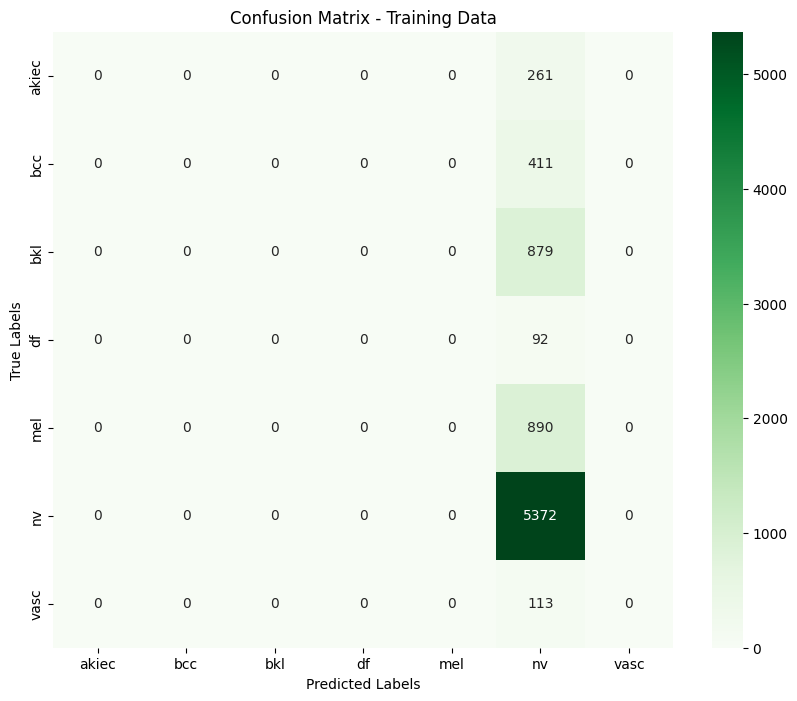

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.00      0.00      0.00       411
         bkl       0.00      0.00      0.00       879
          df       0.00      0.00      0.00        92
         mel       0.00      0.00      0.00       890
          nv       0.67      1.00      0.80      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.67      8018
   macro avg       0.10      0.14      0.11      8018
weighted avg       0.45      0.67      0.54      8018

126/126 [==============================] - 20s 160ms/step


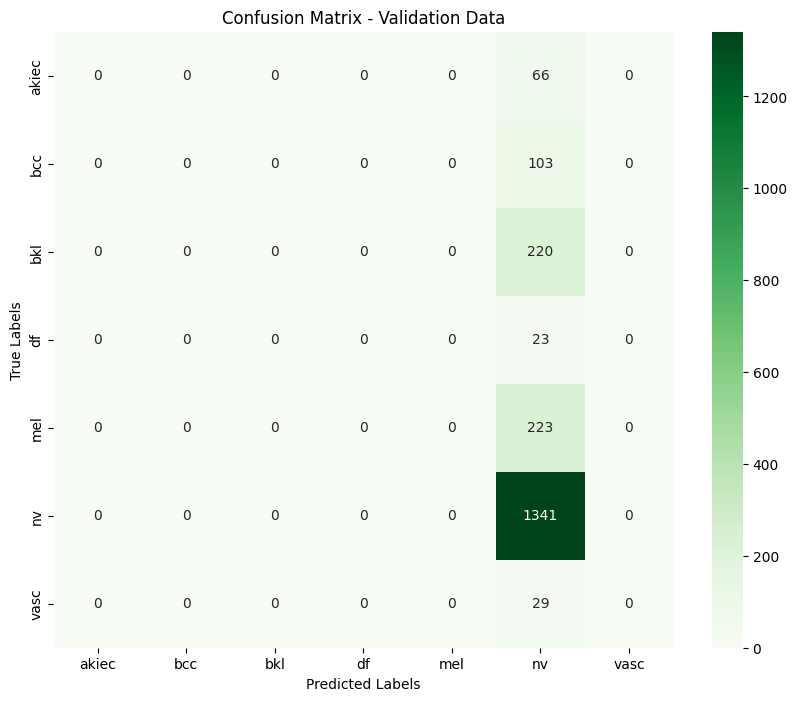

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
          nv       0.67      1.00      0.80      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.10      0.14      0.11      2005
weighted avg       0.45      0.67      0.54      2005



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

95/95 [==============================] - 20s 213ms/step


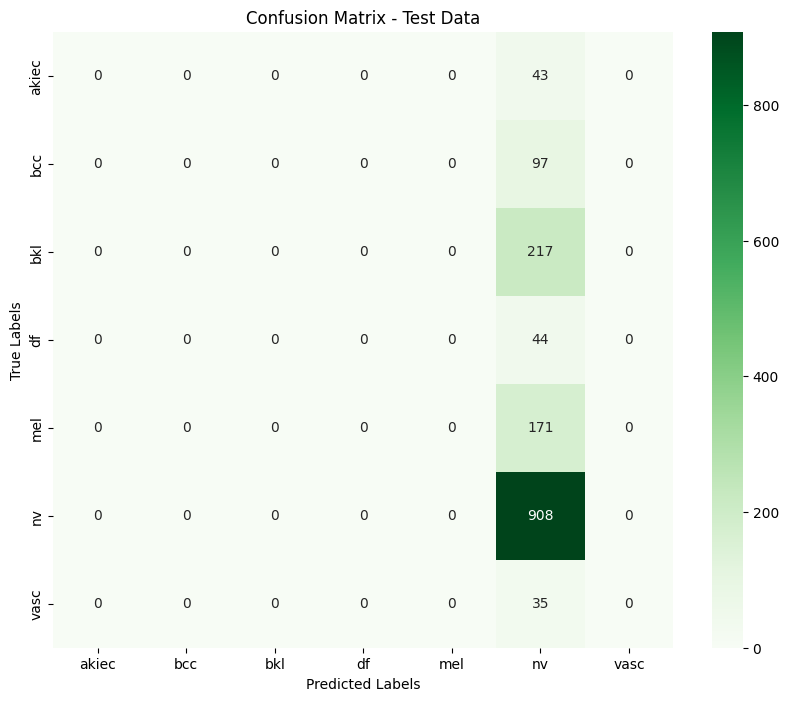

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00        97
         bkl       0.00      0.00      0.00       217
          df       0.00      0.00      0.00        44
         mel       0.00      0.00      0.00       171
          nv       0.60      1.00      0.75       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.60      1515
   macro avg       0.09      0.14      0.11      1515
weighted avg       0.36      0.60      0.45      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldV3.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = True
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True
x = base_model.output
# Add custom layers on top of the base model without L2 regularization
x = Dropout(0.8)(x)
x = Dropout(0.8)(x)
x = Dropout(0.8)(x)
x = Dropout(0.8)(x)

x = Dropout(0.8)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers without L2 regularization
#x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)
#x = Flatten()(x)
#x = Dense(64, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.8)(x)
# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'Xception.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Found 8018 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 299, 224, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 299, 224, 32  128        ['

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 440s - loss: 2.5480 - acc: 0.6228 - val_loss: 1.8362 - val_acc: 0.6688 - lr: 1.0000e-04 - 440s/epoch - 877ms/step
Epoch 2/1000
126/126 [==============================] - 20s 155ms/step
Epoch 2 - Validation Loss: 1.7290, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 2: val_loss improved from 1.83620 to 1.72897, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.7855 - acc: 0.6684 - val_loss: 1.7290 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 847ms/step
Epoch 3/1000
126/126 [==============================] - 20s 155ms/step
Epoch 3 - Validation Loss: 1.6254, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 3: val_loss improved from 1.72897 to 1.62540, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 426s - loss: 1.6878 - acc: 0.6696 - val_loss: 1.6254 - val_acc: 0.6688 - lr: 1.0000e-04 - 426s/epoch - 849ms/step
Epoch 4/1000
126/126 [==============================] - 20s 155ms/step
Epoch 4 - Validation Loss: 1.5225, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 4: val_loss improved from 1.62540 to 1.52253, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 426s - loss: 1.5896 - acc: 0.6700 - val_loss: 1.5225 - val_acc: 0.6688 - lr: 1.0000e-04 - 426s/epoch - 849ms/step
Epoch 5/1000
126/126 [==============================] - 19s 155ms/step
Epoch 5 - Validation Loss: 1.4272, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 5: val_loss improved from 1.52253 to 1.42719, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.5001 - acc: 0.6700 - val_loss: 1.4272 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 6/1000
126/126 [==============================] - 19s 155ms/step
Epoch 6 - Validation Loss: 1.3440, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 6: val_loss improved from 1.42719 to 1.34398, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.4290 - acc: 0.6699 - val_loss: 1.3440 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 7/1000
126/126 [==============================] - 19s 155ms/step
Epoch 7 - Validation Loss: 1.2788, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 7: val_loss improved from 1.34398 to 1.27878, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.3738 - acc: 0.6697 - val_loss: 1.2788 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 844ms/step
Epoch 8/1000
126/126 [==============================] - 19s 155ms/step
Epoch 8 - Validation Loss: 1.2328, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 8: val_loss improved from 1.27878 to 1.23276, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.3258 - acc: 0.6700 - val_loss: 1.2328 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 9/1000
126/126 [==============================] - 19s 155ms/step
Epoch 9 - Validation Loss: 1.2033, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 9: val_loss improved from 1.23276 to 1.20327, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.3045 - acc: 0.6700 - val_loss: 1.2033 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 10/1000
126/126 [==============================] - 19s 155ms/step
Epoch 10 - Validation Loss: 1.1840, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 10: val_loss improved from 1.20327 to 1.18403, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.2911 - acc: 0.6700 - val_loss: 1.1840 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 11/1000
126/126 [==============================] - 19s 155ms/step
Epoch 11 - Validation Loss: 1.1735, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 11: val_loss improved from 1.18403 to 1.17346, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.2785 - acc: 0.6700 - val_loss: 1.1735 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 12/1000
126/126 [==============================] - 19s 155ms/step
Epoch 12 - Validation Loss: 1.1651, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 12: val_loss improved from 1.17346 to 1.16509, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.2665 - acc: 0.6700 - val_loss: 1.1651 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 13/1000
126/126 [==============================] - 19s 155ms/step
Epoch 13 - Validation Loss: 1.1590, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 13: val_loss improved from 1.16509 to 1.15901, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.2532 - acc: 0.6700 - val_loss: 1.1590 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 14/1000
126/126 [==============================] - 19s 155ms/step
Epoch 14 - Validation Loss: 1.1537, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 14: val_loss improved from 1.15901 to 1.15374, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.2386 - acc: 0.6700 - val_loss: 1.1537 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 844ms/step
Epoch 15/1000
126/126 [==============================] - 19s 155ms/step
Epoch 15 - Validation Loss: 1.1506, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 15: val_loss improved from 1.15374 to 1.15059, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.2416 - acc: 0.6700 - val_loss: 1.1506 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 16/1000
126/126 [==============================] - 19s 155ms/step
Epoch 16 - Validation Loss: 1.1484, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 16: val_loss improved from 1.15059 to 1.14837, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.2347 - acc: 0.6700 - val_loss: 1.1484 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 17/1000
126/126 [==============================] - 19s 155ms/step
Epoch 17 - Validation Loss: 1.1467, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 17: val_loss improved from 1.14837 to 1.14668, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.2247 - acc: 0.6700 - val_loss: 1.1467 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 847ms/step
Epoch 18/1000
126/126 [==============================] - 19s 155ms/step
Epoch 18 - Validation Loss: 1.1448, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 18: val_loss improved from 1.14668 to 1.14477, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 423s - loss: 1.2211 - acc: 0.6700 - val_loss: 1.1448 - val_acc: 0.6688 - lr: 1.0000e-04 - 423s/epoch - 844ms/step
Epoch 19/1000
126/126 [==============================] - 19s 155ms/step
Epoch 19 - Validation Loss: 1.1443, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 19: val_loss improved from 1.14477 to 1.14429, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.2248 - acc: 0.6700 - val_loss: 1.1443 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 847ms/step
Epoch 20/1000
126/126 [==============================] - 19s 155ms/step
Epoch 20 - Validation Loss: 1.1431, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 20: val_loss improved from 1.14429 to 1.14314, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.2058 - acc: 0.6700 - val_loss: 1.1431 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 21/1000
126/126 [==============================] - 19s 155ms/step
Epoch 21 - Validation Loss: 1.1415, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 21: val_loss improved from 1.14314 to 1.14153, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 426s - loss: 1.1997 - acc: 0.6700 - val_loss: 1.1415 - val_acc: 0.6688 - lr: 1.0000e-04 - 426s/epoch - 848ms/step
Epoch 22/1000
126/126 [==============================] - 19s 155ms/step
Epoch 22 - Validation Loss: 1.1411, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 22: val_loss improved from 1.14153 to 1.14107, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.2066 - acc: 0.6700 - val_loss: 1.1411 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 844ms/step
Epoch 23/1000
126/126 [==============================] - 19s 155ms/step
Epoch 23 - Validation Loss: 1.1402, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 23: val_loss improved from 1.14107 to 1.14022, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1968 - acc: 0.6700 - val_loss: 1.1402 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 24/1000
126/126 [==============================] - 19s 155ms/step
Epoch 24 - Validation Loss: 1.1398, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 24: val_loss improved from 1.14022 to 1.13977, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1975 - acc: 0.6699 - val_loss: 1.1398 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 25/1000
126/126 [==============================] - 19s 155ms/step
Epoch 25 - Validation Loss: 1.1392, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 25: val_loss improved from 1.13977 to 1.13922, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.1922 - acc: 0.6700 - val_loss: 1.1392 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 847ms/step
Epoch 26/1000
126/126 [==============================] - 20s 155ms/step
Epoch 26 - Validation Loss: 1.1390, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 26: val_loss improved from 1.13922 to 1.13905, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.1941 - acc: 0.6700 - val_loss: 1.1390 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 847ms/step
Epoch 27/1000
126/126 [==============================] - 19s 155ms/step
Epoch 27 - Validation Loss: 1.1385, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 27: val_loss improved from 1.13905 to 1.13854, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1853 - acc: 0.6700 - val_loss: 1.1385 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 28/1000
126/126 [==============================] - 19s 155ms/step
Epoch 28 - Validation Loss: 1.1384, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 28: val_loss improved from 1.13854 to 1.13838, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.1858 - acc: 0.6700 - val_loss: 1.1384 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 847ms/step
Epoch 29/1000
126/126 [==============================] - 19s 155ms/step
Epoch 29 - Validation Loss: 1.1378, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 29: val_loss improved from 1.13838 to 1.13776, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1768 - acc: 0.6700 - val_loss: 1.1378 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 30/1000
126/126 [==============================] - 19s 155ms/step
Epoch 30 - Validation Loss: 1.1373, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 30: val_loss improved from 1.13776 to 1.13733, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1764 - acc: 0.6700 - val_loss: 1.1373 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 31/1000
126/126 [==============================] - 19s 155ms/step
Epoch 31 - Validation Loss: 1.1369, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 31: val_loss improved from 1.13733 to 1.13687, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1682 - acc: 0.6700 - val_loss: 1.1369 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 32/1000
126/126 [==============================] - 19s 155ms/step
Epoch 32 - Validation Loss: 1.1368, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 32: val_loss improved from 1.13687 to 1.13680, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.1779 - acc: 0.6700 - val_loss: 1.1368 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 33/1000
126/126 [==============================] - 19s 155ms/step
Epoch 33 - Validation Loss: 1.1368, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 33: val_loss did not improve from 1.13680
502/502 - 425s - loss: 1.1746 - acc: 0.6700 - val_loss: 1.1368 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 155ms/step
Epoch 34 - Validation Loss: 1.1368, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 34: val_loss improved from 1.13680 to 1.13679, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.1728 - acc: 0.6700 - val_loss: 1.1368 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 847ms/step
Epoch 35/1000
126/126 [==============================] - 19s 155ms/step
Epoch 35 - Validation Loss: 1.1365, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 35: val_loss improved from 1.13679 to 1.13648, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.1650 - acc: 0.6700 - val_loss: 1.1365 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 36/1000
126/126 [==============================] - 19s 155ms/step
Epoch 36 - Validation Loss: 1.1363, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 36: val_loss improved from 1.13648 to 1.13630, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1646 - acc: 0.6700 - val_loss: 1.1363 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 844ms/step
Epoch 37/1000
126/126 [==============================] - 19s 155ms/step
Epoch 37 - Validation Loss: 1.1360, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 37: val_loss improved from 1.13630 to 1.13601, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1629 - acc: 0.6700 - val_loss: 1.1360 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 38/1000
126/126 [==============================] - 20s 155ms/step
Epoch 38 - Validation Loss: 1.1359, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 38: val_loss improved from 1.13601 to 1.13589, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 425s - loss: 1.1633 - acc: 0.6700 - val_loss: 1.1359 - val_acc: 0.6688 - lr: 1.0000e-04 - 425s/epoch - 846ms/step
Epoch 39/1000
126/126 [==============================] - 20s 156ms/step
Epoch 39 - Validation Loss: 1.1355, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 39: val_loss improved from 1.13589 to 1.13551, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 423s - loss: 1.1555 - acc: 0.6700 - val_loss: 1.1355 - val_acc: 0.6688 - lr: 1.0000e-04 - 423s/epoch - 844ms/step
Epoch 40/1000
126/126 [==============================] - 20s 156ms/step
Epoch 40 - Validation Loss: 1.1355, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 40: val_loss did not improve from 1.13551
502/502 - 427s - loss: 1.1584 - acc: 0.6700 - val_loss: 1.1355 - val_acc: 0.6688 - lr: 1.0000e-04 - 427s/epoch - 851ms/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 159ms/step
Epoch 41 - Validation Loss: 1.1353, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 41: val_loss improved from 1.13551 to 1.13527, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 426s - loss: 1.1529 - acc: 0.6700 - val_loss: 1.1353 - val_acc: 0.6688 - lr: 1.0000e-04 - 426s/epoch - 848ms/step
Epoch 42/1000
126/126 [==============================] - 20s 155ms/step
Epoch 42 - Validation Loss: 1.1354, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 42: val_loss did not improve from 1.13527
502/502 - 427s - loss: 1.1583 - acc: 0.6700 - val_loss: 1.1354 - val_acc: 0.6688 - lr: 1.0000e-04 - 427s/epoch - 850ms/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 154ms/step
Epoch 43 - Validation Loss: 1.1354, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 43: val_loss did not improve from 1.13527
502/502 - 422s - loss: 1.1589 - acc: 0.6700 - val_loss: 1.1354 - val_acc: 0.6688 - lr: 1.0000e-04 - 422s/epoch - 840ms/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 156ms/step
Epoch 44 - Validation Loss: 1.1354, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 44: val_loss did not improve from 1.13527
502/502 - 421s - loss: 1.1564 - acc: 0.6700 - val_loss: 1.1354 - val_acc: 0.6688 - lr: 1.0000e-04 - 421s/epoch - 839ms/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 156ms/step
Epoch 45 - Validation Loss: 1.1353, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 45: val_loss did not improve from 1.13527
502/502 - 423s - loss: 1.1547 - acc: 0.6700 - val_loss: 1.1353 - val_acc: 0.6688 - lr: 1.0000e-04 - 423s/epoch - 842ms/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 154ms/step
Epoch 46 - Validation Loss: 1.1351, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 46: val_loss improved from 1.13527 to 1.13512, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1495 - acc: 0.6700 - val_loss: 1.1351 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 47/1000
126/126 [==============================] - 19s 154ms/step
Epoch 47 - Validation Loss: 1.1351, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 47: val_loss improved from 1.13512 to 1.13505, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 420s - loss: 1.1535 - acc: 0.6700 - val_loss: 1.1351 - val_acc: 0.6688 - lr: 1.0000e-04 - 420s/epoch - 837ms/step
Epoch 48/1000
126/126 [==============================] - 20s 156ms/step
Epoch 48 - Validation Loss: 1.1350, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 48: val_loss improved from 1.13505 to 1.13500, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 432s - loss: 1.1523 - acc: 0.6700 - val_loss: 1.1350 - val_acc: 0.6688 - lr: 1.0000e-04 - 432s/epoch - 860ms/step
Epoch 49/1000
126/126 [==============================] - 19s 154ms/step
Epoch 49 - Validation Loss: 1.1349, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 49: val_loss improved from 1.13500 to 1.13490, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 428s - loss: 1.1492 - acc: 0.6700 - val_loss: 1.1349 - val_acc: 0.6688 - lr: 1.0000e-04 - 428s/epoch - 853ms/step
Epoch 50/1000
126/126 [==============================] - 20s 156ms/step
Epoch 50 - Validation Loss: 1.1348, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 50: val_loss improved from 1.13490 to 1.13481, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 431s - loss: 1.1493 - acc: 0.6700 - val_loss: 1.1348 - val_acc: 0.6688 - lr: 1.0000e-04 - 431s/epoch - 859ms/step
Epoch 51/1000
126/126 [==============================] - 20s 160ms/step
Epoch 51 - Validation Loss: 1.1349, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 51: val_loss did not improve from 1.13481
502/502 - 436s - loss: 1.1518 - acc: 0.6700 - val_loss: 1.1349 - val_acc: 0.6688 - lr: 1.0000e-04 - 436s/epoch - 869ms/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 160ms/step
Epoch 52 - Validation Loss: 1.1347, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 52: val_loss improved from 1.13481 to 1.13472, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 433s - loss: 1.1468 - acc: 0.6700 - val_loss: 1.1347 - val_acc: 0.6688 - lr: 1.0000e-04 - 433s/epoch - 862ms/step
Epoch 53/1000
126/126 [==============================] - 25s 199ms/step
Epoch 53 - Validation Loss: 1.1346, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 53: val_loss improved from 1.13472 to 1.13458, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 442s - loss: 1.1446 - acc: 0.6700 - val_loss: 1.1346 - val_acc: 0.6688 - lr: 1.0000e-04 - 442s/epoch - 880ms/step
Epoch 54/1000
126/126 [==============================] - 19s 154ms/step
Epoch 54 - Validation Loss: 1.1345, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 54: val_loss improved from 1.13458 to 1.13450, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 427s - loss: 1.1467 - acc: 0.6700 - val_loss: 1.1345 - val_acc: 0.6688 - lr: 1.0000e-04 - 427s/epoch - 851ms/step
Epoch 55/1000
126/126 [==============================] - 20s 155ms/step
Epoch 55 - Validation Loss: 1.1345, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 55: val_loss improved from 1.13450 to 1.13449, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 423s - loss: 1.1457 - acc: 0.6700 - val_loss: 1.1345 - val_acc: 0.6688 - lr: 1.0000e-04 - 423s/epoch - 843ms/step
Epoch 56/1000
126/126 [==============================] - 19s 154ms/step
Epoch 56 - Validation Loss: 1.1345, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 56: val_loss improved from 1.13449 to 1.13447, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 424s - loss: 1.1430 - acc: 0.6700 - val_loss: 1.1345 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 845ms/step
Epoch 57/1000
126/126 [==============================] - 19s 154ms/step
Epoch 57 - Validation Loss: 1.1345, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 57: val_loss did not improve from 1.13447
502/502 - 426s - loss: 1.1476 - acc: 0.6700 - val_loss: 1.1345 - val_acc: 0.6688 - lr: 1.0000e-04 - 426s/epoch - 848ms/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 155ms/step
Epoch 58 - Validation Loss: 1.1344, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 58: val_loss improved from 1.13447 to 1.13438, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 426s - loss: 1.1422 - acc: 0.6700 - val_loss: 1.1344 - val_acc: 0.6688 - lr: 1.0000e-04 - 426s/epoch - 848ms/step
Epoch 59/1000
126/126 [==============================] - 20s 157ms/step
Epoch 59 - Validation Loss: 1.1343, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 59: val_loss improved from 1.13438 to 1.13426, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 426s - loss: 1.1435 - acc: 0.6700 - val_loss: 1.1343 - val_acc: 0.6688 - lr: 1.0000e-04 - 426s/epoch - 848ms/step
Epoch 60/1000
126/126 [==============================] - 19s 154ms/step
Epoch 60 - Validation Loss: 1.1342, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 60: val_loss improved from 1.13426 to 1.13420, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 420s - loss: 1.1427 - acc: 0.6700 - val_loss: 1.1342 - val_acc: 0.6688 - lr: 1.0000e-04 - 420s/epoch - 836ms/step
Epoch 61/1000
126/126 [==============================] - 19s 155ms/step
Epoch 61 - Validation Loss: 1.1342, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 61: val_loss improved from 1.13420 to 1.13417, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 429s - loss: 1.1417 - acc: 0.6700 - val_loss: 1.1342 - val_acc: 0.6688 - lr: 1.0000e-04 - 429s/epoch - 854ms/step
Epoch 62/1000
126/126 [==============================] - 19s 154ms/step
Epoch 62 - Validation Loss: 1.1341, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 62: val_loss improved from 1.13417 to 1.13411, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 423s - loss: 1.1397 - acc: 0.6700 - val_loss: 1.1341 - val_acc: 0.6688 - lr: 1.0000e-04 - 423s/epoch - 842ms/step
Epoch 63/1000
126/126 [==============================] - 19s 154ms/step
Epoch 63 - Validation Loss: 1.1341, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 63: val_loss did not improve from 1.13411
502/502 - 418s - loss: 1.1421 - acc: 0.6700 - val_loss: 1.1341 - val_acc: 0.6688 - lr: 1.0000e-04 - 418s/epoch - 833ms/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 154ms/step
Epoch 64 - Validation Loss: 1.1341, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 64: val_loss did not improve from 1.13411
502/502 - 419s - loss: 1.1405 - acc: 0.6700 - val_loss: 1.1341 - val_acc: 0.6688 - lr: 1.0000e-04 - 419s/epoch - 834ms/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 156ms/step
Epoch 65 - Validation Loss: 1.1341, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 65: val_loss did not improve from 1.13411
502/502 - 422s - loss: 1.1421 - acc: 0.6700 - val_loss: 1.1341 - val_acc: 0.6688 - lr: 1.0000e-04 - 422s/epoch - 841ms/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 154ms/step
Epoch 66 - Validation Loss: 1.1341, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 66: val_loss improved from 1.13411 to 1.13406, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 423s - loss: 1.1391 - acc: 0.6700 - val_loss: 1.1341 - val_acc: 0.6688 - lr: 1.0000e-04 - 423s/epoch - 843ms/step
Epoch 67/1000
126/126 [==============================] - 19s 154ms/step
Epoch 67 - Validation Loss: 1.1340, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 67: val_loss improved from 1.13406 to 1.13399, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 421s - loss: 1.1376 - acc: 0.6700 - val_loss: 1.1340 - val_acc: 0.6688 - lr: 1.0000e-04 - 421s/epoch - 839ms/step
Epoch 68/1000
126/126 [==============================] - 20s 155ms/step
Epoch 68 - Validation Loss: 1.1340, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 68: val_loss did not improve from 1.13399
502/502 - 421s - loss: 1.1403 - acc: 0.6700 - val_loss: 1.1340 - val_acc: 0.6688 - lr: 1.0000e-04 - 421s/epoch - 839ms/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 155ms/step
Epoch 69 - Validation Loss: 1.1340, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 69: val_loss did not improve from 1.13399
502/502 - 423s - loss: 1.1407 - acc: 0.6700 - val_loss: 1.1340 - val_acc: 0.6688 - lr: 1.0000e-04 - 423s/epoch - 843ms/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 156ms/step
Epoch 70 - Validation Loss: 1.1339, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 70: val_loss improved from 1.13399 to 1.13393, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 421s - loss: 1.1376 - acc: 0.6700 - val_loss: 1.1339 - val_acc: 0.6688 - lr: 1.0000e-04 - 421s/epoch - 838ms/step
Epoch 71/1000
126/126 [==============================] - 19s 154ms/step
Epoch 71 - Validation Loss: 1.1339, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 71: val_loss improved from 1.13393 to 1.13388, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 420s - loss: 1.1370 - acc: 0.6700 - val_loss: 1.1339 - val_acc: 0.6688 - lr: 1.0000e-04 - 420s/epoch - 836ms/step
Epoch 72/1000
126/126 [==============================] - 19s 154ms/step
Epoch 72 - Validation Loss: 1.1338, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 72: val_loss improved from 1.13388 to 1.13384, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 419s - loss: 1.1362 - acc: 0.6700 - val_loss: 1.1338 - val_acc: 0.6688 - lr: 1.0000e-04 - 419s/epoch - 835ms/step
Epoch 73/1000
126/126 [==============================] - 19s 154ms/step
Epoch 73 - Validation Loss: 1.1338, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 73: val_loss improved from 1.13384 to 1.13382, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 421s - loss: 1.1381 - acc: 0.6700 - val_loss: 1.1338 - val_acc: 0.6688 - lr: 1.0000e-04 - 421s/epoch - 839ms/step
Epoch 74/1000
126/126 [==============================] - 19s 154ms/step
Epoch 74 - Validation Loss: 1.1338, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 74: val_loss improved from 1.13382 to 1.13381, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 419s - loss: 1.1373 - acc: 0.6700 - val_loss: 1.1338 - val_acc: 0.6688 - lr: 1.0000e-04 - 419s/epoch - 835ms/step
Epoch 75/1000
126/126 [==============================] - 19s 154ms/step
Epoch 75 - Validation Loss: 1.1337, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 75: val_loss improved from 1.13381 to 1.13375, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 419s - loss: 1.1353 - acc: 0.6700 - val_loss: 1.1337 - val_acc: 0.6688 - lr: 1.0000e-04 - 419s/epoch - 835ms/step
Epoch 76/1000
126/126 [==============================] - 19s 154ms/step
Epoch 76 - Validation Loss: 1.1338, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 76: val_loss did not improve from 1.13375
502/502 - 419s - loss: 1.1372 - acc: 0.6700 - val_loss: 1.1338 - val_acc: 0.6688 - lr: 1.0000e-04 - 419s/epoch - 835ms/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 154ms/step
Epoch 77 - Validation Loss: 1.1337, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 77: val_loss improved from 1.13375 to 1.13375, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 419s - loss: 1.1360 - acc: 0.6700 - val_loss: 1.1337 - val_acc: 0.6688 - lr: 1.0000e-04 - 419s/epoch - 835ms/step
Epoch 78/1000
126/126 [==============================] - 19s 154ms/step
Epoch 78 - Validation Loss: 1.1338, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 78: val_loss did not improve from 1.13375
502/502 - 419s - loss: 1.1367 - acc: 0.6700 - val_loss: 1.1338 - val_acc: 0.6688 - lr: 1.0000e-04 - 419s/epoch - 834ms/step
Epoch 79/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 154ms/step
Epoch 79 - Validation Loss: 1.1337, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 79: val_loss improved from 1.13375 to 1.13373, saving model to Xception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 419s - loss: 1.1361 - acc: 0.6700 - val_loss: 1.1337 - val_acc: 0.6688 - lr: 1.0000e-04 - 419s/epoch - 835ms/step
Epoch 80/1000
126/126 [==============================] - 19s 154ms/step
Epoch 80 - Validation Loss: 1.1338, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 80: val_loss did not improve from 1.13373
502/502 - 424s - loss: 1.1378 - acc: 0.6700 - val_loss: 1.1338 - val_acc: 0.6688 - lr: 1.0000e-04 - 424s/epoch - 846ms/step
Epoch 81/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 20s 155ms/step
Epoch 81 - Validation Loss: 1.1338, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 81: val_loss did not improve from 1.13373
502/502 - 421s - loss: 1.1368 - acc: 0.6700 - val_loss: 1.1338 - val_acc: 0.6688 - lr: 5.0000e-05 - 421s/epoch - 840ms/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 154ms/step
Epoch 82 - Validation Loss: 1.1337, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 82: val_loss did not improve from 1.13373
502/502 - 425s - loss: 1.1336 - acc: 0.6700 - val_loss: 1.1337 - val_acc: 0.6688 - lr: 5.0000e-05 - 425s/epoch - 847ms/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 155ms/step
Epoch 83 - Validation Loss: 1.1337, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 83: val_loss did not improve from 1.13373
502/502 - 422s - loss: 1.1363 - acc: 0.6700 - val_loss: 1.1337 - val_acc: 0.6688 - lr: 5.0000e-05 - 422s/epoch - 840ms/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 155ms/step
Epoch 84 - Validation Loss: 1.1338, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 84: val_loss did not improve from 1.13373
502/502 - 421s - loss: 1.1374 - acc: 0.6700 - val_loss: 1.1338 - val_acc: 0.6688 - lr: 5.0000e-05 - 421s/epoch - 839ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 299, 224, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 299, 224, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train accuracy: 0.6699925168371165
Train Precision: 0.44888997261773383
Train Recall: 0.6699925168371165
Train F1 Score: 0.5375951905076908
126/126 [==============================] - 19s 154ms/step
Val accuracy: 0.6688279301745635
Val Precision: 0.4473308001815909
Val Recall: 0.6688279301745635
Val F1 Score: 0.5361017659080035


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 19s 205ms/step
Test Accuracy: 0.5993399339933994
Test Precision: 0.35920835647921234
Test Recall: 0.5993399339933994
Test F1 Score: 0.44919575738011275


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 274s 545ms/step


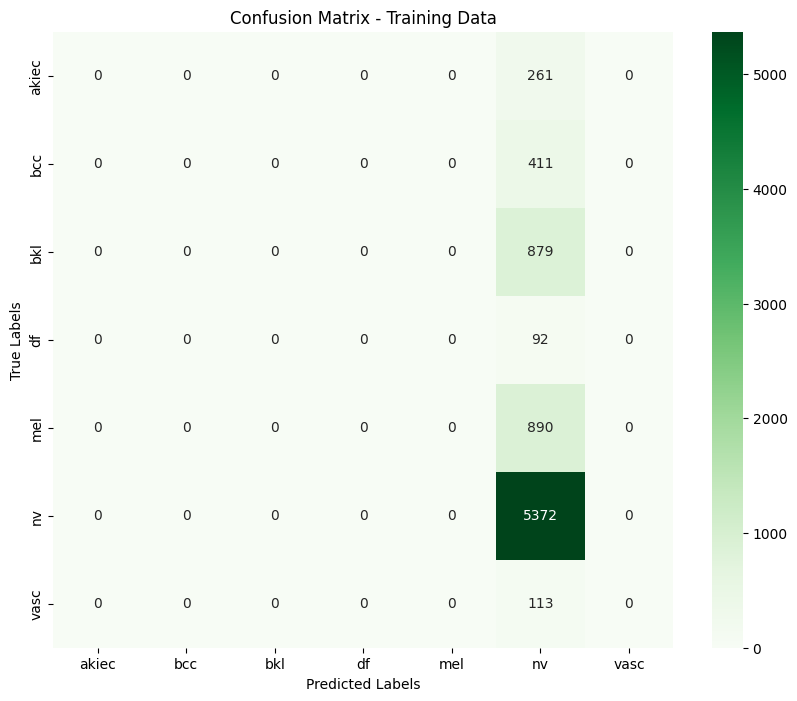

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.00      0.00      0.00       411
         bkl       0.00      0.00      0.00       879
          df       0.00      0.00      0.00        92
         mel       0.00      0.00      0.00       890
          nv       0.67      1.00      0.80      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.67      8018
   macro avg       0.10      0.14      0.11      8018
weighted avg       0.45      0.67      0.54      8018

126/126 [==============================] - 19s 153ms/step


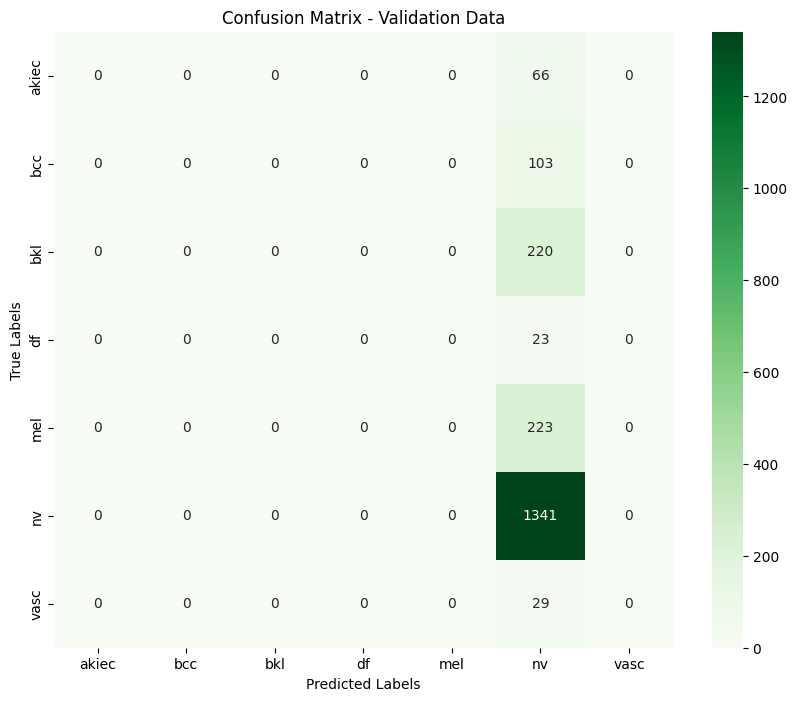

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
          nv       0.67      1.00      0.80      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.10      0.14      0.11      2005
weighted avg       0.45      0.67      0.54      2005

95/95 [==============================] - 15s 154ms/step


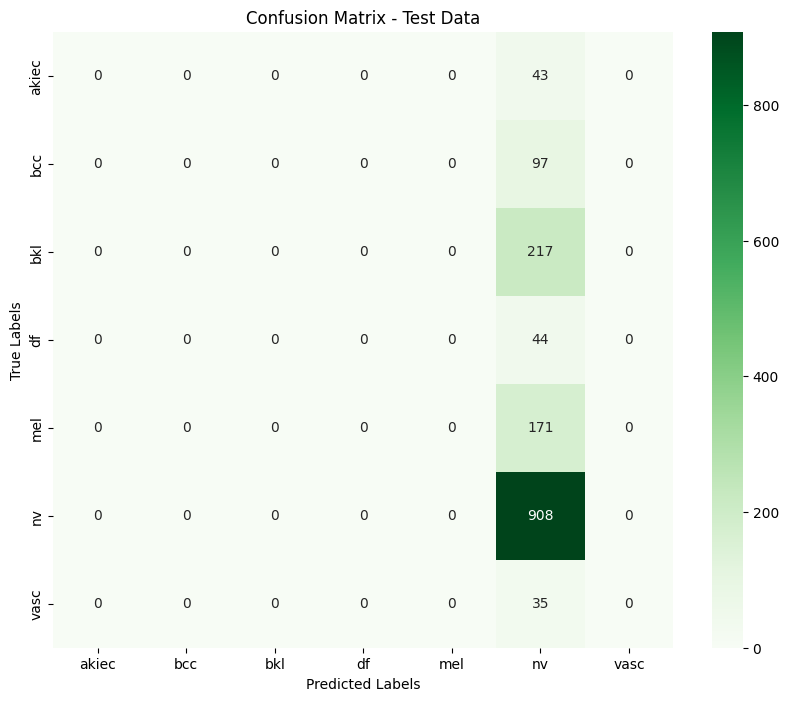

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00        97
         bkl       0.00      0.00      0.00       217
          df       0.00      0.00      0.00        44
         mel       0.00      0.00      0.00       171
          nv       0.60      1.00      0.75       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.60      1515
   macro avg       0.09      0.14      0.11      1515
weighted avg       0.36      0.60      0.45      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('Xception.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

y_true = train_generator.classes
y_pred = model.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Train accuracy:', accuracy)
print('Train Precision:', precision)
print('Train Recall:', recall)
print('Train F1 Score:', f1_score)

y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Val accuracy:', accuracy)
print('Val Precision:', precision)
print('Val Recall:', recall)
print('Val F1 Score:', f1_score)

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)



from sklearn.metrics import classification_report
# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')



In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
        ## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.8)(x)
    x = Dropout(0.8)(x)
    x = Dropout(0.8)(x)
    x = Dropout(0.8)(x)
    
    x = Dropout(0.8)(x)
    x = GlobalAveragePooling2D()(x)

# Add Dense layers without L2 regularization
#x = Dense(128, activation='relu')(x)
    x = Dropout(0.8)(x)
#x = Flatten()(x)
#x = Dense(64, activation='relu')(x)
    x = Dropout(0.8)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.8)(x)
# Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldV3.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 16s 154ms/step
Epoch 1 - Validation Loss: 1.8692, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.86917, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 343s - loss: 2.7434 - acc: 0.6065 - val_loss: 1.8692 - val_acc: 0.6696 - lr: 1.0000e-04 - 343s/epoch - 855ms/step
Epoch 2/1000
101/101 [==============================] - 16s 154ms/step
Epoch 2 - Validation Loss: 1.7960, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.86917 to 1.79602, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.8341 - acc: 0.6693 - val_loss: 1.7960 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 843ms/step
Epoch 3/1000
101/101 [==============================] - 16s 154ms/step
Epoch 3 - Validation Loss: 1.7251, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.79602 to 1.72507, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.7676 - acc: 0.6688 - val_loss: 1.7251 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 845ms/step
Epoch 4/1000
101/101 [==============================] - 16s 154ms/step
Epoch 4 - Validation Loss: 1.6531, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss improved from 1.72507 to 1.65314, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.6969 - acc: 0.6699 - val_loss: 1.6531 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 845ms/step
Epoch 5/1000
101/101 [==============================] - 16s 155ms/step
Epoch 5 - Validation Loss: 1.5808, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss improved from 1.65314 to 1.58082, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.6321 - acc: 0.6699 - val_loss: 1.5808 - val_acc: 0.6696 - lr: 1.0000e-04 - 341s/epoch - 850ms/step
Epoch 6/1000
101/101 [==============================] - 16s 156ms/step
Epoch 6 - Validation Loss: 1.5088, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 6: val_loss improved from 1.58082 to 1.50880, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.5704 - acc: 0.6701 - val_loss: 1.5088 - val_acc: 0.6696 - lr: 1.0000e-04 - 341s/epoch - 850ms/step
Epoch 7/1000
101/101 [==============================] - 16s 156ms/step
Epoch 7 - Validation Loss: 1.4398, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 7: val_loss improved from 1.50880 to 1.43976, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.5090 - acc: 0.6701 - val_loss: 1.4398 - val_acc: 0.6696 - lr: 1.0000e-04 - 341s/epoch - 851ms/step
Epoch 8/1000
101/101 [==============================] - 16s 155ms/step
Epoch 8 - Validation Loss: 1.3758, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 8: val_loss improved from 1.43976 to 1.37579, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.4489 - acc: 0.6701 - val_loss: 1.3758 - val_acc: 0.6696 - lr: 1.0000e-04 - 341s/epoch - 850ms/step
Epoch 9/1000
101/101 [==============================] - 16s 155ms/step
Epoch 9 - Validation Loss: 1.3224, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 9: val_loss improved from 1.37579 to 1.32244, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.4051 - acc: 0.6701 - val_loss: 1.3224 - val_acc: 0.6696 - lr: 1.0000e-04 - 341s/epoch - 849ms/step
Epoch 10/1000
101/101 [==============================] - 16s 155ms/step
Epoch 10 - Validation Loss: 1.2796, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 10: val_loss improved from 1.32244 to 1.27960, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.3698 - acc: 0.6701 - val_loss: 1.2796 - val_acc: 0.6696 - lr: 1.0000e-04 - 341s/epoch - 849ms/step
Epoch 11/1000
101/101 [==============================] - 16s 155ms/step
Epoch 11 - Validation Loss: 1.2462, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 11: val_loss improved from 1.27960 to 1.24623, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.3401 - acc: 0.6701 - val_loss: 1.2462 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 849ms/step
Epoch 12/1000
101/101 [==============================] - 16s 155ms/step
Epoch 12 - Validation Loss: 1.2225, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 12: val_loss improved from 1.24623 to 1.22249, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.3233 - acc: 0.6701 - val_loss: 1.2225 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 849ms/step
Epoch 13/1000
101/101 [==============================] - 16s 155ms/step
Epoch 13 - Validation Loss: 1.2035, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 13: val_loss improved from 1.22249 to 1.20350, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.2984 - acc: 0.6701 - val_loss: 1.2035 - val_acc: 0.6696 - lr: 1.0000e-04 - 341s/epoch - 850ms/step
Epoch 14/1000
101/101 [==============================] - 15s 154ms/step
Epoch 14 - Validation Loss: 1.1911, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 14: val_loss improved from 1.20350 to 1.19115, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.2944 - acc: 0.6701 - val_loss: 1.1911 - val_acc: 0.6696 - lr: 1.0000e-04 - 341s/epoch - 850ms/step
Epoch 15/1000
101/101 [==============================] - 15s 154ms/step
Epoch 15 - Validation Loss: 1.1810, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 15: val_loss improved from 1.19115 to 1.18104, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.2800 - acc: 0.6701 - val_loss: 1.1810 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 16/1000
101/101 [==============================] - 15s 153ms/step
Epoch 16 - Validation Loss: 1.1732, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 16: val_loss improved from 1.18104 to 1.17322, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.2717 - acc: 0.6701 - val_loss: 1.1732 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 17/1000
101/101 [==============================] - 19s 190ms/step
Epoch 17 - Validation Loss: 1.1670, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 17: val_loss improved from 1.17322 to 1.16695, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 345s - loss: 1.2660 - acc: 0.6701 - val_loss: 1.1670 - val_acc: 0.6696 - lr: 1.0000e-04 - 345s/epoch - 862ms/step
Epoch 18/1000
101/101 [==============================] - 16s 161ms/step
Epoch 18 - Validation Loss: 1.1628, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 18: val_loss improved from 1.16695 to 1.16284, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 351s - loss: 1.2616 - acc: 0.6701 - val_loss: 1.1628 - val_acc: 0.6696 - lr: 1.0000e-04 - 351s/epoch - 875ms/step
Epoch 19/1000
101/101 [==============================] - 16s 158ms/step
Epoch 19 - Validation Loss: 1.1584, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 19: val_loss improved from 1.16284 to 1.15841, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 349s - loss: 1.2390 - acc: 0.6701 - val_loss: 1.1584 - val_acc: 0.6696 - lr: 1.0000e-04 - 349s/epoch - 870ms/step
Epoch 20/1000
101/101 [==============================] - 16s 154ms/step
Epoch 20 - Validation Loss: 1.1553, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 20: val_loss improved from 1.15841 to 1.15534, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.2442 - acc: 0.6701 - val_loss: 1.1553 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 849ms/step
Epoch 21/1000
101/101 [==============================] - 16s 154ms/step
Epoch 21 - Validation Loss: 1.1527, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 21: val_loss improved from 1.15534 to 1.15274, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 342s - loss: 1.2403 - acc: 0.6701 - val_loss: 1.1527 - val_acc: 0.6696 - lr: 1.0000e-04 - 342s/epoch - 852ms/step
Epoch 22/1000
101/101 [==============================] - 16s 154ms/step
Epoch 22 - Validation Loss: 1.1500, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 22: val_loss improved from 1.15274 to 1.14999, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.2242 - acc: 0.6701 - val_loss: 1.1500 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 845ms/step
Epoch 23/1000
101/101 [==============================] - 16s 155ms/step
Epoch 23 - Validation Loss: 1.1483, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 23: val_loss improved from 1.14999 to 1.14833, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 342s - loss: 1.2320 - acc: 0.6701 - val_loss: 1.1483 - val_acc: 0.6696 - lr: 1.0000e-04 - 342s/epoch - 853ms/step
Epoch 24/1000
101/101 [==============================] - 16s 154ms/step
Epoch 24 - Validation Loss: 1.1467, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 24: val_loss improved from 1.14833 to 1.14672, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2205 - acc: 0.6701 - val_loss: 1.1467 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 25/1000
101/101 [==============================] - 16s 155ms/step
Epoch 25 - Validation Loss: 1.1450, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 25: val_loss improved from 1.14672 to 1.14499, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.2109 - acc: 0.6701 - val_loss: 1.1450 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 26/1000
101/101 [==============================] - 16s 154ms/step
Epoch 26 - Validation Loss: 1.1443, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 26: val_loss improved from 1.14499 to 1.14430, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2196 - acc: 0.6701 - val_loss: 1.1443 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 27/1000
101/101 [==============================] - 16s 155ms/step
Epoch 27 - Validation Loss: 1.1430, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 27: val_loss improved from 1.14430 to 1.14303, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2106 - acc: 0.6701 - val_loss: 1.1430 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 28/1000
101/101 [==============================] - 15s 153ms/step
Epoch 28 - Validation Loss: 1.1426, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 28: val_loss improved from 1.14303 to 1.14256, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.2116 - acc: 0.6701 - val_loss: 1.1426 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 839ms/step
Epoch 29/1000
101/101 [==============================] - 15s 154ms/step
Epoch 29 - Validation Loss: 1.1412, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 29: val_loss improved from 1.14256 to 1.14120, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1935 - acc: 0.6701 - val_loss: 1.1412 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 30/1000
101/101 [==============================] - 15s 153ms/step
Epoch 30 - Validation Loss: 1.1403, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 30: val_loss improved from 1.14120 to 1.14029, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1975 - acc: 0.6701 - val_loss: 1.1403 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 31/1000
101/101 [==============================] - 15s 153ms/step
Epoch 31 - Validation Loss: 1.1396, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 31: val_loss improved from 1.14029 to 1.13960, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1970 - acc: 0.6701 - val_loss: 1.1396 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 32/1000
101/101 [==============================] - 15s 154ms/step
Epoch 32 - Validation Loss: 1.1391, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 32: val_loss improved from 1.13960 to 1.13915, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1907 - acc: 0.6701 - val_loss: 1.1391 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 842ms/step
Epoch 33/1000
101/101 [==============================] - 15s 153ms/step
Epoch 33 - Validation Loss: 1.1388, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 33: val_loss improved from 1.13915 to 1.13875, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1954 - acc: 0.6701 - val_loss: 1.1388 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 34/1000
101/101 [==============================] - 15s 154ms/step
Epoch 34 - Validation Loss: 1.1382, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 34: val_loss improved from 1.13875 to 1.13822, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1870 - acc: 0.6701 - val_loss: 1.1382 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 35/1000
101/101 [==============================] - 15s 153ms/step
Epoch 35 - Validation Loss: 1.1374, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 35: val_loss improved from 1.13822 to 1.13740, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1807 - acc: 0.6701 - val_loss: 1.1374 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 36/1000
101/101 [==============================] - 15s 153ms/step
Epoch 36 - Validation Loss: 1.1372, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 36: val_loss improved from 1.13740 to 1.13718, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1850 - acc: 0.6701 - val_loss: 1.1372 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 37/1000
101/101 [==============================] - 15s 153ms/step
Epoch 37 - Validation Loss: 1.1370, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 37: val_loss improved from 1.13718 to 1.13697, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1864 - acc: 0.6701 - val_loss: 1.1370 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 38/1000
101/101 [==============================] - 15s 153ms/step
Epoch 38 - Validation Loss: 1.1370, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 38: val_loss did not improve from 1.13697
401/401 - 336s - loss: 1.1843 - acc: 0.6701 - val_loss: 1.1370 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 839ms/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 153ms/step
Epoch 39 - Validation Loss: 1.1367, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 39: val_loss improved from 1.13697 to 1.13670, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1777 - acc: 0.6701 - val_loss: 1.1367 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 40/1000
101/101 [==============================] - 15s 153ms/step
Epoch 40 - Validation Loss: 1.1364, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 40: val_loss improved from 1.13670 to 1.13636, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1720 - acc: 0.6701 - val_loss: 1.1364 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 41/1000
101/101 [==============================] - 15s 154ms/step
Epoch 41 - Validation Loss: 1.1360, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 41: val_loss improved from 1.13636 to 1.13597, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1723 - acc: 0.6701 - val_loss: 1.1360 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 42/1000
101/101 [==============================] - 15s 153ms/step
Epoch 42 - Validation Loss: 1.1358, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 42: val_loss improved from 1.13597 to 1.13575, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1693 - acc: 0.6701 - val_loss: 1.1358 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 43/1000
101/101 [==============================] - 15s 153ms/step
Epoch 43 - Validation Loss: 1.1353, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 43: val_loss improved from 1.13575 to 1.13534, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1636 - acc: 0.6701 - val_loss: 1.1353 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 44/1000
101/101 [==============================] - 15s 153ms/step
Epoch 44 - Validation Loss: 1.1351, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 44: val_loss improved from 1.13534 to 1.13511, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1698 - acc: 0.6701 - val_loss: 1.1351 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 45/1000
101/101 [==============================] - 15s 153ms/step
Epoch 45 - Validation Loss: 1.1351, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 45: val_loss improved from 1.13511 to 1.13510, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1681 - acc: 0.6701 - val_loss: 1.1351 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 843ms/step
Epoch 46/1000
101/101 [==============================] - 15s 153ms/step
Epoch 46 - Validation Loss: 1.1347, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 46: val_loss improved from 1.13510 to 1.13469, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1628 - acc: 0.6701 - val_loss: 1.1347 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 47/1000
101/101 [==============================] - 15s 153ms/step
Epoch 47 - Validation Loss: 1.1346, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 47: val_loss improved from 1.13469 to 1.13458, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1626 - acc: 0.6701 - val_loss: 1.1346 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 48/1000
101/101 [==============================] - 15s 153ms/step
Epoch 48 - Validation Loss: 1.1344, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 48: val_loss improved from 1.13458 to 1.13439, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1624 - acc: 0.6701 - val_loss: 1.1344 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 49/1000
101/101 [==============================] - 15s 153ms/step
Epoch 49 - Validation Loss: 1.1342, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 49: val_loss improved from 1.13439 to 1.13419, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1618 - acc: 0.6701 - val_loss: 1.1342 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 50/1000
101/101 [==============================] - 15s 153ms/step
Epoch 50 - Validation Loss: 1.1341, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 50: val_loss improved from 1.13419 to 1.13409, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1574 - acc: 0.6701 - val_loss: 1.1341 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 51/1000
101/101 [==============================] - 15s 153ms/step
Epoch 51 - Validation Loss: 1.1340, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 51: val_loss improved from 1.13409 to 1.13397, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1581 - acc: 0.6701 - val_loss: 1.1340 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 52/1000
101/101 [==============================] - 15s 154ms/step
Epoch 52 - Validation Loss: 1.1339, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 52: val_loss improved from 1.13397 to 1.13394, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1606 - acc: 0.6701 - val_loss: 1.1339 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 53/1000
101/101 [==============================] - 15s 153ms/step
Epoch 53 - Validation Loss: 1.1338, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 53: val_loss improved from 1.13394 to 1.13378, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1556 - acc: 0.6701 - val_loss: 1.1338 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 54/1000
101/101 [==============================] - 15s 153ms/step
Epoch 54 - Validation Loss: 1.1336, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 54: val_loss improved from 1.13378 to 1.13358, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1537 - acc: 0.6701 - val_loss: 1.1336 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 55/1000
101/101 [==============================] - 15s 153ms/step
Epoch 55 - Validation Loss: 1.1334, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 55: val_loss improved from 1.13358 to 1.13338, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1521 - acc: 0.6701 - val_loss: 1.1334 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 56/1000
101/101 [==============================] - 15s 153ms/step
Epoch 56 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 56: val_loss improved from 1.13338 to 1.13334, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1537 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 57/1000
101/101 [==============================] - 15s 154ms/step
Epoch 57 - Validation Loss: 1.1332, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 57: val_loss improved from 1.13334 to 1.13317, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1496 - acc: 0.6701 - val_loss: 1.1332 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 58/1000
101/101 [==============================] - 15s 153ms/step
Epoch 58 - Validation Loss: 1.1332, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 58: val_loss did not improve from 1.13317
401/401 - 337s - loss: 1.1553 - acc: 0.6701 - val_loss: 1.1332 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 839ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 153ms/step
Epoch 59 - Validation Loss: 1.1331, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 59: val_loss improved from 1.13317 to 1.13307, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1502 - acc: 0.6701 - val_loss: 1.1331 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 839ms/step
Epoch 60/1000
101/101 [==============================] - 15s 153ms/step
Epoch 60 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 60: val_loss improved from 1.13307 to 1.13297, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1483 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 61/1000
101/101 [==============================] - 15s 153ms/step
Epoch 61 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 61: val_loss improved from 1.13297 to 1.13290, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1478 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 62/1000
101/101 [==============================] - 15s 153ms/step
Epoch 62 - Validation Loss: 1.1328, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 62: val_loss improved from 1.13290 to 1.13281, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1467 - acc: 0.6701 - val_loss: 1.1328 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 63/1000
101/101 [==============================] - 15s 153ms/step
Epoch 63 - Validation Loss: 1.1328, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 63: val_loss improved from 1.13281 to 1.13279, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1491 - acc: 0.6701 - val_loss: 1.1328 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 64/1000
101/101 [==============================] - 15s 153ms/step
Epoch 64 - Validation Loss: 1.1327, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 64: val_loss improved from 1.13279 to 1.13274, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1473 - acc: 0.6701 - val_loss: 1.1327 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 65/1000
101/101 [==============================] - 15s 153ms/step
Epoch 65 - Validation Loss: 1.1328, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 65: val_loss did not improve from 1.13274
401/401 - 336s - loss: 1.1497 - acc: 0.6701 - val_loss: 1.1328 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 839ms/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 154ms/step
Epoch 66 - Validation Loss: 1.1328, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 66: val_loss did not improve from 1.13274
401/401 - 337s - loss: 1.1472 - acc: 0.6701 - val_loss: 1.1328 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 839ms/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 153ms/step
Epoch 67 - Validation Loss: 1.1326, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 67: val_loss improved from 1.13274 to 1.13264, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1443 - acc: 0.6701 - val_loss: 1.1326 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 68/1000
101/101 [==============================] - 15s 153ms/step
Epoch 68 - Validation Loss: 1.1325, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 68: val_loss improved from 1.13264 to 1.13253, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1441 - acc: 0.6701 - val_loss: 1.1325 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 69/1000
101/101 [==============================] - 15s 153ms/step
Epoch 69 - Validation Loss: 1.1325, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 69: val_loss improved from 1.13253 to 1.13246, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1411 - acc: 0.6701 - val_loss: 1.1325 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 70/1000
101/101 [==============================] - 15s 153ms/step
Epoch 70 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 70: val_loss improved from 1.13246 to 1.13235, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1415 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 71/1000
101/101 [==============================] - 15s 153ms/step
Epoch 71 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 71: val_loss improved from 1.13235 to 1.13234, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1435 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 72/1000
101/101 [==============================] - 15s 153ms/step
Epoch 72 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 72: val_loss improved from 1.13234 to 1.13233, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1443 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 73/1000
101/101 [==============================] - 15s 153ms/step
Epoch 73 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 73: val_loss improved from 1.13233 to 1.13227, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1420 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 74/1000
101/101 [==============================] - 15s 153ms/step
Epoch 74 - Validation Loss: 1.1322, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 74: val_loss improved from 1.13227 to 1.13217, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1407 - acc: 0.6701 - val_loss: 1.1322 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 75/1000
101/101 [==============================] - 15s 153ms/step
Epoch 75 - Validation Loss: 1.1321, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 75: val_loss improved from 1.13217 to 1.13208, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1401 - acc: 0.6701 - val_loss: 1.1321 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 76/1000
101/101 [==============================] - 15s 153ms/step
Epoch 76 - Validation Loss: 1.1321, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 76: val_loss improved from 1.13208 to 1.13208, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1403 - acc: 0.6701 - val_loss: 1.1321 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 841ms/step
Epoch 77/1000
101/101 [==============================] - 15s 153ms/step
Epoch 77 - Validation Loss: 1.1321, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 77: val_loss did not improve from 1.13208
401/401 - 336s - loss: 1.1416 - acc: 0.6701 - val_loss: 1.1321 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 839ms/step
Epoch 78/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 153ms/step
Epoch 78 - Validation Loss: 1.1320, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 78: val_loss improved from 1.13208 to 1.13205, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1399 - acc: 0.6701 - val_loss: 1.1320 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 79/1000
101/101 [==============================] - 15s 153ms/step
Epoch 79 - Validation Loss: 1.1320, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 79: val_loss improved from 1.13205 to 1.13204, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1407 - acc: 0.6701 - val_loss: 1.1320 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 80/1000
101/101 [==============================] - 15s 153ms/step
Epoch 80 - Validation Loss: 1.1321, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 80: val_loss did not improve from 1.13204
401/401 - 337s - loss: 1.1393 - acc: 0.6701 - val_loss: 1.1321 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 839ms/step
Epoch 81/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 153ms/step
Epoch 81 - Validation Loss: 1.1322, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 81: val_loss did not improve from 1.13204
401/401 - 336s - loss: 1.1432 - acc: 0.6701 - val_loss: 1.1322 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 839ms/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 153ms/step
Epoch 82 - Validation Loss: 1.1321, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 82: val_loss did not improve from 1.13204
401/401 - 337s - loss: 1.1391 - acc: 0.6701 - val_loss: 1.1321 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 840ms/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 153ms/step
Epoch 83 - Validation Loss: 1.1321, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 83: val_loss did not improve from 1.13204
401/401 - 336s - loss: 1.1416 - acc: 0.6701 - val_loss: 1.1321 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 839ms/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 153ms/step
Epoch 84 - Validation Loss: 1.1320, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 84: val_loss did not improve from 1.13204
401/401 - 337s - loss: 1.1363 - acc: 0.6701 - val_loss: 1.1320 - val_acc: 0.6696 - lr: 5.0000e-05 - 337s/epoch - 840ms/step
Fold 2
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 16s 153ms/step
Epoch 1 - Validation Loss: 1.8631, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.86306, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 2.7333 - acc: 0.6236 - val_loss: 1.8631 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 848ms/step
Epoch 2/1000
101/101 [==============================] - 15s 153ms/step
Epoch 2 - Validation Loss: 1.7832, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.86306 to 1.78324, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.8259 - acc: 0.6698 - val_loss: 1.7832 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 3/1000
101/101 [==============================] - 15s 153ms/step
Epoch 3 - Validation Loss: 1.7046, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.78324 to 1.70459, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.7518 - acc: 0.6695 - val_loss: 1.7046 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 4/1000
101/101 [==============================] - 15s 153ms/step
Epoch 4 - Validation Loss: 1.6267, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss improved from 1.70459 to 1.62672, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.6767 - acc: 0.6698 - val_loss: 1.6267 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 5/1000
101/101 [==============================] - 15s 153ms/step
Epoch 5 - Validation Loss: 1.5497, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss improved from 1.62672 to 1.54968, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.6012 - acc: 0.6701 - val_loss: 1.5497 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 6/1000
101/101 [==============================] - 15s 153ms/step
Epoch 6 - Validation Loss: 1.4777, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 6: val_loss improved from 1.54968 to 1.47772, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.5427 - acc: 0.6699 - val_loss: 1.4777 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 837ms/step
Epoch 7/1000
101/101 [==============================] - 15s 153ms/step
Epoch 7 - Validation Loss: 1.4104, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 7: val_loss improved from 1.47772 to 1.41035, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.4763 - acc: 0.6701 - val_loss: 1.4104 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 8/1000
101/101 [==============================] - 15s 153ms/step
Epoch 8 - Validation Loss: 1.3524, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 8: val_loss improved from 1.41035 to 1.35244, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.4367 - acc: 0.6701 - val_loss: 1.3524 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 9/1000
101/101 [==============================] - 15s 153ms/step
Epoch 9 - Validation Loss: 1.3045, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 9: val_loss improved from 1.35244 to 1.30453, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.3918 - acc: 0.6701 - val_loss: 1.3045 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 10/1000
101/101 [==============================] - 15s 153ms/step
Epoch 10 - Validation Loss: 1.2672, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 10: val_loss improved from 1.30453 to 1.26718, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.3618 - acc: 0.6701 - val_loss: 1.2672 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 11/1000
101/101 [==============================] - 15s 153ms/step
Epoch 11 - Validation Loss: 1.2386, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 11: val_loss improved from 1.26718 to 1.23865, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.3385 - acc: 0.6701 - val_loss: 1.2386 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 12/1000
101/101 [==============================] - 15s 153ms/step
Epoch 12 - Validation Loss: 1.2176, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 12: val_loss improved from 1.23865 to 1.21756, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.3208 - acc: 0.6701 - val_loss: 1.2176 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 13/1000
101/101 [==============================] - 15s 153ms/step
Epoch 13 - Validation Loss: 1.2002, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 13: val_loss improved from 1.21756 to 1.20018, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2997 - acc: 0.6701 - val_loss: 1.2002 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 14/1000
101/101 [==============================] - 15s 153ms/step
Epoch 14 - Validation Loss: 1.1881, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 14: val_loss improved from 1.20018 to 1.18807, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2961 - acc: 0.6701 - val_loss: 1.1881 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 15/1000
101/101 [==============================] - 15s 153ms/step
Epoch 15 - Validation Loss: 1.1790, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 15: val_loss improved from 1.18807 to 1.17904, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.2804 - acc: 0.6701 - val_loss: 1.1790 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 16/1000
101/101 [==============================] - 15s 153ms/step
Epoch 16 - Validation Loss: 1.1731, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 16: val_loss improved from 1.17904 to 1.17310, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2899 - acc: 0.6701 - val_loss: 1.1731 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 17/1000
101/101 [==============================] - 15s 153ms/step
Epoch 17 - Validation Loss: 1.1667, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 17: val_loss improved from 1.17310 to 1.16670, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.2661 - acc: 0.6701 - val_loss: 1.1667 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 837ms/step
Epoch 18/1000
101/101 [==============================] - 15s 153ms/step
Epoch 18 - Validation Loss: 1.1629, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 18: val_loss improved from 1.16670 to 1.16287, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.2686 - acc: 0.6701 - val_loss: 1.1629 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 19/1000
101/101 [==============================] - 15s 153ms/step
Epoch 19 - Validation Loss: 1.1593, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 19: val_loss improved from 1.16287 to 1.15933, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2534 - acc: 0.6701 - val_loss: 1.1593 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 20/1000
101/101 [==============================] - 15s 153ms/step
Epoch 20 - Validation Loss: 1.1568, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 20: val_loss improved from 1.15933 to 1.15675, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2533 - acc: 0.6701 - val_loss: 1.1568 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 21/1000
101/101 [==============================] - 15s 153ms/step
Epoch 21 - Validation Loss: 1.1543, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 21: val_loss improved from 1.15675 to 1.15430, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2407 - acc: 0.6701 - val_loss: 1.1543 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 22/1000
101/101 [==============================] - 15s 153ms/step
Epoch 22 - Validation Loss: 1.1515, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 22: val_loss improved from 1.15430 to 1.15151, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.2297 - acc: 0.6701 - val_loss: 1.1515 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 23/1000
101/101 [==============================] - 15s 153ms/step
Epoch 23 - Validation Loss: 1.1494, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 23: val_loss improved from 1.15151 to 1.14942, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2292 - acc: 0.6701 - val_loss: 1.1494 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 24/1000
101/101 [==============================] - 15s 153ms/step
Epoch 24 - Validation Loss: 1.1487, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 24: val_loss improved from 1.14942 to 1.14872, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2376 - acc: 0.6701 - val_loss: 1.1487 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 25/1000
101/101 [==============================] - 15s 153ms/step
Epoch 25 - Validation Loss: 1.1471, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 25: val_loss improved from 1.14872 to 1.14707, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2238 - acc: 0.6701 - val_loss: 1.1471 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 26/1000
101/101 [==============================] - 15s 154ms/step
Epoch 26 - Validation Loss: 1.1459, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 26: val_loss improved from 1.14707 to 1.14590, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2181 - acc: 0.6701 - val_loss: 1.1459 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 27/1000
101/101 [==============================] - 15s 154ms/step
Epoch 27 - Validation Loss: 1.1447, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 27: val_loss improved from 1.14590 to 1.14465, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2124 - acc: 0.6701 - val_loss: 1.1447 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 28/1000
101/101 [==============================] - 15s 153ms/step
Epoch 28 - Validation Loss: 1.1436, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 28: val_loss improved from 1.14465 to 1.14361, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2137 - acc: 0.6701 - val_loss: 1.1436 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 29/1000
101/101 [==============================] - 15s 153ms/step
Epoch 29 - Validation Loss: 1.1431, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 29: val_loss improved from 1.14361 to 1.14314, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2056 - acc: 0.6701 - val_loss: 1.1431 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 30/1000
101/101 [==============================] - 15s 153ms/step
Epoch 30 - Validation Loss: 1.1421, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 30: val_loss improved from 1.14314 to 1.14212, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1994 - acc: 0.6701 - val_loss: 1.1421 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 31/1000
101/101 [==============================] - 15s 154ms/step
Epoch 31 - Validation Loss: 1.1419, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 31: val_loss improved from 1.14212 to 1.14194, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.2071 - acc: 0.6701 - val_loss: 1.1419 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 32/1000
101/101 [==============================] - 15s 154ms/step
Epoch 32 - Validation Loss: 1.1412, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 32: val_loss improved from 1.14194 to 1.14124, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1920 - acc: 0.6701 - val_loss: 1.1412 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 33/1000
101/101 [==============================] - 15s 153ms/step
Epoch 33 - Validation Loss: 1.1411, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 33: val_loss improved from 1.14124 to 1.14106, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1970 - acc: 0.6701 - val_loss: 1.1411 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 34/1000
101/101 [==============================] - 15s 153ms/step
Epoch 34 - Validation Loss: 1.1403, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 34: val_loss improved from 1.14106 to 1.14025, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1876 - acc: 0.6701 - val_loss: 1.1403 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 839ms/step
Epoch 35/1000
101/101 [==============================] - 15s 153ms/step
Epoch 35 - Validation Loss: 1.1397, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 35: val_loss improved from 1.14025 to 1.13967, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1857 - acc: 0.6701 - val_loss: 1.1397 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 36/1000
101/101 [==============================] - 16s 155ms/step
Epoch 36 - Validation Loss: 1.1393, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 36: val_loss improved from 1.13967 to 1.13927, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1848 - acc: 0.6701 - val_loss: 1.1393 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 842ms/step
Epoch 37/1000
101/101 [==============================] - 16s 155ms/step
Epoch 37 - Validation Loss: 1.1392, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 37: val_loss improved from 1.13927 to 1.13922, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1908 - acc: 0.6701 - val_loss: 1.1392 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 38/1000
101/101 [==============================] - 16s 155ms/step
Epoch 38 - Validation Loss: 1.1386, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 38: val_loss improved from 1.13922 to 1.13861, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1764 - acc: 0.6701 - val_loss: 1.1386 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 843ms/step
Epoch 39/1000
101/101 [==============================] - 16s 155ms/step
Epoch 39 - Validation Loss: 1.1383, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 39: val_loss improved from 1.13861 to 1.13828, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1751 - acc: 0.6701 - val_loss: 1.1383 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 842ms/step
Epoch 40/1000
101/101 [==============================] - 16s 155ms/step
Epoch 40 - Validation Loss: 1.1381, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 40: val_loss improved from 1.13828 to 1.13814, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1786 - acc: 0.6701 - val_loss: 1.1381 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 842ms/step
Epoch 41/1000
101/101 [==============================] - 16s 158ms/step
Epoch 41 - Validation Loss: 1.1378, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 41: val_loss improved from 1.13814 to 1.13781, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 346s - loss: 1.1738 - acc: 0.6701 - val_loss: 1.1378 - val_acc: 0.6696 - lr: 1.0000e-04 - 346s/epoch - 862ms/step
Epoch 42/1000
101/101 [==============================] - 16s 157ms/step
Epoch 42 - Validation Loss: 1.1377, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 42: val_loss improved from 1.13781 to 1.13766, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 347s - loss: 1.1734 - acc: 0.6701 - val_loss: 1.1377 - val_acc: 0.6696 - lr: 1.0000e-04 - 347s/epoch - 866ms/step
Epoch 43/1000
101/101 [==============================] - 17s 166ms/step
Epoch 43 - Validation Loss: 1.1373, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 43: val_loss improved from 1.13766 to 1.13733, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 348s - loss: 1.1705 - acc: 0.6701 - val_loss: 1.1373 - val_acc: 0.6696 - lr: 1.0000e-04 - 348s/epoch - 868ms/step
Epoch 44/1000
101/101 [==============================] - 17s 167ms/step
Epoch 44 - Validation Loss: 1.1370, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 44: val_loss improved from 1.13733 to 1.13700, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 352s - loss: 1.1642 - acc: 0.6701 - val_loss: 1.1370 - val_acc: 0.6696 - lr: 1.0000e-04 - 352s/epoch - 877ms/step
Epoch 45/1000
101/101 [==============================] - 16s 160ms/step
Epoch 45 - Validation Loss: 1.1366, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 45: val_loss improved from 1.13700 to 1.13660, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 1.1644 - acc: 0.6701 - val_loss: 1.1366 - val_acc: 0.6696 - lr: 1.0000e-04 - 350s/epoch - 874ms/step
Epoch 46/1000
101/101 [==============================] - 16s 161ms/step
Epoch 46 - Validation Loss: 1.1364, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 46: val_loss improved from 1.13660 to 1.13636, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 348s - loss: 1.1631 - acc: 0.6701 - val_loss: 1.1364 - val_acc: 0.6696 - lr: 1.0000e-04 - 348s/epoch - 868ms/step
Epoch 47/1000
101/101 [==============================] - 16s 155ms/step
Epoch 47 - Validation Loss: 1.1363, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 47: val_loss improved from 1.13636 to 1.13631, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 344s - loss: 1.1649 - acc: 0.6701 - val_loss: 1.1363 - val_acc: 0.6696 - lr: 1.0000e-04 - 344s/epoch - 858ms/step
Epoch 48/1000
101/101 [==============================] - 17s 169ms/step
Epoch 48 - Validation Loss: 1.1359, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 48: val_loss improved from 1.13631 to 1.13595, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 347s - loss: 1.1585 - acc: 0.6701 - val_loss: 1.1359 - val_acc: 0.6696 - lr: 1.0000e-04 - 347s/epoch - 865ms/step
Epoch 49/1000
101/101 [==============================] - 16s 154ms/step
Epoch 49 - Validation Loss: 1.1356, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 49: val_loss improved from 1.13595 to 1.13565, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1600 - acc: 0.6701 - val_loss: 1.1356 - val_acc: 0.6696 - lr: 1.0000e-04 - 334s/epoch - 834ms/step
Epoch 50/1000
101/101 [==============================] - 16s 154ms/step
Epoch 50 - Validation Loss: 1.1355, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 50: val_loss improved from 1.13565 to 1.13549, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1565 - acc: 0.6701 - val_loss: 1.1355 - val_acc: 0.6696 - lr: 1.0000e-04 - 334s/epoch - 833ms/step
Epoch 51/1000
101/101 [==============================] - 15s 154ms/step
Epoch 51 - Validation Loss: 1.1353, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 51: val_loss improved from 1.13549 to 1.13534, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1576 - acc: 0.6701 - val_loss: 1.1353 - val_acc: 0.6696 - lr: 1.0000e-04 - 334s/epoch - 833ms/step
Epoch 52/1000
101/101 [==============================] - 16s 154ms/step
Epoch 52 - Validation Loss: 1.1351, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 52: val_loss improved from 1.13534 to 1.13512, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1537 - acc: 0.6701 - val_loss: 1.1351 - val_acc: 0.6696 - lr: 1.0000e-04 - 334s/epoch - 834ms/step
Epoch 53/1000
101/101 [==============================] - 16s 154ms/step
Epoch 53 - Validation Loss: 1.1350, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 53: val_loss improved from 1.13512 to 1.13500, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1534 - acc: 0.6701 - val_loss: 1.1350 - val_acc: 0.6696 - lr: 1.0000e-04 - 334s/epoch - 834ms/step
Epoch 54/1000
101/101 [==============================] - 16s 154ms/step
Epoch 54 - Validation Loss: 1.1349, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 54: val_loss improved from 1.13500 to 1.13491, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1542 - acc: 0.6701 - val_loss: 1.1349 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 55/1000
101/101 [==============================] - 16s 154ms/step
Epoch 55 - Validation Loss: 1.1350, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 55: val_loss did not improve from 1.13491
401/401 - 334s - loss: 1.1567 - acc: 0.6701 - val_loss: 1.1350 - val_acc: 0.6696 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 56 - Validation Loss: 1.1347, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 56: val_loss improved from 1.13491 to 1.13467, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1480 - acc: 0.6701 - val_loss: 1.1347 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 834ms/step
Epoch 57/1000
101/101 [==============================] - 16s 154ms/step
Epoch 57 - Validation Loss: 1.1346, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 57: val_loss improved from 1.13467 to 1.13459, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1515 - acc: 0.6701 - val_loss: 1.1346 - val_acc: 0.6696 - lr: 1.0000e-04 - 334s/epoch - 833ms/step
Epoch 58/1000
101/101 [==============================] - 16s 159ms/step
Epoch 58 - Validation Loss: 1.1345, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 58: val_loss improved from 1.13459 to 1.13450, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1488 - acc: 0.6701 - val_loss: 1.1345 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 59/1000
101/101 [==============================] - 16s 157ms/step
Epoch 59 - Validation Loss: 1.1344, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 59: val_loss improved from 1.13450 to 1.13437, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 345s - loss: 1.1490 - acc: 0.6701 - val_loss: 1.1344 - val_acc: 0.6696 - lr: 1.0000e-04 - 345s/epoch - 861ms/step
Epoch 60/1000
101/101 [==============================] - 16s 157ms/step
Epoch 60 - Validation Loss: 1.1343, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 60: val_loss improved from 1.13437 to 1.13433, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 342s - loss: 1.1502 - acc: 0.6701 - val_loss: 1.1343 - val_acc: 0.6696 - lr: 1.0000e-04 - 342s/epoch - 854ms/step
Epoch 61/1000
101/101 [==============================] - 16s 156ms/step
Epoch 61 - Validation Loss: 1.1342, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 61: val_loss improved from 1.13433 to 1.13420, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 343s - loss: 1.1466 - acc: 0.6701 - val_loss: 1.1342 - val_acc: 0.6696 - lr: 1.0000e-04 - 343s/epoch - 854ms/step
Epoch 62/1000
101/101 [==============================] - 16s 159ms/step
Epoch 62 - Validation Loss: 1.1340, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 62: val_loss improved from 1.13420 to 1.13404, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1454 - acc: 0.6701 - val_loss: 1.1340 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 63/1000
101/101 [==============================] - 16s 155ms/step
Epoch 63 - Validation Loss: 1.1340, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 63: val_loss improved from 1.13404 to 1.13397, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.1449 - acc: 0.6701 - val_loss: 1.1340 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 848ms/step
Epoch 64/1000
101/101 [==============================] - 16s 161ms/step
Epoch 64 - Validation Loss: 1.1339, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 64: val_loss improved from 1.13397 to 1.13388, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.1450 - acc: 0.6701 - val_loss: 1.1339 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 847ms/step
Epoch 65/1000
101/101 [==============================] - 16s 154ms/step
Epoch 65 - Validation Loss: 1.1338, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 65: val_loss improved from 1.13388 to 1.13382, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1442 - acc: 0.6701 - val_loss: 1.1338 - val_acc: 0.6696 - lr: 1.0000e-04 - 337s/epoch - 842ms/step
Epoch 66/1000
101/101 [==============================] - 16s 156ms/step
Epoch 66 - Validation Loss: 1.1339, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 66: val_loss did not improve from 1.13382
401/401 - 335s - loss: 1.1456 - acc: 0.6701 - val_loss: 1.1339 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 67 - Validation Loss: 1.1337, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 67: val_loss improved from 1.13382 to 1.13374, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1418 - acc: 0.6701 - val_loss: 1.1337 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 68/1000
101/101 [==============================] - 16s 155ms/step
Epoch 68 - Validation Loss: 1.1337, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 68: val_loss improved from 1.13374 to 1.13369, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1444 - acc: 0.6701 - val_loss: 1.1337 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 842ms/step
Epoch 69/1000
101/101 [==============================] - 16s 160ms/step
Epoch 69 - Validation Loss: 1.1337, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 69: val_loss did not improve from 1.13369
401/401 - 344s - loss: 1.1440 - acc: 0.6701 - val_loss: 1.1337 - val_acc: 0.6696 - lr: 1.0000e-04 - 344s/epoch - 857ms/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 70 - Validation Loss: 1.1337, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 70: val_loss improved from 1.13369 to 1.13365, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 343s - loss: 1.1416 - acc: 0.6701 - val_loss: 1.1337 - val_acc: 0.6696 - lr: 1.0000e-04 - 343s/epoch - 854ms/step
Epoch 71/1000
101/101 [==============================] - 16s 157ms/step
Epoch 71 - Validation Loss: 1.1336, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 71: val_loss improved from 1.13365 to 1.13365, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.1425 - acc: 0.6701 - val_loss: 1.1336 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 848ms/step
Epoch 72/1000
101/101 [==============================] - 16s 158ms/step
Epoch 72 - Validation Loss: 1.1336, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 72: val_loss improved from 1.13365 to 1.13362, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 344s - loss: 1.1422 - acc: 0.6701 - val_loss: 1.1336 - val_acc: 0.6696 - lr: 1.0000e-04 - 344s/epoch - 857ms/step
Epoch 73/1000
101/101 [==============================] - 16s 157ms/step
Epoch 73 - Validation Loss: 1.1336, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 73: val_loss improved from 1.13362 to 1.13360, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 347s - loss: 1.1428 - acc: 0.6701 - val_loss: 1.1336 - val_acc: 0.6696 - lr: 1.0000e-04 - 347s/epoch - 866ms/step
Epoch 74/1000
101/101 [==============================] - 16s 156ms/step
Epoch 74 - Validation Loss: 1.1336, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 74: val_loss improved from 1.13360 to 1.13359, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 343s - loss: 1.1405 - acc: 0.6701 - val_loss: 1.1336 - val_acc: 0.6696 - lr: 1.0000e-04 - 343s/epoch - 854ms/step
Epoch 75/1000
101/101 [==============================] - 16s 157ms/step
Epoch 75 - Validation Loss: 1.1336, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 75: val_loss improved from 1.13359 to 1.13356, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 343s - loss: 1.1419 - acc: 0.6701 - val_loss: 1.1336 - val_acc: 0.6696 - lr: 1.0000e-04 - 343s/epoch - 854ms/step
Epoch 76/1000
101/101 [==============================] - 16s 157ms/step
Epoch 76 - Validation Loss: 1.1335, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 76: val_loss improved from 1.13356 to 1.13348, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.1391 - acc: 0.6701 - val_loss: 1.1335 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 848ms/step
Epoch 77/1000
101/101 [==============================] - 16s 154ms/step
Epoch 77 - Validation Loss: 1.1334, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 77: val_loss improved from 1.13348 to 1.13340, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1395 - acc: 0.6701 - val_loss: 1.1334 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 835ms/step
Epoch 78/1000
101/101 [==============================] - 16s 154ms/step
Epoch 78 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 78: val_loss improved from 1.13340 to 1.13333, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1384 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 835ms/step
Epoch 79/1000
101/101 [==============================] - 16s 154ms/step
Epoch 79 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 79: val_loss improved from 1.13333 to 1.13333, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1394 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 1.0000e-04 - 334s/epoch - 834ms/step
Epoch 80/1000
101/101 [==============================] - 16s 161ms/step
Epoch 80 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 80: val_loss improved from 1.13333 to 1.13332, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.1398 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 846ms/step
Epoch 81/1000
101/101 [==============================] - 16s 158ms/step
Epoch 81 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 81: val_loss improved from 1.13332 to 1.13326, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.1388 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 1.0000e-04 - 341s/epoch - 850ms/step
Epoch 82/1000
101/101 [==============================] - 16s 156ms/step
Epoch 82 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 82: val_loss did not improve from 1.13326
401/401 - 342s - loss: 1.1415 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 1.0000e-04 - 342s/epoch - 853ms/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 83 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 83: val_loss did not improve from 1.13326
401/401 - 340s - loss: 1.1405 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 849ms/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 158ms/step
Epoch 84 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 84: val_loss did not improve from 1.13326
401/401 - 341s - loss: 1.1379 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 5.0000e-05 - 341s/epoch - 851ms/step
Epoch 85/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 85 - Validation Loss: 1.1332, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 85: val_loss improved from 1.13326 to 1.13325, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.1349 - acc: 0.6701 - val_loss: 1.1332 - val_acc: 0.6696 - lr: 5.0000e-05 - 340s/epoch - 847ms/step
Epoch 86/1000
101/101 [==============================] - 16s 157ms/step
Epoch 86 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 86: val_loss did not improve from 1.13325
401/401 - 341s - loss: 1.1382 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 5.0000e-05 - 341s/epoch - 851ms/step
Epoch 87/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 159ms/step
Epoch 87 - Validation Loss: 1.1332, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 87: val_loss improved from 1.13325 to 1.13323, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 342s - loss: 1.1369 - acc: 0.6701 - val_loss: 1.1332 - val_acc: 0.6696 - lr: 5.0000e-05 - 342s/epoch - 853ms/step
Epoch 88/1000
101/101 [==============================] - 16s 156ms/step
Epoch 88 - Validation Loss: 1.1332, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 88: val_loss improved from 1.13323 to 1.13319, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 344s - loss: 1.1360 - acc: 0.6701 - val_loss: 1.1332 - val_acc: 0.6696 - lr: 5.0000e-05 - 344s/epoch - 857ms/step
Epoch 89/1000
101/101 [==============================] - 16s 161ms/step
Epoch 89 - Validation Loss: 1.1331, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 89: val_loss improved from 1.13319 to 1.13314, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 342s - loss: 1.1366 - acc: 0.6701 - val_loss: 1.1331 - val_acc: 0.6696 - lr: 5.0000e-05 - 342s/epoch - 853ms/step
Epoch 90/1000
101/101 [==============================] - 17s 164ms/step
Epoch 90 - Validation Loss: 1.1332, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 90: val_loss did not improve from 1.13314
401/401 - 341s - loss: 1.1383 - acc: 0.6701 - val_loss: 1.1332 - val_acc: 0.6696 - lr: 5.0000e-05 - 341s/epoch - 851ms/step
Epoch 91/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 158ms/step
Epoch 91 - Validation Loss: 1.1331, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 91: val_loss improved from 1.13314 to 1.13311, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 343s - loss: 1.1350 - acc: 0.6701 - val_loss: 1.1331 - val_acc: 0.6696 - lr: 5.0000e-05 - 343s/epoch - 855ms/step
Epoch 92/1000
101/101 [==============================] - 16s 156ms/step
Epoch 92 - Validation Loss: 1.1331, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 92: val_loss improved from 1.13311 to 1.13309, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 344s - loss: 1.1364 - acc: 0.6701 - val_loss: 1.1331 - val_acc: 0.6696 - lr: 5.0000e-05 - 344s/epoch - 859ms/step
Epoch 93/1000
101/101 [==============================] - 16s 161ms/step
Epoch 93 - Validation Loss: 1.1331, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 93: val_loss improved from 1.13309 to 1.13305, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1365 - acc: 0.6701 - val_loss: 1.1331 - val_acc: 0.6696 - lr: 5.0000e-05 - 338s/epoch - 842ms/step
Epoch 94/1000
101/101 [==============================] - 16s 154ms/step
Epoch 94 - Validation Loss: 1.1331, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 94: val_loss did not improve from 1.13305
401/401 - 338s - loss: 1.1374 - acc: 0.6701 - val_loss: 1.1331 - val_acc: 0.6696 - lr: 5.0000e-05 - 338s/epoch - 843ms/step
Epoch 95/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 95 - Validation Loss: 1.1331, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 95: val_loss did not improve from 1.13305
401/401 - 334s - loss: 1.1374 - acc: 0.6701 - val_loss: 1.1331 - val_acc: 0.6696 - lr: 5.0000e-05 - 334s/epoch - 834ms/step
Epoch 96/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 96 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 96: val_loss improved from 1.13305 to 1.13302, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1344 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 5.0000e-05 - 335s/epoch - 835ms/step
Epoch 97/1000
101/101 [==============================] - 16s 154ms/step
Epoch 97 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 97: val_loss improved from 1.13302 to 1.13300, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1362 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 5.0000e-05 - 334s/epoch - 833ms/step
Epoch 98/1000
101/101 [==============================] - 16s 156ms/step
Epoch 98 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 98: val_loss improved from 1.13300 to 1.13299, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 337s - loss: 1.1356 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 2.5000e-05 - 337s/epoch - 840ms/step
Epoch 99/1000
101/101 [==============================] - 16s 156ms/step
Epoch 99 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 99: val_loss improved from 1.13299 to 1.13298, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 344s - loss: 1.1355 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 2.5000e-05 - 344s/epoch - 859ms/step
Epoch 100/1000
101/101 [==============================] - 15s 153ms/step
Epoch 100 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 100: val_loss improved from 1.13298 to 1.13297, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 343s - loss: 1.1357 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 2.5000e-05 - 343s/epoch - 854ms/step
Epoch 101/1000
101/101 [==============================] - 15s 153ms/step
Epoch 101 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 101: val_loss improved from 1.13297 to 1.13296, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1354 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 2.5000e-05 - 336s/epoch - 838ms/step
Epoch 102/1000
101/101 [==============================] - 16s 155ms/step
Epoch 102 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 102: val_loss did not improve from 1.13296
401/401 - 337s - loss: 1.1377 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 2.5000e-05 - 337s/epoch - 840ms/step
Epoch 103/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 103 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 103: val_loss did not improve from 1.13296
401/401 - 337s - loss: 1.1350 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 2.5000e-05 - 337s/epoch - 841ms/step
Epoch 104/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 104 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 104: val_loss improved from 1.13296 to 1.13295, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1347 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 2.5000e-05 - 338s/epoch - 843ms/step
Epoch 105/1000
101/101 [==============================] - 16s 154ms/step
Epoch 105 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 105: val_loss improved from 1.13295 to 1.13294, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1347 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.2500e-05 - 338s/epoch - 844ms/step
Epoch 106/1000
101/101 [==============================] - 16s 154ms/step
Epoch 106 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 106: val_loss improved from 1.13294 to 1.13294, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1365 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.2500e-05 - 338s/epoch - 843ms/step
Epoch 107/1000
101/101 [==============================] - 16s 155ms/step
Epoch 107 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 107: val_loss did not improve from 1.13294
401/401 - 337s - loss: 1.1362 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.2500e-05 - 337s/epoch - 841ms/step
Epoch 108/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 108 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 108: val_loss improved from 1.13294 to 1.13294, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1358 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.2500e-05 - 338s/epoch - 842ms/step
Epoch 109/1000
101/101 [==============================] - 16s 154ms/step
Epoch 109 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 109: val_loss improved from 1.13294 to 1.13294, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1350 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.2500e-05 - 338s/epoch - 843ms/step
Epoch 110/1000
101/101 [==============================] - 16s 154ms/step
Epoch 110 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 110: val_loss did not improve from 1.13294
401/401 - 336s - loss: 1.1356 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 6.2500e-06 - 336s/epoch - 838ms/step
Epoch 111/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 111 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 111: val_loss improved from 1.13294 to 1.13294, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1360 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 6.2500e-06 - 338s/epoch - 843ms/step
Epoch 112/1000
101/101 [==============================] - 16s 155ms/step
Epoch 112 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 112: val_loss did not improve from 1.13294
401/401 - 337s - loss: 1.1356 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 6.2500e-06 - 337s/epoch - 841ms/step
Epoch 113/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 113 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 113: val_loss improved from 1.13294 to 1.13294, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1357 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 6.2500e-06 - 338s/epoch - 843ms/step
Epoch 114/1000
101/101 [==============================] - 16s 155ms/step
Epoch 114 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 114: val_loss improved from 1.13294 to 1.13294, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1357 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 6.2500e-06 - 338s/epoch - 842ms/step
Epoch 115/1000
101/101 [==============================] - 16s 155ms/step
Epoch 115 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 115: val_loss improved from 1.13294 to 1.13293, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1359 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 3.1250e-06 - 338s/epoch - 842ms/step
Epoch 116/1000
101/101 [==============================] - 16s 155ms/step
Epoch 116 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 116: val_loss did not improve from 1.13293
401/401 - 337s - loss: 1.1344 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 3.1250e-06 - 337s/epoch - 841ms/step
Epoch 117/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 117 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 117: val_loss improved from 1.13293 to 1.13293, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1335 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 3.1250e-06 - 338s/epoch - 842ms/step
Epoch 118/1000
101/101 [==============================] - 16s 154ms/step
Epoch 118 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 118: val_loss did not improve from 1.13293
401/401 - 337s - loss: 1.1347 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 3.1250e-06 - 337s/epoch - 841ms/step
Epoch 119/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 119 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 119: val_loss improved from 1.13293 to 1.13293, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1348 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 3.1250e-06 - 338s/epoch - 843ms/step
Epoch 120/1000
101/101 [==============================] - 16s 154ms/step
Epoch 120 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 120: val_loss improved from 1.13293 to 1.13293, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1346 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.5625e-06 - 338s/epoch - 843ms/step
Epoch 121/1000
101/101 [==============================] - 16s 154ms/step
Epoch 121 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 121: val_loss did not improve from 1.13293
401/401 - 337s - loss: 1.1333 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.5625e-06 - 337s/epoch - 841ms/step
Epoch 122/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 122 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 122: val_loss did not improve from 1.13293
401/401 - 337s - loss: 1.1362 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.5625e-06 - 337s/epoch - 841ms/step
Epoch 123/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 123 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 123: val_loss did not improve from 1.13293
401/401 - 338s - loss: 1.1354 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.5625e-06 - 338s/epoch - 842ms/step
Epoch 124/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 124 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 124: val_loss improved from 1.13293 to 1.13293, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1344 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.5625e-06 - 338s/epoch - 843ms/step
Epoch 125/1000
101/101 [==============================] - 16s 154ms/step
Epoch 125 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 125: val_loss did not improve from 1.13293
401/401 - 337s - loss: 1.1334 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 126/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 126 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 126: val_loss did not improve from 1.13293
401/401 - 338s - loss: 1.1354 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 127/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 127 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 127: val_loss improved from 1.13293 to 1.13292, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1361 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 843ms/step
Epoch 128/1000
101/101 [==============================] - 16s 155ms/step
Epoch 128 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 128: val_loss did not improve from 1.13292
401/401 - 338s - loss: 1.1337 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 843ms/step
Epoch 129/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 129 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 129: val_loss improved from 1.13292 to 1.13292, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1363 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 843ms/step
Epoch 130/1000
101/101 [==============================] - 16s 155ms/step
Epoch 130 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 130: val_loss did not improve from 1.13292
401/401 - 337s - loss: 1.1354 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 131/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 131 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 131: val_loss did not improve from 1.13292
401/401 - 338s - loss: 1.1366 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 132/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 132 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 132: val_loss did not improve from 1.13292
401/401 - 338s - loss: 1.1333 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 133/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 133 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 133: val_loss improved from 1.13292 to 1.13292, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1342 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 843ms/step
Epoch 134/1000
101/101 [==============================] - 16s 155ms/step
Epoch 134 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 134: val_loss improved from 1.13292 to 1.13292, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1355 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 843ms/step
Epoch 135/1000
101/101 [==============================] - 16s 155ms/step
Epoch 135 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 135: val_loss did not improve from 1.13292
401/401 - 338s - loss: 1.1341 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 136/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 136 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 136: val_loss improved from 1.13292 to 1.13292, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1350 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 137/1000
101/101 [==============================] - 16s 154ms/step
Epoch 137 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 137: val_loss did not improve from 1.13292
401/401 - 338s - loss: 1.1350 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 138/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 138 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 138: val_loss did not improve from 1.13292
401/401 - 337s - loss: 1.1329 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 842ms/step
Epoch 139/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 139 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 139: val_loss improved from 1.13292 to 1.13292, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1351 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 843ms/step
Epoch 140/1000
101/101 [==============================] - 16s 154ms/step
Epoch 140 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 140: val_loss did not improve from 1.13292
401/401 - 338s - loss: 1.1355 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 141/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 141 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 141: val_loss did not improve from 1.13292
401/401 - 337s - loss: 1.1349 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 142/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 142 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 142: val_loss did not improve from 1.13292
401/401 - 337s - loss: 1.1327 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 143/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 143 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 143: val_loss improved from 1.13292 to 1.13292, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1348 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 843ms/step
Epoch 144/1000
101/101 [==============================] - 16s 155ms/step
Epoch 144 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 144: val_loss did not improve from 1.13292
401/401 - 337s - loss: 1.1365 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 145/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 145 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 145: val_loss did not improve from 1.13292
401/401 - 337s - loss: 1.1357 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 146/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 146 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 146: val_loss did not improve from 1.13292
401/401 - 337s - loss: 1.1369 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 147/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 147 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 147: val_loss did not improve from 1.13292
401/401 - 338s - loss: 1.1350 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 148/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 148 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 148: val_loss improved from 1.13292 to 1.13292, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1348 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 843ms/step
Epoch 149/1000
101/101 [==============================] - 16s 155ms/step
Epoch 149 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 149: val_loss improved from 1.13292 to 1.13291, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1347 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 150/1000
101/101 [==============================] - 16s 154ms/step
Epoch 150 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 150: val_loss did not improve from 1.13291
401/401 - 338s - loss: 1.1356 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 151/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 151 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 151: val_loss improved from 1.13291 to 1.13291, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1330 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 152/1000
101/101 [==============================] - 16s 155ms/step
Epoch 152 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 152: val_loss did not improve from 1.13291
401/401 - 337s - loss: 1.1350 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 153/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 153 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 153: val_loss improved from 1.13291 to 1.13291, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.1348 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 843ms/step
Epoch 154/1000
101/101 [==============================] - 16s 155ms/step
Epoch 154 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 154: val_loss did not improve from 1.13291
401/401 - 338s - loss: 1.1364 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 155/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 154ms/step
Epoch 155 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 155: val_loss did not improve from 1.13291
401/401 - 337s - loss: 1.1333 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 156/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 156 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 156: val_loss did not improve from 1.13291
401/401 - 338s - loss: 1.1375 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Epoch 157/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 157 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 157: val_loss did not improve from 1.13291
401/401 - 337s - loss: 1.1349 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 337s/epoch - 841ms/step
Epoch 158/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 155ms/step
Epoch 158 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 158: val_loss did not improve from 1.13291
401/401 - 338s - loss: 1.1357 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-06 - 338s/epoch - 842ms/step
Fold 3
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 16s 155ms/step
Epoch 1 - Validation Loss: 1.8743, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.87426, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 342s - loss: 2.3494 - acc: 0.6431 - val_loss: 1.8743 - val_acc: 0.6696 - lr: 1.0000e-04 - 342s/epoch - 854ms/step
Epoch 2/1000
101/101 [==============================] - 16s 155ms/step
Epoch 2 - Validation Loss: 1.8030, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.87426 to 1.80303, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.8404 - acc: 0.6698 - val_loss: 1.8030 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 844ms/step
Epoch 3/1000
101/101 [==============================] - 16s 155ms/step
Epoch 3 - Validation Loss: 1.7299, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.80303 to 1.72992, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.7704 - acc: 0.6701 - val_loss: 1.7299 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 844ms/step
Epoch 4/1000
101/101 [==============================] - 16s 155ms/step
Epoch 4 - Validation Loss: 1.6533, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss improved from 1.72992 to 1.65326, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.6995 - acc: 0.6701 - val_loss: 1.6533 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 5/1000
101/101 [==============================] - 16s 154ms/step
Epoch 5 - Validation Loss: 1.5741, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss improved from 1.65326 to 1.57410, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.6272 - acc: 0.6701 - val_loss: 1.5741 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 6/1000
101/101 [==============================] - 16s 155ms/step
Epoch 6 - Validation Loss: 1.4939, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 6: val_loss improved from 1.57410 to 1.49395, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.5564 - acc: 0.6699 - val_loss: 1.4939 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 7/1000
101/101 [==============================] - 16s 154ms/step
Epoch 7 - Validation Loss: 1.4218, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 7: val_loss improved from 1.49395 to 1.42182, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.4959 - acc: 0.6701 - val_loss: 1.4218 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 845ms/step
Epoch 8/1000
101/101 [==============================] - 16s 154ms/step
Epoch 8 - Validation Loss: 1.3581, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 8: val_loss improved from 1.42182 to 1.35812, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.4403 - acc: 0.6701 - val_loss: 1.3581 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 9/1000
101/101 [==============================] - 16s 154ms/step
Epoch 9 - Validation Loss: 1.3056, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 9: val_loss improved from 1.35812 to 1.30561, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.3907 - acc: 0.6701 - val_loss: 1.3056 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 844ms/step
Epoch 10/1000
101/101 [==============================] - 16s 154ms/step
Epoch 10 - Validation Loss: 1.2660, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 10: val_loss improved from 1.30561 to 1.26602, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.3607 - acc: 0.6701 - val_loss: 1.2660 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 11/1000
101/101 [==============================] - 16s 155ms/step
Epoch 11 - Validation Loss: 1.2362, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 11: val_loss improved from 1.26602 to 1.23621, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.3315 - acc: 0.6701 - val_loss: 1.2362 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 844ms/step
Epoch 12/1000
101/101 [==============================] - 16s 154ms/step
Epoch 12 - Validation Loss: 1.2143, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 12: val_loss improved from 1.23621 to 1.21432, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.3076 - acc: 0.6701 - val_loss: 1.2143 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 13/1000
101/101 [==============================] - 16s 155ms/step
Epoch 13 - Validation Loss: 1.1989, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 13: val_loss improved from 1.21432 to 1.19894, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.3095 - acc: 0.6701 - val_loss: 1.1989 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 843ms/step
Epoch 14/1000
101/101 [==============================] - 16s 155ms/step
Epoch 14 - Validation Loss: 1.1871, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 14: val_loss improved from 1.19894 to 1.18708, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.2904 - acc: 0.6701 - val_loss: 1.1871 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 846ms/step
Epoch 15/1000
101/101 [==============================] - 16s 155ms/step
Epoch 15 - Validation Loss: 1.1786, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 15: val_loss improved from 1.18708 to 1.17863, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.2872 - acc: 0.6701 - val_loss: 1.1786 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 843ms/step
Epoch 16/1000
101/101 [==============================] - 16s 154ms/step
Epoch 16 - Validation Loss: 1.1706, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 16: val_loss improved from 1.17863 to 1.17061, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.2584 - acc: 0.6701 - val_loss: 1.1706 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 843ms/step
Epoch 17/1000
101/101 [==============================] - 16s 155ms/step
Epoch 17 - Validation Loss: 1.1652, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 17: val_loss improved from 1.17061 to 1.16517, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.2612 - acc: 0.6701 - val_loss: 1.1652 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 18/1000
101/101 [==============================] - 16s 154ms/step
Epoch 18 - Validation Loss: 1.1611, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 18: val_loss improved from 1.16517 to 1.16114, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 1.2516 - acc: 0.6701 - val_loss: 1.1611 - val_acc: 0.6696 - lr: 1.0000e-04 - 339s/epoch - 845ms/step
Epoch 19/1000
101/101 [==============================] - 16s 154ms/step
Epoch 19 - Validation Loss: 1.1573, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 19: val_loss improved from 1.16114 to 1.15729, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.2491 - acc: 0.6701 - val_loss: 1.1573 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 843ms/step
Epoch 20/1000
101/101 [==============================] - 16s 155ms/step
Epoch 20 - Validation Loss: 1.1545, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 20: val_loss improved from 1.15729 to 1.15450, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.2367 - acc: 0.6701 - val_loss: 1.1545 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 843ms/step
Epoch 21/1000
101/101 [==============================] - 16s 154ms/step
Epoch 21 - Validation Loss: 1.1522, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 21: val_loss improved from 1.15450 to 1.15218, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.2386 - acc: 0.6701 - val_loss: 1.1522 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 848ms/step
Epoch 22/1000
101/101 [==============================] - 16s 155ms/step
Epoch 22 - Validation Loss: 1.1504, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 22: val_loss improved from 1.15218 to 1.15038, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 340s - loss: 1.2373 - acc: 0.6701 - val_loss: 1.1504 - val_acc: 0.6696 - lr: 1.0000e-04 - 340s/epoch - 847ms/step
Epoch 23/1000
101/101 [==============================] - 15s 152ms/step
Epoch 23 - Validation Loss: 1.1488, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 23: val_loss improved from 1.15038 to 1.14885, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 338s - loss: 1.2257 - acc: 0.6701 - val_loss: 1.1488 - val_acc: 0.6696 - lr: 1.0000e-04 - 338s/epoch - 844ms/step
Epoch 24/1000
101/101 [==============================] - 15s 152ms/step
Epoch 24 - Validation Loss: 1.1472, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 24: val_loss improved from 1.14885 to 1.14722, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2222 - acc: 0.6701 - val_loss: 1.1472 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 25/1000
101/101 [==============================] - 15s 152ms/step
Epoch 25 - Validation Loss: 1.1458, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 25: val_loss improved from 1.14722 to 1.14578, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2202 - acc: 0.6701 - val_loss: 1.1458 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 832ms/step
Epoch 26/1000
101/101 [==============================] - 15s 152ms/step
Epoch 26 - Validation Loss: 1.1446, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 26: val_loss improved from 1.14578 to 1.14462, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2131 - acc: 0.6701 - val_loss: 1.1446 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 27/1000
101/101 [==============================] - 15s 152ms/step
Epoch 27 - Validation Loss: 1.1435, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 27: val_loss improved from 1.14462 to 1.14350, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2071 - acc: 0.6701 - val_loss: 1.1435 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 832ms/step
Epoch 28/1000
101/101 [==============================] - 15s 152ms/step
Epoch 28 - Validation Loss: 1.1428, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 28: val_loss improved from 1.14350 to 1.14280, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2128 - acc: 0.6701 - val_loss: 1.1428 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 29/1000
101/101 [==============================] - 15s 152ms/step
Epoch 29 - Validation Loss: 1.1422, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 29: val_loss improved from 1.14280 to 1.14219, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2031 - acc: 0.6701 - val_loss: 1.1422 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 30/1000
101/101 [==============================] - 15s 152ms/step
Epoch 30 - Validation Loss: 1.1420, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 30: val_loss improved from 1.14219 to 1.14196, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2059 - acc: 0.6701 - val_loss: 1.1420 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 31/1000
101/101 [==============================] - 15s 152ms/step
Epoch 31 - Validation Loss: 1.1406, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 31: val_loss improved from 1.14196 to 1.14058, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1888 - acc: 0.6701 - val_loss: 1.1406 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 32/1000
101/101 [==============================] - 15s 152ms/step
Epoch 32 - Validation Loss: 1.1404, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 32: val_loss improved from 1.14058 to 1.14040, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2010 - acc: 0.6701 - val_loss: 1.1404 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 33/1000
101/101 [==============================] - 15s 152ms/step
Epoch 33 - Validation Loss: 1.1401, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 33: val_loss improved from 1.14040 to 1.14009, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1979 - acc: 0.6701 - val_loss: 1.1401 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 34/1000
101/101 [==============================] - 15s 152ms/step
Epoch 34 - Validation Loss: 1.1392, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 34: val_loss improved from 1.14009 to 1.13915, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1820 - acc: 0.6701 - val_loss: 1.1392 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 832ms/step
Epoch 35/1000
101/101 [==============================] - 15s 152ms/step
Epoch 35 - Validation Loss: 1.1389, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 35: val_loss improved from 1.13915 to 1.13894, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1909 - acc: 0.6701 - val_loss: 1.1389 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 36/1000
101/101 [==============================] - 15s 152ms/step
Epoch 36 - Validation Loss: 1.1387, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 36: val_loss improved from 1.13894 to 1.13869, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1863 - acc: 0.6701 - val_loss: 1.1387 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 37/1000
101/101 [==============================] - 15s 152ms/step
Epoch 37 - Validation Loss: 1.1385, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 37: val_loss improved from 1.13869 to 1.13847, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1829 - acc: 0.6701 - val_loss: 1.1385 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 38/1000
101/101 [==============================] - 15s 152ms/step
Epoch 38 - Validation Loss: 1.1378, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 38: val_loss improved from 1.13847 to 1.13779, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1733 - acc: 0.6701 - val_loss: 1.1378 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 39/1000
101/101 [==============================] - 15s 152ms/step
Epoch 39 - Validation Loss: 1.1374, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 39: val_loss improved from 1.13779 to 1.13741, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1742 - acc: 0.6701 - val_loss: 1.1374 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 40/1000
101/101 [==============================] - 15s 152ms/step
Epoch 40 - Validation Loss: 1.1371, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 40: val_loss improved from 1.13741 to 1.13706, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1748 - acc: 0.6701 - val_loss: 1.1371 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 41/1000
101/101 [==============================] - 15s 152ms/step
Epoch 41 - Validation Loss: 1.1367, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 41: val_loss improved from 1.13706 to 1.13667, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1724 - acc: 0.6701 - val_loss: 1.1367 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 42/1000
101/101 [==============================] - 15s 152ms/step
Epoch 42 - Validation Loss: 1.1367, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 42: val_loss improved from 1.13667 to 1.13666, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1725 - acc: 0.6701 - val_loss: 1.1367 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 829ms/step
Epoch 43/1000
101/101 [==============================] - 15s 152ms/step
Epoch 43 - Validation Loss: 1.1364, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 43: val_loss improved from 1.13666 to 1.13642, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1685 - acc: 0.6701 - val_loss: 1.1364 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 44/1000
101/101 [==============================] - 15s 152ms/step
Epoch 44 - Validation Loss: 1.1360, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 44: val_loss improved from 1.13642 to 1.13599, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1651 - acc: 0.6701 - val_loss: 1.1360 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 45/1000
101/101 [==============================] - 15s 152ms/step
Epoch 45 - Validation Loss: 1.1356, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 45: val_loss improved from 1.13599 to 1.13557, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1622 - acc: 0.6701 - val_loss: 1.1356 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 46/1000
101/101 [==============================] - 15s 152ms/step
Epoch 46 - Validation Loss: 1.1354, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 46: val_loss improved from 1.13557 to 1.13535, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1620 - acc: 0.6701 - val_loss: 1.1354 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 47/1000
101/101 [==============================] - 15s 152ms/step
Epoch 47 - Validation Loss: 1.1354, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 47: val_loss did not improve from 1.13535
401/401 - 332s - loss: 1.1688 - acc: 0.6701 - val_loss: 1.1354 - val_acc: 0.6696 - lr: 1.0000e-04 - 332s/epoch - 829ms/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 48 - Validation Loss: 1.1352, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 48: val_loss improved from 1.13535 to 1.13518, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1587 - acc: 0.6701 - val_loss: 1.1352 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 49/1000
101/101 [==============================] - 15s 152ms/step
Epoch 49 - Validation Loss: 1.1351, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 49: val_loss improved from 1.13518 to 1.13512, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1642 - acc: 0.6701 - val_loss: 1.1351 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 50/1000
101/101 [==============================] - 15s 152ms/step
Epoch 50 - Validation Loss: 1.1348, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 50: val_loss improved from 1.13512 to 1.13482, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1537 - acc: 0.6701 - val_loss: 1.1348 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 51/1000
101/101 [==============================] - 15s 152ms/step
Epoch 51 - Validation Loss: 1.1348, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 51: val_loss improved from 1.13482 to 1.13477, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1598 - acc: 0.6701 - val_loss: 1.1348 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 52/1000
101/101 [==============================] - 15s 152ms/step
Epoch 52 - Validation Loss: 1.1346, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 52: val_loss improved from 1.13477 to 1.13465, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1569 - acc: 0.6701 - val_loss: 1.1346 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 53/1000
101/101 [==============================] - 15s 152ms/step
Epoch 53 - Validation Loss: 1.1345, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 53: val_loss improved from 1.13465 to 1.13446, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1534 - acc: 0.6701 - val_loss: 1.1345 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 54/1000
101/101 [==============================] - 15s 152ms/step
Epoch 54 - Validation Loss: 1.1343, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 54: val_loss improved from 1.13446 to 1.13431, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1527 - acc: 0.6701 - val_loss: 1.1343 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 829ms/step
Epoch 55/1000
101/101 [==============================] - 15s 152ms/step
Epoch 55 - Validation Loss: 1.1342, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 55: val_loss improved from 1.13431 to 1.13419, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1511 - acc: 0.6701 - val_loss: 1.1342 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 56/1000
101/101 [==============================] - 15s 152ms/step
Epoch 56 - Validation Loss: 1.1342, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 56: val_loss improved from 1.13419 to 1.13418, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1542 - acc: 0.6701 - val_loss: 1.1342 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 837ms/step
Epoch 57/1000
101/101 [==============================] - 15s 152ms/step
Epoch 57 - Validation Loss: 1.1340, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 57: val_loss improved from 1.13418 to 1.13403, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1510 - acc: 0.6701 - val_loss: 1.1340 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 58/1000
101/101 [==============================] - 15s 152ms/step
Epoch 58 - Validation Loss: 1.1341, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 58: val_loss did not improve from 1.13403
401/401 - 335s - loss: 1.1583 - acc: 0.6701 - val_loss: 1.1341 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 59 - Validation Loss: 1.1341, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 59: val_loss did not improve from 1.13403
401/401 - 335s - loss: 1.1509 - acc: 0.6701 - val_loss: 1.1341 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 835ms/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 60 - Validation Loss: 1.1339, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 60: val_loss improved from 1.13403 to 1.13386, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1485 - acc: 0.6701 - val_loss: 1.1339 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 61/1000
101/101 [==============================] - 15s 152ms/step
Epoch 61 - Validation Loss: 1.1338, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 61: val_loss improved from 1.13386 to 1.13377, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1499 - acc: 0.6701 - val_loss: 1.1338 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 62/1000
101/101 [==============================] - 15s 152ms/step
Epoch 62 - Validation Loss: 1.1336, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 62: val_loss improved from 1.13377 to 1.13362, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1473 - acc: 0.6701 - val_loss: 1.1336 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 835ms/step
Epoch 63/1000
101/101 [==============================] - 15s 152ms/step
Epoch 63 - Validation Loss: 1.1337, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 63: val_loss did not improve from 1.13362
401/401 - 335s - loss: 1.1504 - acc: 0.6701 - val_loss: 1.1337 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 835ms/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 64 - Validation Loss: 1.1336, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 64: val_loss improved from 1.13362 to 1.13359, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1462 - acc: 0.6701 - val_loss: 1.1336 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 65/1000
101/101 [==============================] - 15s 152ms/step
Epoch 65 - Validation Loss: 1.1335, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 65: val_loss improved from 1.13359 to 1.13350, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1456 - acc: 0.6701 - val_loss: 1.1335 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 66/1000
101/101 [==============================] - 15s 152ms/step
Epoch 66 - Validation Loss: 1.1334, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 66: val_loss improved from 1.13350 to 1.13345, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1462 - acc: 0.6701 - val_loss: 1.1334 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 67/1000
101/101 [==============================] - 15s 152ms/step
Epoch 67 - Validation Loss: 1.1333, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 67: val_loss improved from 1.13345 to 1.13334, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1443 - acc: 0.6701 - val_loss: 1.1333 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 68/1000
101/101 [==============================] - 15s 152ms/step
Epoch 68 - Validation Loss: 1.1332, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 68: val_loss improved from 1.13334 to 1.13322, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1426 - acc: 0.6701 - val_loss: 1.1332 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 69/1000
101/101 [==============================] - 15s 152ms/step
Epoch 69 - Validation Loss: 1.1332, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 69: val_loss improved from 1.13322 to 1.13317, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1445 - acc: 0.6701 - val_loss: 1.1332 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 70/1000
101/101 [==============================] - 15s 152ms/step
Epoch 70 - Validation Loss: 1.1331, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 70: val_loss improved from 1.13317 to 1.13313, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1446 - acc: 0.6701 - val_loss: 1.1331 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 71/1000
101/101 [==============================] - 15s 152ms/step
Epoch 71 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 71: val_loss improved from 1.13313 to 1.13296, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1406 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 72/1000
101/101 [==============================] - 15s 152ms/step
Epoch 72 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 72: val_loss did not improve from 1.13296
401/401 - 335s - loss: 1.1438 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 73 - Validation Loss: 1.1330, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 73: val_loss did not improve from 1.13296
401/401 - 333s - loss: 1.1416 - acc: 0.6701 - val_loss: 1.1330 - val_acc: 0.6696 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 74/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 74 - Validation Loss: 1.1331, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 74: val_loss did not improve from 1.13296
401/401 - 335s - loss: 1.1443 - acc: 0.6701 - val_loss: 1.1331 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 835ms/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 75 - Validation Loss: 1.1329, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 75: val_loss improved from 1.13296 to 1.13291, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1382 - acc: 0.6701 - val_loss: 1.1329 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 838ms/step
Epoch 76/1000
101/101 [==============================] - 15s 152ms/step
Epoch 76 - Validation Loss: 1.1328, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 76: val_loss improved from 1.13291 to 1.13276, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1372 - acc: 0.6701 - val_loss: 1.1328 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 837ms/step
Epoch 77/1000
101/101 [==============================] - 15s 152ms/step
Epoch 77 - Validation Loss: 1.1327, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 77: val_loss improved from 1.13276 to 1.13271, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1385 - acc: 0.6701 - val_loss: 1.1327 - val_acc: 0.6696 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 78/1000
101/101 [==============================] - 15s 152ms/step
Epoch 78 - Validation Loss: 1.1327, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 78: val_loss improved from 1.13271 to 1.13269, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1392 - acc: 0.6701 - val_loss: 1.1327 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 79/1000
101/101 [==============================] - 15s 152ms/step
Epoch 79 - Validation Loss: 1.1326, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 79: val_loss improved from 1.13269 to 1.13263, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1378 - acc: 0.6701 - val_loss: 1.1326 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 80/1000
101/101 [==============================] - 15s 152ms/step
Epoch 80 - Validation Loss: 1.1326, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 80: val_loss improved from 1.13263 to 1.13260, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1389 - acc: 0.6701 - val_loss: 1.1326 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 81/1000
101/101 [==============================] - 15s 152ms/step
Epoch 81 - Validation Loss: 1.1326, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 81: val_loss did not improve from 1.13260
401/401 - 335s - loss: 1.1403 - acc: 0.6701 - val_loss: 1.1326 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 835ms/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 82 - Validation Loss: 1.1325, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 82: val_loss improved from 1.13260 to 1.13251, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1349 - acc: 0.6701 - val_loss: 1.1325 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 83/1000
101/101 [==============================] - 15s 152ms/step
Epoch 83 - Validation Loss: 1.1325, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 83: val_loss improved from 1.13251 to 1.13250, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1391 - acc: 0.6701 - val_loss: 1.1325 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 84/1000
101/101 [==============================] - 15s 152ms/step
Epoch 84 - Validation Loss: 1.1325, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 84: val_loss improved from 1.13250 to 1.13250, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1374 - acc: 0.6701 - val_loss: 1.1325 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 85/1000
101/101 [==============================] - 15s 152ms/step
Epoch 85 - Validation Loss: 1.1324, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 85: val_loss improved from 1.13250 to 1.13240, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1361 - acc: 0.6701 - val_loss: 1.1324 - val_acc: 0.6696 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 86/1000
101/101 [==============================] - 15s 152ms/step
Epoch 86 - Validation Loss: 1.1324, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 86: val_loss did not improve from 1.13240
401/401 - 335s - loss: 1.1371 - acc: 0.6701 - val_loss: 1.1324 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 835ms/step
Epoch 87/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 87 - Validation Loss: 1.1324, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 87: val_loss improved from 1.13240 to 1.13240, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1363 - acc: 0.6701 - val_loss: 1.1324 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 88/1000
101/101 [==============================] - 15s 152ms/step
Epoch 88 - Validation Loss: 1.1324, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 88: val_loss did not improve from 1.13240
401/401 - 335s - loss: 1.1389 - acc: 0.6701 - val_loss: 1.1324 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 835ms/step
Epoch 89/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 89 - Validation Loss: 1.1324, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 89: val_loss improved from 1.13240 to 1.13237, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1353 - acc: 0.6701 - val_loss: 1.1324 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 836ms/step
Epoch 90/1000
101/101 [==============================] - 15s 152ms/step
Epoch 90 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 90: val_loss improved from 1.13237 to 1.13234, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1368 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 1.0000e-04 - 335s/epoch - 837ms/step
Epoch 91/1000
101/101 [==============================] - 15s 152ms/step
Epoch 91 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 91: val_loss did not improve from 1.13234
401/401 - 335s - loss: 1.1362 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 5.0000e-05 - 335s/epoch - 836ms/step
Epoch 92/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 92 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 92: val_loss improved from 1.13234 to 1.13232, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1349 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 5.0000e-05 - 335s/epoch - 836ms/step
Epoch 93/1000
101/101 [==============================] - 15s 152ms/step
Epoch 93 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 93: val_loss did not improve from 1.13232
401/401 - 335s - loss: 1.1372 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 5.0000e-05 - 335s/epoch - 836ms/step
Epoch 94/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 94 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 94: val_loss did not improve from 1.13232
401/401 - 335s - loss: 1.1362 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 5.0000e-05 - 335s/epoch - 835ms/step
Epoch 95/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 95 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 95: val_loss did not improve from 1.13232
401/401 - 335s - loss: 1.1353 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 5.0000e-05 - 335s/epoch - 836ms/step
Epoch 96/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 96 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 96: val_loss did not improve from 1.13232
401/401 - 335s - loss: 1.1357 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 2.5000e-05 - 335s/epoch - 835ms/step
Epoch 97/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 97 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 97: val_loss improved from 1.13232 to 1.13232, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1356 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 2.5000e-05 - 335s/epoch - 836ms/step
Epoch 98/1000
101/101 [==============================] - 15s 152ms/step
Epoch 98 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 98: val_loss did not improve from 1.13232
401/401 - 335s - loss: 1.1379 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 2.5000e-05 - 335s/epoch - 835ms/step
Epoch 99/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 99 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 99: val_loss improved from 1.13232 to 1.13231, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 335s - loss: 1.1345 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 2.5000e-05 - 335s/epoch - 837ms/step
Epoch 100/1000
101/101 [==============================] - 15s 152ms/step
Epoch 100 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 100: val_loss did not improve from 1.13231
401/401 - 335s - loss: 1.1377 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 2.5000e-05 - 335s/epoch - 835ms/step
Epoch 101/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 101 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 101: val_loss did not improve from 1.13231
401/401 - 335s - loss: 1.1366 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 1.2500e-05 - 335s/epoch - 836ms/step
Epoch 102/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 102 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 102: val_loss did not improve from 1.13231
401/401 - 335s - loss: 1.1367 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 1.2500e-05 - 335s/epoch - 835ms/step
Epoch 103/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 103 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 103: val_loss did not improve from 1.13231
401/401 - 335s - loss: 1.1372 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 1.2500e-05 - 335s/epoch - 835ms/step
Epoch 104/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 104 - Validation Loss: 1.1323, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 104: val_loss did not improve from 1.13231
401/401 - 335s - loss: 1.1354 - acc: 0.6701 - val_loss: 1.1323 - val_acc: 0.6696 - lr: 1.2500e-05 - 335s/epoch - 836ms/step
Fold 4
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 16s 152ms/step
Epoch 1 - Validation Loss: 1.8648, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.86485, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 339s - loss: 2.6405 - acc: 0.6313 - val_loss: 1.8648 - val_acc: 0.6706 - lr: 1.0000e-04 - 339s/epoch - 846ms/step
Epoch 2/1000
101/101 [==============================] - 15s 152ms/step
Epoch 2 - Validation Loss: 1.7815, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.86485 to 1.78154, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.8269 - acc: 0.6689 - val_loss: 1.7815 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 3/1000
101/101 [==============================] - 15s 152ms/step
Epoch 3 - Validation Loss: 1.6990, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss improved from 1.78154 to 1.69903, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.7456 - acc: 0.6694 - val_loss: 1.6990 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 4/1000
101/101 [==============================] - 15s 152ms/step
Epoch 4 - Validation Loss: 1.6166, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 4: val_loss improved from 1.69903 to 1.61662, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.6709 - acc: 0.6694 - val_loss: 1.6166 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 832ms/step
Epoch 5/1000
101/101 [==============================] - 15s 152ms/step
Epoch 5 - Validation Loss: 1.5359, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 5: val_loss improved from 1.61662 to 1.53595, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.5978 - acc: 0.6697 - val_loss: 1.5359 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 6/1000
101/101 [==============================] - 15s 152ms/step
Epoch 6 - Validation Loss: 1.4579, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 6: val_loss improved from 1.53595 to 1.45785, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.5241 - acc: 0.6698 - val_loss: 1.4579 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 7/1000
101/101 [==============================] - 15s 152ms/step
Epoch 7 - Validation Loss: 1.3877, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 7: val_loss improved from 1.45785 to 1.38767, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.4625 - acc: 0.6698 - val_loss: 1.3877 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 830ms/step
Epoch 8/1000
101/101 [==============================] - 15s 152ms/step
Epoch 8 - Validation Loss: 1.3273, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 8: val_loss improved from 1.38767 to 1.32733, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.4110 - acc: 0.6698 - val_loss: 1.3273 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 9/1000
101/101 [==============================] - 15s 152ms/step
Epoch 9 - Validation Loss: 1.2801, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 9: val_loss improved from 1.32733 to 1.28013, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.3787 - acc: 0.6698 - val_loss: 1.2801 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 10/1000
101/101 [==============================] - 15s 152ms/step
Epoch 10 - Validation Loss: 1.2437, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 10: val_loss improved from 1.28013 to 1.24375, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.3426 - acc: 0.6698 - val_loss: 1.2437 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 11/1000
101/101 [==============================] - 15s 152ms/step
Epoch 11 - Validation Loss: 1.2171, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 11: val_loss improved from 1.24375 to 1.21714, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.3264 - acc: 0.6698 - val_loss: 1.2171 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 12/1000
101/101 [==============================] - 15s 152ms/step
Epoch 12 - Validation Loss: 1.1983, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 12: val_loss improved from 1.21714 to 1.19834, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.3069 - acc: 0.6698 - val_loss: 1.1983 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 13/1000
101/101 [==============================] - 15s 152ms/step
Epoch 13 - Validation Loss: 1.1846, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 13: val_loss improved from 1.19834 to 1.18458, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2908 - acc: 0.6698 - val_loss: 1.1846 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 14/1000
101/101 [==============================] - 15s 152ms/step
Epoch 14 - Validation Loss: 1.1737, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 14: val_loss improved from 1.18458 to 1.17369, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2723 - acc: 0.6698 - val_loss: 1.1737 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 832ms/step
Epoch 15/1000
101/101 [==============================] - 15s 152ms/step
Epoch 15 - Validation Loss: 1.1660, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 15: val_loss improved from 1.17369 to 1.16600, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2806 - acc: 0.6698 - val_loss: 1.1660 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 832ms/step
Epoch 16/1000
101/101 [==============================] - 15s 152ms/step
Epoch 16 - Validation Loss: 1.1608, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 16: val_loss improved from 1.16600 to 1.16083, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2655 - acc: 0.6698 - val_loss: 1.1608 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 17/1000
101/101 [==============================] - 15s 152ms/step
Epoch 17 - Validation Loss: 1.1563, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 17: val_loss improved from 1.16083 to 1.15627, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2596 - acc: 0.6698 - val_loss: 1.1563 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 18/1000
101/101 [==============================] - 15s 152ms/step
Epoch 18 - Validation Loss: 1.1526, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 18: val_loss improved from 1.15627 to 1.15260, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2588 - acc: 0.6698 - val_loss: 1.1526 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 19/1000
101/101 [==============================] - 15s 152ms/step
Epoch 19 - Validation Loss: 1.1495, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 19: val_loss improved from 1.15260 to 1.14953, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2447 - acc: 0.6698 - val_loss: 1.1495 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 20/1000
101/101 [==============================] - 15s 152ms/step
Epoch 20 - Validation Loss: 1.1463, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 20: val_loss improved from 1.14953 to 1.14635, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.2313 - acc: 0.6698 - val_loss: 1.1463 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 21/1000
101/101 [==============================] - 15s 152ms/step
Epoch 21 - Validation Loss: 1.1449, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 21: val_loss improved from 1.14635 to 1.14490, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2388 - acc: 0.6698 - val_loss: 1.1449 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 22/1000
101/101 [==============================] - 15s 152ms/step
Epoch 22 - Validation Loss: 1.1430, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 22: val_loss improved from 1.14490 to 1.14304, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.2296 - acc: 0.6698 - val_loss: 1.1430 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 833ms/step
Epoch 23/1000
101/101 [==============================] - 15s 152ms/step
Epoch 23 - Validation Loss: 1.1423, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 23: val_loss improved from 1.14304 to 1.14225, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2269 - acc: 0.6698 - val_loss: 1.1423 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 24/1000
101/101 [==============================] - 15s 152ms/step
Epoch 24 - Validation Loss: 1.1406, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 24: val_loss improved from 1.14225 to 1.14060, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2137 - acc: 0.6698 - val_loss: 1.1406 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 25/1000
101/101 [==============================] - 15s 152ms/step
Epoch 25 - Validation Loss: 1.1391, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 25: val_loss improved from 1.14060 to 1.13912, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2125 - acc: 0.6698 - val_loss: 1.1391 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 26/1000
101/101 [==============================] - 15s 152ms/step
Epoch 26 - Validation Loss: 1.1380, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 26: val_loss improved from 1.13912 to 1.13799, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2049 - acc: 0.6698 - val_loss: 1.1380 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 27/1000
101/101 [==============================] - 15s 152ms/step
Epoch 27 - Validation Loss: 1.1371, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 27: val_loss improved from 1.13799 to 1.13711, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.2063 - acc: 0.6698 - val_loss: 1.1371 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 28/1000
101/101 [==============================] - 15s 152ms/step
Epoch 28 - Validation Loss: 1.1368, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 28: val_loss improved from 1.13711 to 1.13675, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.2036 - acc: 0.6698 - val_loss: 1.1368 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 29/1000
101/101 [==============================] - 15s 152ms/step
Epoch 29 - Validation Loss: 1.1362, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 29: val_loss improved from 1.13675 to 1.13622, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.2018 - acc: 0.6698 - val_loss: 1.1362 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 30/1000
101/101 [==============================] - 15s 152ms/step
Epoch 30 - Validation Loss: 1.1357, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 30: val_loss improved from 1.13622 to 1.13570, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1990 - acc: 0.6698 - val_loss: 1.1357 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 31/1000
101/101 [==============================] - 15s 152ms/step
Epoch 31 - Validation Loss: 1.1352, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 31: val_loss improved from 1.13570 to 1.13520, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1940 - acc: 0.6698 - val_loss: 1.1352 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 32/1000
101/101 [==============================] - 15s 152ms/step
Epoch 32 - Validation Loss: 1.1349, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 32: val_loss improved from 1.13520 to 1.13495, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1967 - acc: 0.6698 - val_loss: 1.1349 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 833ms/step
Epoch 33/1000
101/101 [==============================] - 15s 152ms/step
Epoch 33 - Validation Loss: 1.1345, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 33: val_loss improved from 1.13495 to 1.13446, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 333s - loss: 1.1866 - acc: 0.6698 - val_loss: 1.1345 - val_acc: 0.6706 - lr: 1.0000e-04 - 333s/epoch - 831ms/step
Epoch 34/1000
101/101 [==============================] - 15s 152ms/step
Epoch 34 - Validation Loss: 1.1344, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 34: val_loss improved from 1.13446 to 1.13439, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1959 - acc: 0.6698 - val_loss: 1.1344 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 35/1000
101/101 [==============================] - 15s 152ms/step
Epoch 35 - Validation Loss: 1.1336, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 35: val_loss improved from 1.13439 to 1.13361, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1781 - acc: 0.6698 - val_loss: 1.1336 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 36/1000
101/101 [==============================] - 15s 152ms/step
Epoch 36 - Validation Loss: 1.1331, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 36: val_loss improved from 1.13361 to 1.13313, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 334s - loss: 1.1821 - acc: 0.6698 - val_loss: 1.1331 - val_acc: 0.6706 - lr: 1.0000e-04 - 334s/epoch - 832ms/step
Epoch 37/1000
101/101 [==============================] - 17s 163ms/step
Epoch 37 - Validation Loss: 1.1328, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 37: val_loss improved from 1.13313 to 1.13277, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 344s - loss: 1.1789 - acc: 0.6698 - val_loss: 1.1328 - val_acc: 0.6706 - lr: 1.0000e-04 - 344s/epoch - 859ms/step
Epoch 38/1000
101/101 [==============================] - 16s 156ms/step
Epoch 38 - Validation Loss: 1.1325, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 38: val_loss improved from 1.13277 to 1.13253, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.1777 - acc: 0.6698 - val_loss: 1.1325 - val_acc: 0.6706 - lr: 1.0000e-04 - 341s/epoch - 850ms/step
Epoch 39/1000
101/101 [==============================] - 16s 156ms/step
Epoch 39 - Validation Loss: 1.1327, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 39: val_loss did not improve from 1.13253
401/401 - 340s - loss: 1.1835 - acc: 0.6698 - val_loss: 1.1327 - val_acc: 0.6706 - lr: 1.0000e-04 - 340s/epoch - 848ms/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 156ms/step
Epoch 40 - Validation Loss: 1.1324, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 40: val_loss improved from 1.13253 to 1.13239, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 342s - loss: 1.1735 - acc: 0.6698 - val_loss: 1.1324 - val_acc: 0.6706 - lr: 1.0000e-04 - 342s/epoch - 852ms/step
Epoch 41/1000
101/101 [==============================] - 16s 156ms/step
Epoch 41 - Validation Loss: 1.1318, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 41: val_loss improved from 1.13239 to 1.13183, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 341s - loss: 1.1698 - acc: 0.6698 - val_loss: 1.1318 - val_acc: 0.6706 - lr: 1.0000e-04 - 341s/epoch - 849ms/step
Epoch 42/1000
101/101 [==============================] - 16s 160ms/step
Epoch 42 - Validation Loss: 1.1318, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 42: val_loss improved from 1.13183 to 1.13180, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 348s - loss: 1.1746 - acc: 0.6698 - val_loss: 1.1318 - val_acc: 0.6706 - lr: 1.0000e-04 - 348s/epoch - 867ms/step
Epoch 43/1000
101/101 [==============================] - 16s 154ms/step
Epoch 43 - Validation Loss: 1.1317, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 43: val_loss improved from 1.13180 to 1.13175, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 345s - loss: 1.1704 - acc: 0.6698 - val_loss: 1.1317 - val_acc: 0.6706 - lr: 1.0000e-04 - 345s/epoch - 860ms/step
Epoch 44/1000
101/101 [==============================] - 16s 154ms/step
Epoch 44 - Validation Loss: 1.1314, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 44: val_loss improved from 1.13175 to 1.13139, saving model to 5foldV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 336s - loss: 1.1651 - acc: 0.6698 - val_loss: 1.1314 - val_acc: 0.6706 - lr: 1.0000e-04 - 336s/epoch - 837ms/step
Epoch 45/1000
 23/101 [=====>........................] - ETA: 12s

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldXception.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')